# Setup

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline

import agate
import warnings
import requests
import zipfile
import io
import json
import unicodedata

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import locale
import arrow
import xml.etree.ElementTree as ET

from locale import atof
from dateutil import parser
from datetime import datetime

plt.style.use('fivethirtyeight')
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 10

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet

/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump

# Trump Tweet analysis

A look at Trump's tweets since inauguration day.

### Data processing

* Date grouping columns

### Analysis

* Frequencies sliced several ways: By day, month, hour of day
* Rates: Tweets/day, Tweets/day/month
* Keyword searches

# Get data

_Only run this if you need to update the Trump tweet data, for example the first time you run this script._

Source data pulled from: http://www.trumptwitterarchive.com/archive
- Time span: Jan. 20, 2017 to Aug. 31, 2018
- Click button to export JSON, which basically just fills in a textarea above the search interface. Copy/paste that text into a text file and save it as a json.

In [2]:
with open('data/since-20170120.json') as f:
    jsondata = json.load(f)
    analyzer = SentimentIntensityAnalyzer()

for row in jsondata:
    try: 
        text = row['text']
    except KeyError: 
        text = row['full_text']
    vs = analyzer.polarity_scores(text)
    row['sentiment'] = vs

with open('data/since-20170120-processed.json', 'w') as f:
    json.dump(jsondata, f)

# Utilities

_Add helper functions here._

In [3]:
# Stub for helpers
# convert utc to est
def convertUTCtoFull(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('dddd, MMM D, YYYY h:mm A')

# convert to year
def convertUTCtoYear(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('YYYY')

# convert to month
def convertUTCtoMonth(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('MM')

# convert to year-month
def convertUTCtoYearMonth(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('YYYY-MM')

# convert to day
def convertUTCtoDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('D')

# convert to month/day
def convertUTCtoMonthDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('YYYY-MM-DD')

# convert to day of week
def convertUTCtoDayOfWeek(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('d')

# convert to time
def convertUTCtoHourOfDay(date):
    utc = arrow.get(date)
    return int(utc.to('US/Eastern').format('HH'))

# convert to week of year
def convertUTCtoWeekNumber(date):
    return int(date.strftime('%U'))

# convert to year + week of year
def convertUTCtoYearWeekNumber(date):
    utc = arrow.get(date)
    year = utc.to('US/Eastern').format('YYYY')
    weekno = int(date.strftime('%U'))
    return str(year) + '-' + str(weekno).zfill(2)

# Strip HTML
def stripHTML(html):
    tree = ET.fromstring(html)
    return ET.tostring(tree, encoding='utf8', method='text')

# Encode with closest thing to character
def encodeText(line):
    line = unicodedata.normalize('NFKD', line).encode('ascii','ignore')
    return line

# Data processing

Open the `json` file and then use the `json_normalize()` function to flatten it for use with Pandas, which doesn't like nested json.

In [4]:
with open('data/since-20170120-processed.json') as f:
    jsondata = json.load(f)

normalized_json = pd.io.json.json_normalize(jsondata)

tweets = pd.DataFrame(normalized_json)
tweets['created_date'] = pd.to_datetime(tweets['created_at'])
tweets['id'] = tweets['id_str']
tweets.text.fillna(tweets.text, inplace=True)

Add many time grouping columns.

**IMPORTANT CAVEAT:** Not all of these differentiate between 2017 and 2018. When doing your analysis, take care that, say, tweets from Aug 2017 and Aug. 2018 aren't aggregated together later. (Unless that's your intention.)

In [5]:
tweets['human_date'] = tweets['created_date'].apply(convertUTCtoFull)
tweets['month/day'] = tweets['created_date'].apply(convertUTCtoMonthDay)
tweets['year'] = tweets['created_date'].apply(convertUTCtoYear)
tweets['month'] = tweets['created_date'].apply(convertUTCtoMonth)
tweets['year_month'] = tweets['created_date'].apply(convertUTCtoYearMonth)
tweets['day'] = tweets['created_date'].apply(convertUTCtoDay)
tweets['day of week'] = tweets['created_date'].apply(convertUTCtoDayOfWeek)
tweets['hour'] = tweets['created_date'].apply(convertUTCtoHourOfDay)
tweets['week'] = tweets['created_date'].apply(convertUTCtoWeekNumber) 
tweets['year_week'] = tweets['created_date'].apply(convertUTCtoYearWeekNumber)
tweets['text encoded'] = tweets['text'].apply(encodeText)
tweets.set_index('created_date', inplace=True)

tweets.head()

,created_at,favorite_count,id_str,is_retweet,retweet_count,sentiment.compound,sentiment.neg,sentiment.neu,sentiment.pos,source,...,month/day,year,month,year_month,day,day of week,hour,week,year_week,text encoded
created_date,,,,,,,,,,,,,,,,,,,,,
2018-09-01 02:40:23,Sat Sep 01 02:40:23 +0000 2018,21996,1035718986871320577,False,5540,-0.4939,0.173,0.765,0.061,Twitter for iPhone,...,2018-08-31,2018,08,2018-08,31,5,22,34,2018-34,b'Still cant believe that Bloomberg violated a...
2018-09-01 02:36:57,Sat Sep 01 02:36:57 +0000 2018,18946,1035718119459893250,False,3885,0.7773,0.000,0.570,0.430,Twitter for iPhone,...,2018-08-31,2018,08,2018-08,31,5,22,34,2018-34,b'Great day in North Carolina where Republican...
2018-09-01 02:35:28,Sat Sep 01 02:35:28 +0000 2018,20129,1035717747936768000,False,5164,-0.6643,0.107,0.893,0.000,Twitter for iPhone,...,2018-08-31,2018,08,2018-08,31,5,22,34,2018-34,b'The ABC/Washington Post Poll was by far the ...
2018-09-01 02:25:38,Sat Sep 01 02:25:38 +0000 2018,21855,1035715271418413056,False,5717,0.1511,0.080,0.799,0.121,Twitter for iPhone,...,2018-08-31,2018,08,2018-08,31,5,22,34,2018-34,b'.@Rasmussen_Poll just came out at 48% approv...
2018-09-01 00:01:21,Sat Sep 01 00:01:21 +0000 2018,31907,1035678961349668864,False,8506,0.0000,0.000,1.000,0.000,Twitter for iPhone,...,2018-08-31,2018,08,2018-08,31,5,20,34,2018-34,b'https://t.co/c79zLeREOA'



# Sources

In [6]:
# tweets['source_clean'] = tweets['source'].apply(stripHTML)
# tweets['source_clean'].unique()

tweets['source'].unique()

array(['Twitter for iPhone', 'Media Studio', 'Twitter Web Client',
       'Twitter for iPad', 'Twitter Ads', 'Twitter for Android'], dtype=object)

# Frequencies

## Total Tweets

In [7]:
len(tweets.index)

4575

## Tweets per hour

Trump loves the morning hours, especially the 6am-9am range.

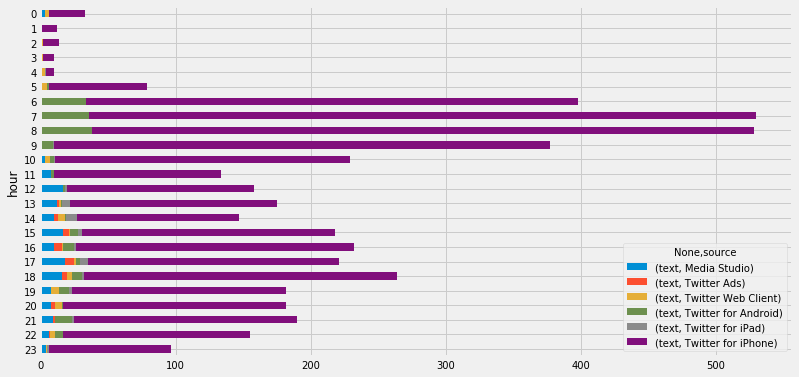

In [8]:
tweetsPerHour = tweets[['source', 'hour', 'text']].pivot_table(
    index='hour', columns=['source'], aggfunc='count')
tweetsPerHour.to_csv('output/tweets-per-hour-of-day.csv')
tweetsPerHour.iloc[::-1].plot(kind='barh', stacked=True)

## Tweets per day

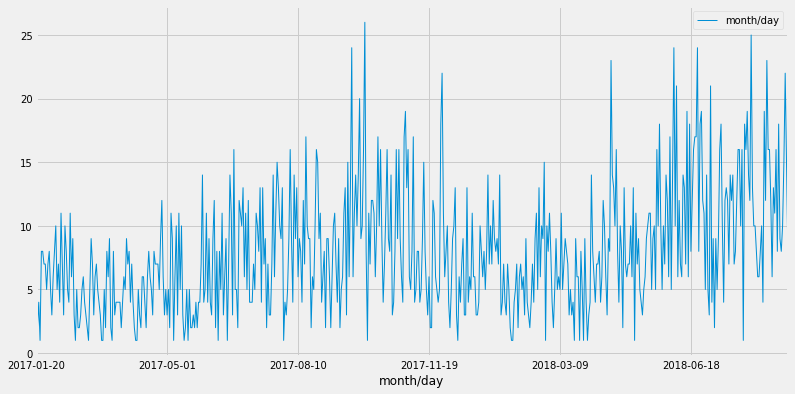

In [9]:
tweetsPerDay = tweets[['month/day']].groupby(tweets['month/day']).count()
# tweetsPerDay.iloc[::-1].plot(kind='barh', figsize=(12,100), fontsize=8)
tweetsPerDay.plot(kind='line', linewidth=1.0)

In [10]:
tweetsPerDay.describe()

,month/day
count,575.000000
mean,7.956522
std,4.778712
min,1.000000
25%,4.000000
50%,7.000000
75%,11.000000
max,26.000000


## Tweets per day of week

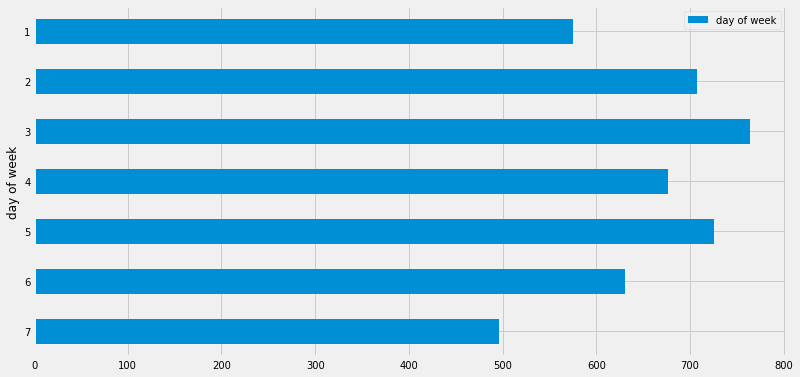

In [11]:
tweetsPerDayOfWeek = tweets[['day of week']].groupby(tweets['day of week']).count()
tweetsPerDayOfWeek.iloc[::-1].plot(kind='barh')
# tweetsPerDayOfWeek.plot(kind='bar')

## Tweets per month

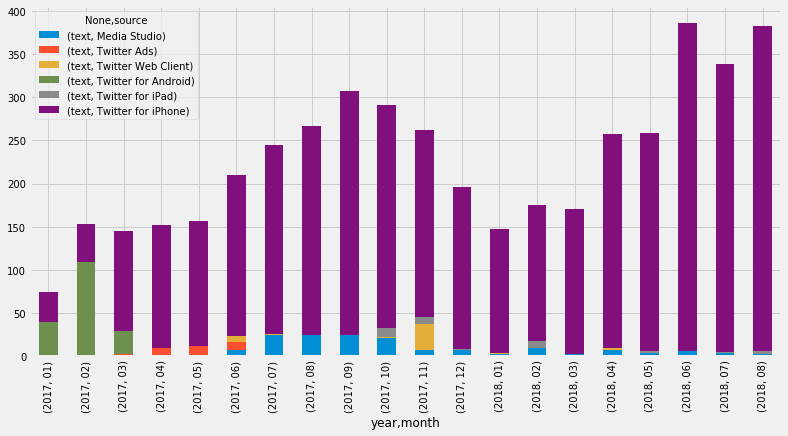

In [12]:
baseMonth = tweets[['source', 'year', 'month', 'text']].pivot_table(index=['year', 'month'], columns=['source'], aggfunc='count')

tweetsPerMonth = tweets[['source', 'year', 'month', 'text']].pivot_table(index=['year', 'month'], columns=['source'], aggfunc='count')
tweetsPerMonth = tweetsPerMonth.reindex_like(baseMonth)
# tweetsPerMonth.iloc[::-1].plot(kind='bar', stacked=True)
tweetsPerMonth.plot(kind='bar', stacked=True)

## Tweets per week

**IMPORTANT CAVEATS:**
- Weeks (2017, 53) and (2018, 1) might be the same week
- The way we're handling weekly data assumes that Trump tweets at least once per week -- which, so far, has held true. But if there's ever a week where he _doesn't_ tweet, then that could introduce a problem with the rendered charts. (The bar/week won't appear in the chart, and it might not be obvious that it's missing.)

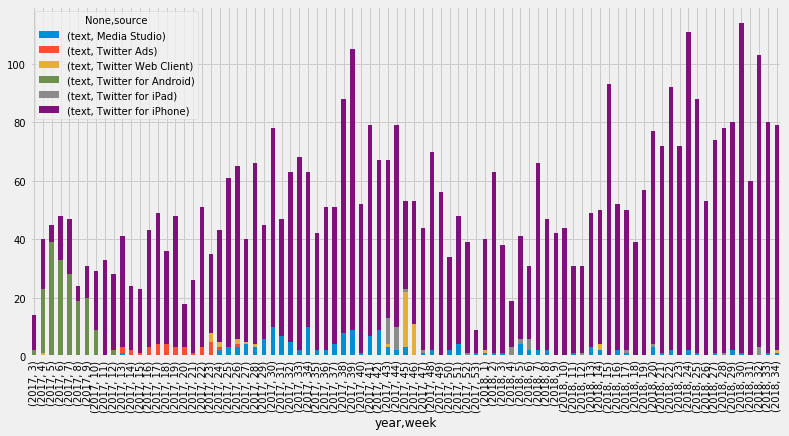

In [13]:
tweetsPerWeek = tweets[['source', 'year', 'week', 'text']].pivot_table(index=['year', 'week'], columns=['source'], aggfunc='count')
tweetsPerWeek.to_csv('output/tweetsperweek-by-device.csv', na_rep=0)
tweetsPerWeek.plot(kind='bar', stacked=True)

# Text analysis

Common words.

In [14]:
from collections import Counter
import nltk
import string
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/AHurt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
top_N = 100
stopwords = nltk.corpus.stopwords.words('english')
stopwords = stopwords + ['rt']
# RegEx for stopwords
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
# replace '|'-->' ' and drop all stopwords
words = (tweets.text
           .str.lower()
           .replace([r'\|', RE_stopwords], [' ', ''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DF out of Counter
words_data = pd.DataFrame(Counter(words).most_common(300),
                    columns=['Word', 'Frequency']).set_index('Word')

pd.set_option('display.max_rows', top_N)
words_data = words_data.reset_index()
words_data['Word Encoded'] = words_data['Word'].apply(encodeText)
words_data.drop('Word', axis=1).to_csv('output/word-frequencies.csv')
words_data.head(top_N)
#pd.reset_option('display.max_rows')

# plot
# rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

,Word,Frequency,Word Encoded
0,great,957,b'great'
1,&amp;,767,b'&amp;'
2,’,481,b''
3,!,433,b'!'
4,-,414,b'-'
5,",",390,"b','"
6,.,371,b'.'
7,people,348,b'people'
8,fake,324,b'fake'
9,big,316,b'big'


# Specific text searches

In [16]:
from IPython.display import display, Markdown

tweetsEnc = tweets.reset_index()

def analyzeText(search):
    display(Markdown('## Search: _{0}_'.format(search)))
    filtered = tweetsEnc[tweetsEnc['text'].str.contains(search, case=False)]
    count = len(filtered)
    percent = float(len(filtered))/len(tweetsEnc) * 100
    display(Markdown('Number of Tweets: {0}'.format(count)))
    display(Markdown('Percent of all Tweets: {0:.2f}%'.format(percent)))
    
    # set up the base data frame for indexing purposes
    baseWeek = tweets[['source', 'year', 'week', 'text']].pivot_table(index=['year', 'week'], columns=['source'], aggfunc='count')
    baseMonth = tweets[['source', 'year', 'month', 'text']].pivot_table(index=['year', 'month'], columns=['source'], aggfunc='count')

    # set up the filtered data frame
    analyzedByWeek = filtered[['source', 'year', 'week', 'text']].pivot_table(index=['year', 'week'], columns=['source'], aggfunc='count')
    analyzedByMonth = filtered[['source', 'year', 'month', 'text']].pivot_table(index=['year', 'month'], columns=['source'], aggfunc='count')
    analyzedByHour = filtered[['source', 'hour', 'text']].pivot_table(index=['hour'], columns=['source'], aggfunc='count')

    # adjust the filtered data frame to use the index from the base data frame
    analyzedByWeek = analyzedByWeek.reindex_like(baseWeek)
    analyzedByMonth = analyzedByMonth.reindex_like(baseMonth)
    analyzedByHour = analyzedByHour.reindex(range(0, 24)).fillna(0)

    # output filtered csv
    analyzedByMonth.to_csv('output/word-by-month-{0}.csv'.format(search))
    analyzedByWeek.to_csv('output/word-by-week-{0}.csv'.format(search))
#     analyzedByHour.to_csv('output/word-by-hour-{0}.csv'.format(search))

    # spit out the plot
    analyzedByWeekPlot = analyzedByWeek.plot(kind='bar', stacked=True, title='{0} by week'.format(search)) 
    plt.show()

    analyzedByMonthPlot = analyzedByMonth.plot(kind='bar', stacked=True, title='{0} by month'.format(search))
    plt.show()

    analyzedByHourPlot = analyzedByHour.plot(kind='bar', stacked=True, title='{0} by hour of day'.format(search))
    plt.show()

#     analyzedByDay = filtered[['source', 'month/day', 'text']].pivot_table(index='month/day', columns=['source'], aggfunc='count')
#     analyzedByDay = analyzedByDay.reindex(range(tweetsEnc['month/day'].min(), tweetsEnc['month/day'].max())).fillna(0)
#     analyzedByDay = analyzedByDay.reindex(tweetsEnc['month/day']).fillna(0)

    display(Markdown('### The Tweets'))
    for i, row in filtered.iterrows():
        display(Markdown('[{0}](https://twitter.com/realDonaldTrump/status/{2}): {1}'.format(row['human_date'], row['text'], row['id'])))
    display(Markdown('---'))

## Search: _phony_

Number of Tweets: 58

Percent of all Tweets: 1.27%

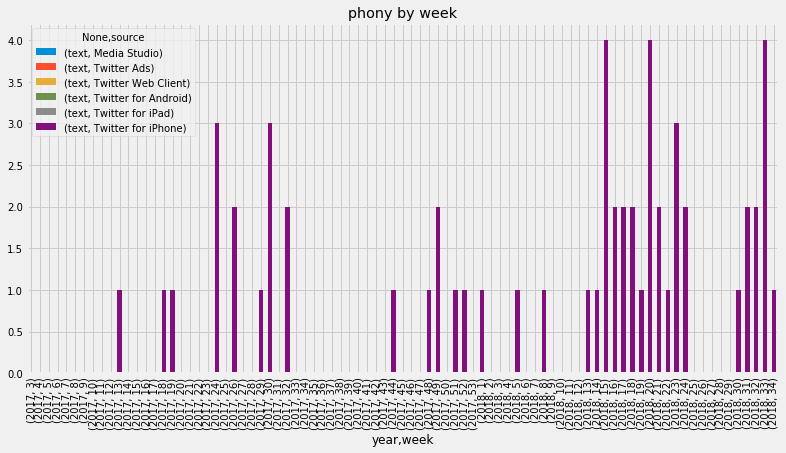

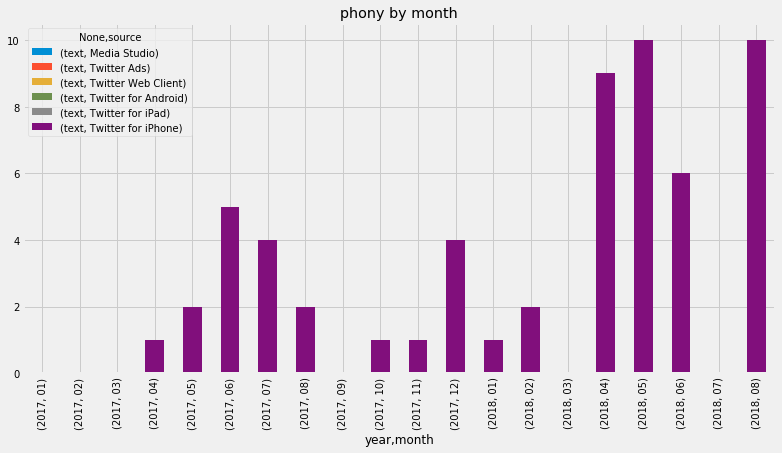

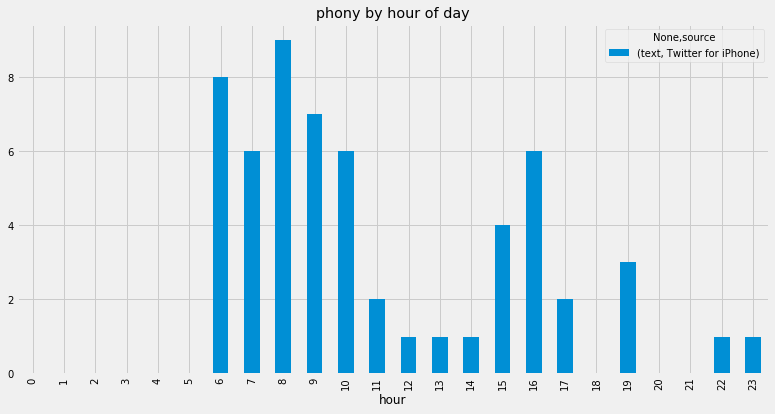

### The Tweets

[Sunday, Aug 26, 2018 9:21 AM](https://twitter.com/realDonaldTrump/status/1033706057330241537): RT @realDonaldTrump: ....FISA abuse, Christopher Steele &amp; his phony and corrupt Dossier, the Clinton Foundation, illegal surveillance of Tr…

[Saturday, Aug 25, 2018 8:16 AM](https://twitter.com/realDonaldTrump/status/1033327353227882496): Michaels Cohen’s attorney clarified the record, saying his client does not know if President Trump knew about the Trump Tower meeting (out of which came nothing!). The answer is that I did NOT know about the meeting. Just another phony story by the Fake News Media!

[Friday, Aug 24, 2018 6:28 AM](https://twitter.com/realDonaldTrump/status/1032937718219714560): ....FISA abuse, Christopher Steele &amp; his phony and corrupt Dossier, the Clinton Foundation, illegal surveillance of Trump Campaign, Russian collusion by Dems - and so much more. Open up the papers &amp; documents without redaction? Come on Jeff, you can do it, the country is waiting!

[Monday, Aug 20, 2018 10:36 AM](https://twitter.com/realDonaldTrump/status/1031550517552603138): Will Bruce Ohr, whose family received big money for helping to create the phony, dirty and discredited Dossier, ever be fired from the Jeff Sessions  “Justice” Department? A total joke!

[Monday, Aug 20, 2018 7:48 AM](https://twitter.com/realDonaldTrump/status/1031508193107763200): Where’s the Collusion? They made up a phony crime called Collusion, and when there was no Collusion they say there was Obstruction (of a phony crime that never existed). If you FIGHT BACK or say anything bad about the Rigged Witch Hunt, they scream Obstruction!

[Thursday, Aug 16, 2018 7:53 PM](https://twitter.com/realDonaldTrump/status/1030241273784020993): “Very concerned about Comey’s firing, afraid they will be exposed,” said Bruce Ohr. DOJ’s Emails &amp; Notes show Bruce Ohr’s connection to (phony &amp; discredited) Trump Dossier. A creep thinking he would get caught in a dishonest act. Rigged Witch Hunt!

[Sunday, Aug 12, 2018 8:24 AM](https://twitter.com/realDonaldTrump/status/1028618150944944129): .@JudgeJeanine  “Bob Mueller, isn’t your whole investigation premised on a Fake Dossier, paid for by Hillary, created by a man who hates Donald Trump, &amp; used to con a FISA Court Judge. Bob, I really think it’s time for you to give up your phony investigation.” No Collusion!

[Saturday, Aug 11, 2018 2:28 PM](https://twitter.com/realDonaldTrump/status/1028347518822825984): The big story that the Fake News Media refuses to report is lowlife Christopher Steele’s many meetings with Deputy A.G. Bruce Ohr and his beautiful wife, Nelly. It was Fusion GPS that hired Steele to write the phony &amp; discredited Dossier, paid for by Crooked Hillary &amp; the DNC....

[Thursday, Aug 9, 2018 12:02 PM](https://twitter.com/realDonaldTrump/status/1027585937163931648): This is an illegally brought Rigged Witch Hunt run by people who are totally corrupt and/or conflicted. It was started and paid for by Crooked Hillary and the Democrats. Phony Dossier, FISA disgrace and so many lying and dishonest people already fired. 17 Angry Dems? Stay tuned!

[Wednesday, Aug 1, 2018 10:01 AM](https://twitter.com/realDonaldTrump/status/1024656465158721536): Russian Collusion with the Trump Campaign, one of the most successful in history, is a TOTAL HOAX. The Democrats paid for the phony and discredited Dossier which was, along with Comey, McCabe, Strzok and his lover, the lovely Lisa Page, used to begin the Witch Hunt. Disgraceful!

[Friday, Jun 22, 2018 9:43 AM](https://twitter.com/realDonaldTrump/status/1010156224749408258): We must maintain a Strong Southern Border. We cannot allow our Country to be overrun by illegal immigrants as the Democrats tell their phony stories of sadness and grief, hoping it will help them in the elections. Obama and others had the same pictures, and did nothing about it!

[Sunday, Jun 17, 2018 10:54 AM](https://twitter.com/realDonaldTrump/status/1008362351807037441): WITCH HUNT! There was no Russian Collusion. Oh, I see, there was no Russian Collusion, so now they look for obstruction on the no Russian Collusion. The phony Russian Collusion was a made up Hoax. Too bad they didn’t look at Crooked Hillary like this. Double Standard!

[Friday, Jun 15, 2018 1:49 PM](https://twitter.com/realDonaldTrump/status/1007681553676283904): I’ve had to beat 17 very talented people including the Bush Dynasty, then I had to beat the Clinton Dynasty, and now I have to beat a phony Witch Hunt and all of the dishonest people covered in the IG Report...and never forget the Fake News Media. It never ends!

[Thursday, Jun 14, 2018 11:08 AM](https://twitter.com/realDonaldTrump/status/1007278701996802048): So, the Democrats make up a phony crime, Collusion with the Russians, pay a fortune to make the crime sound real, illegally leak (Comey) classified information so that a Special Councel will be appointed, and then Collude to make this pile of garbage take on life in Fake News!

[Wednesday, Jun 13, 2018 4:11 PM](https://twitter.com/realDonaldTrump/status/1006992524366503941): Senator Claire McCaskill of the GREAT State of Missouri flew around in a luxurious private jet during her RV tour of the state. RV’s are not for her. People are really upset, so phony! Josh Hawley should win big, and has my full endorsement.

[Monday, Jun 4, 2018 4:41 PM](https://twitter.com/realDonaldTrump/status/1003738642903420928): The Fake News Media is desperate to distract from the economy and record setting economic numbers and so they keep talking about the phony Russian Witch Hunt.

[Wednesday, May 30, 2018 11:06 PM](https://twitter.com/realDonaldTrump/status/1002023477531070464): The soon to be released book, “The Russia Hoax, The Illicit Scheme To Clear Hillary Clinton And Frame Donald Trump,” written by Gregg Jarrett, looks like a real deal big hit. The Phony Witch Hunt will be opened up for the world to see! Out in 5 weeks.

[Sunday, May 27, 2018 8:41 AM](https://twitter.com/realDonaldTrump/status/1000718611688943616): Who’s going to give back the young and beautiful lives (and others) that have been devastated and destroyed by the phony Russia Collusion Witch Hunt? They journeyed down to Washington, D.C., with stars in their eyes and wanting to help our nation...They went back home in tatters!

[Saturday, May 26, 2018 3:28 PM](https://twitter.com/realDonaldTrump/status/1000458567147839488): With Spies, or “Informants” as the Democrats like to call them because it sounds less sinister (but it’s not), all over my campaign, even from a very early date, why didn’t the crooked highest levels of the FBI or “Justice” contact me to tell me of the  phony Russia problem?

[Saturday, May 26, 2018 11:21 AM](https://twitter.com/realDonaldTrump/status/1000396430371106817): The Failing @nytimes quotes “a senior White House official,” who doesn’t exist, as saying “even if the meeting were reinstated, holding it on June 12 would be impossible, given the lack of time and the amount of planning needed.” WRONG AGAIN! Use real people, not phony sources.

[Wednesday, May 23, 2018 6:54 AM](https://twitter.com/realDonaldTrump/status/999242039723163648): Look how things have turned around on the Criminal Deep State. They go after Phony Collusion with Russia, a made up Scam, and end up getting caught in a major SPY scandal the likes of which this country may never have seen before! What goes around, comes around!

[Monday, May 21, 2018 8:01 AM](https://twitter.com/realDonaldTrump/status/998534123399663616): ....top of the FBI. Brennan started this entire debacle about President Trump. We now know that Brennan had detailed knowledge of the (phony) Dossier...he knows about the Dossier, he denies knowledge of the Dossier, he briefs the Gang of 8 on the Hill about the Dossier, which....

[Friday, May 18, 2018 9:50 AM](https://twitter.com/realDonaldTrump/status/997474432443707393): Reports are there was indeed at least one FBI representative implanted, for political purposes, into my campaign for president. It took place very early on, and long before the phony Russia Hoax became a “hot” Fake News story. If true - all time biggest political scandal!

[Monday, May 7, 2018 9:35 AM](https://twitter.com/realDonaldTrump/status/993484478633922560): Is this Phony Witch Hunt going to go on even longer so it wrongfully impacts the Mid-Term Elections, which is what the Democrats always intended? Republicans better get tough and smart before it is too late!

[Monday, May 7, 2018 7:27 AM](https://twitter.com/realDonaldTrump/status/993452275648679938): The Russia Witch Hunt is rapidly losing credibility. House Intelligence Committee found No Collusion, Coordination or anything else with Russia. So now the Probe says OK, what else is there? How about Obstruction for a made up, phony crime.There is no O, it’s called Fighting Back

[Tuesday, May 1, 2018 6:47 AM](https://twitter.com/realDonaldTrump/status/991267863674675200): So disgraceful that the questions concerning the Russian Witch Hunt were “leaked” to the media. No questions on Collusion. Oh, I see...you have a made up, phony crime, Collusion, that never existed, and an investigation begun with illegally leaked classified information. Nice!

[Monday, Apr 30, 2018 7:02 PM](https://twitter.com/realDonaldTrump/status/991090373417152515): The White House is running very smoothly despite phony Witch Hunts etc. There is great Energy and unending Stamina, both necessary to get things done. We are accomplishing the unthinkable and setting positive records while doing so! Fake News is going “bonkers!”

[Saturday, Apr 28, 2018 3:11 PM](https://twitter.com/realDonaldTrump/status/990307626784362496): Secret Service has just informed me that Senator Jon Tester’s statements on Admiral Jackson are not true. There were no such findings. A horrible thing that we in D.C. must live with, just like phony Russian Collusion. Tester should lose race in Montana. Very dishonest and sick!

[Saturday, Apr 28, 2018 8:07 AM](https://twitter.com/realDonaldTrump/status/990200773232529413): Allegations made by Senator Jon Tester against Admiral/Doctor Ron Jackson are proving false. The Secret Service is unable to confirm (in fact they deny) any of the phony Democrat charges which have absolutely devastated the wonderful Jackson family. Tester should resign. The.....

[Friday, Apr 20, 2018 4:25 PM](https://twitter.com/realDonaldTrump/status/987426984195174405): Can you believe that despite 93% bad stories from the Fake News Media (should be getting good stories), today we had just about our highest Poll Numbers, including those on Election Day? The American public is wise to the phony an dishonest press. Make America Great Again!

[Wednesday, Apr 18, 2018 8:05 AM](https://twitter.com/realDonaldTrump/status/986576502358671361): Slippery James Comey, the worst FBI Director in history, was not fired because of the phony Russia investigation where, by the way, there was NO COLLUSION (except by the Dems)!

[Sunday, Apr 15, 2018 10:44 AM](https://twitter.com/realDonaldTrump/status/985529299905187840): Just hit 50% in the Rasmussen Poll, much higher than President Obama at same point. With all of the phony stories and Fake News, it’s hard to believe! Thank you America, we are doing Great Things.

[Sunday, Apr 15, 2018 7:57 AM](https://twitter.com/realDonaldTrump/status/985487209510948864): The big questions in Comey’s badly reviewed book aren’t answered like, how come he gave up Classified Information (jail), why did he lie to Congress (jail), why did the DNC refuse to give Server to the FBI (why didn’t they TAKE it), why the phony memos, McCabe’s $700,000 &amp; more?

[Wednesday, Apr 11, 2018 6:30 AM](https://twitter.com/realDonaldTrump/status/984015782521835521): The Failing New York Times wrote another phony story. It was political pundit Doug Schoen, not a Ukrainian businessman, who asked me to do a short speech by phone (Skype), hosted by Doug, in Ukraine. I was very positive about Ukraine-another negative to the Fake Russia  C story!

[Thursday, Apr 5, 2018 9:10 AM](https://twitter.com/realDonaldTrump/status/981881669593559040): The Fake News Washington Post, Amazon’s “chief lobbyist,” has another (of many) phony headlines, “Trump Defiant As China Adds Trade Penalties.” WRONG! Should read, “Trump Defiant as U.S. Adds Trade Penalties, Will End Barriers And Massive  I.P. Theft.” Typically bad reporting!

[Saturday, Feb 24, 2018 7:56 PM](https://twitter.com/realDonaldTrump/status/967563946063523840): “Congressman Schiff omitted and distorted key facts” @FoxNews  So, what else is new. He is a total phony!

[Saturday, Feb 10, 2018 10:20 AM](https://twitter.com/realDonaldTrump/status/962345433170415616): According to the @nytimes, a Russian sold phony secrets on “Trump” to the U.S. Asking price was $10 million, brought down to $1 million to be paid over time. I hope people are now seeing &amp; understanding what is going on here. It is all now starting to come out - DRAIN THE SWAMP!

[Thursday, Jan 11, 2018 7:33 AM](https://twitter.com/realDonaldTrump/status/951431836030459905): “House votes on controversial FISA ACT today.” This is the act that may have been used, with the help of the discredited and phony Dossier, to so badly surveil and abuse the Trump Campaign by the previous administration and others?

[Saturday, Dec 30, 2017 5:36 PM](https://twitter.com/realDonaldTrump/status/947235015343202304): I use Social Media not because I like to, but because it is the only way to fight a VERY dishonest and unfair “press,” now often referred to as Fake News Media. Phony and non-existent “sources” are being used more often than ever. Many stories &amp; reports a pure fiction!

[Saturday, Dec 23, 2017 3:27 PM](https://twitter.com/realDonaldTrump/status/944665687292817415): How can FBI Deputy Director Andrew McCabe, the man in charge, along with leakin’ James Comey, of the Phony Hillary Clinton investigation (including her 33,000 illegally deleted emails) be given $700,000 for wife’s campaign by Clinton Puppets during investigation?

[Saturday, Dec 9, 2017 5:01 PM](https://twitter.com/realDonaldTrump/status/939616077356642304): .@DaveWeigel @WashingtonPost put out a phony photo of an empty arena hours before I arrived @ the venue, w/ thousands of people outside, on their way in. Real photos now shown as I spoke. Packed house, many people unable to get in. Demand apology &amp; retraction from FAKE NEWS WaPo! https://t.co/XAblFGh1ob

[Sunday, Dec 3, 2017 8:00 AM](https://twitter.com/realDonaldTrump/status/937305615218696193): After years of Comey, with the phony and dishonest Clinton investigation (and more), running the FBI, its reputation is in Tatters - worst in History! But fear not, we will bring it back to greatness.

[Sunday, Nov 26, 2017 4:29 PM](https://twitter.com/realDonaldTrump/status/934896989539586054): Since the first day I took office, all you hear is the phony Democrat excuse for losing the election, Russia, Russia,Russia.  Despite this I have the economy booming and have possibly done more than any 10 month President. MAKE AMERICA GREAT AGAIN!

[Sunday, Oct 29, 2017 10:02 AM](https://twitter.com/realDonaldTrump/status/924637600094326784): ...the Uranium to Russia deal, the  33,000 plus deleted Emails, the Comey fix and so much more. Instead they look at phony Trump/Russia,....

[Monday, Aug 7, 2017 7:47 AM](https://twitter.com/realDonaldTrump/status/894525428236464128): Interesting to watch Senator Richard Blumenthal of Connecticut talking about hoax Russian collusion when he was a  phony Vietnam con artist!

[Monday, Aug 7, 2017 6:58 AM](https://twitter.com/realDonaldTrump/status/894512983384129536): The Trump base is far bigger &amp;  stronger than ever before (despite some phony Fake News polling). Look at rallies in Penn, Iowa, Ohio.......

[Thursday, Jul 27, 2017 9:45 AM](https://twitter.com/realDonaldTrump/status/890568797941362690): ...about then candidate Trump." Catherine Herridge @FoxNews. So why doesn't Fake News report this? Witch Hunt! Purposely phony reporting.

[Sunday, Jul 23, 2017 4:11 PM](https://twitter.com/realDonaldTrump/status/889216341013655552): RT @realDonaldTrump: As the phony Russian Witch Hunt continues, two groups are laughing at this excuse for a lost election taking hold, Dem…

[Sunday, Jul 23, 2017 4:09 PM](https://twitter.com/realDonaldTrump/status/889215815022727168): As the phony Russian Witch Hunt continues, two groups are laughing at this excuse for a lost election taking hold, Democrats and Russians!

[Sunday, Jul 16, 2017 7:15 AM](https://twitter.com/realDonaldTrump/status/886544734788997125): With all of its phony unnamed sources &amp; highly slanted &amp; even fraudulent reporting, #Fake News is DISTORTING DEMOCRACY in our country!

[Tuesday, Jun 27, 2017 8:30 AM](https://twitter.com/realDonaldTrump/status/879678356450676736): Fake News CNN is looking at big management changes now that they got caught falsely pushing their phony Russian stories. Ratings way down!

[Tuesday, Jun 27, 2017 6:33 AM](https://twitter.com/realDonaldTrump/status/879648931172556802): Wow, CNN had to retract big story on "Russia," with 3 employees forced to resign. What about all the other phony stories they do? FAKE NEWS!

[Friday, Jun 16, 2017 8:54 AM](https://twitter.com/realDonaldTrump/status/875698062030778368): Despite the phony Witch Hunt going on in America, the economic &amp; jobs numbers are great. Regulations way down, jobs and enthusiasm way up!

[Thursday, Jun 15, 2017 6:55 AM](https://twitter.com/realDonaldTrump/status/875305788708974592): They made up a phony collusion with the Russians story, found zero proof, so now they go for obstruction of justice on the phony story. Nice

[Tuesday, Jun 13, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/874576057579565056): The Fake News Media has never been so wrong or so dirty. Purposely incorrect stories and phony sources to meet their agenda of hate. Sad!

[Wednesday, May 10, 2017 3:23 PM](https://twitter.com/realDonaldTrump/status/862387734492663808): Dems have been complaining for months &amp; months about Dir. Comey. Now that he has been fired they PRETEND to be aggrieved. Phony hypocrites!

[Tuesday, May 2, 2017 10:51 PM](https://twitter.com/realDonaldTrump/status/859601184285491201): FBI Director Comey was the best thing that ever happened to Hillary Clinton in that he gave her a free pass for many bad deeds! The phony...

[Saturday, Apr 1, 2017 9:02 AM](https://twitter.com/realDonaldTrump/status/848158641056362496): It is the same Fake News Media that said there is "no path to victory for Trump" that is now pushing the phony Russia story. A total scam!

---

## Search: _fake_

Number of Tweets: 336

Percent of all Tweets: 7.34%

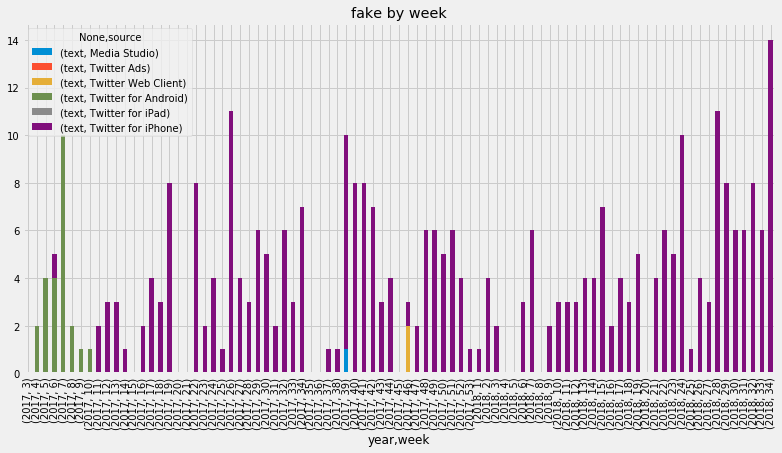

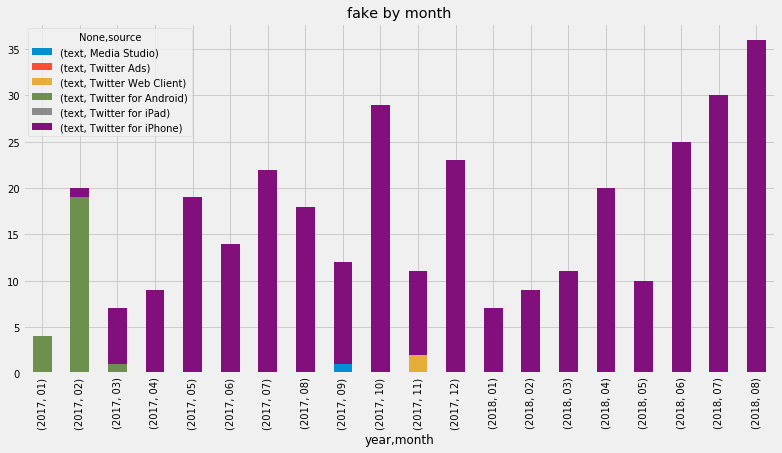

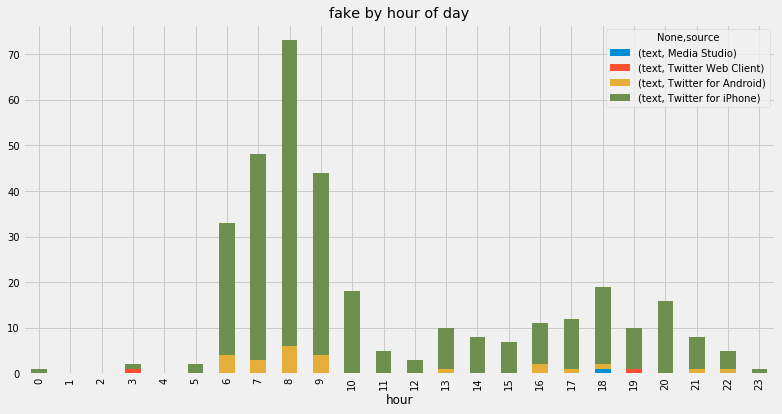

### The Tweets

[Friday, Aug 31, 2018 10:25 PM](https://twitter.com/realDonaldTrump/status/1035715271418413056): .@Rasmussen_Poll just came out at 48% approval rate despite the constant and intense Fake News. Higher than Election Day and higher than President Obama. Rasmussen was one of the most accurate Election Day polls!

[Thursday, Aug 30, 2018 9:39 AM](https://twitter.com/realDonaldTrump/status/1035159956507566080): I am very excited about the person who will be taking the place of Don McGahn as White House Counsel! I liked Don, but he was NOT responsible for me not firing Bob Mueller or Jeff Sessions. So much Fake Reporting and Fake News!

[Thursday, Aug 30, 2018 8:12 AM](https://twitter.com/realDonaldTrump/status/1035138155794575360): I am very excited about the person who will be taking the place of Don McGahn as White House Councel! I liked Don, but he was NOT responsible for me not firing Bob Mueller or Jeff Sessions. So much Fake Reporting and Fake News!

[Thursday, Aug 30, 2018 7:44 AM](https://twitter.com/realDonaldTrump/status/1035131133997068288): Ivanka Trump &amp; Jared Kushner had NOTHING to do with the so called “pushing out” of Don McGahn.The Fake News Media has it, purposely,so wrong! They love to portray chaos in the White House when they know that chaos doesn’t exist-just a “smooth running machine” with changing parts!

[Thursday, Aug 30, 2018 7:11 AM](https://twitter.com/realDonaldTrump/status/1035122954697433088): I just cannot state strongly enough how totally dishonest much of the Media is. Truth doesn’t matter to them, they only have their hatred &amp; agenda. This includes fake books, which come out about me all the time, always anonymous sources, and are pure fiction. Enemy of the People!

[Wednesday, Aug 29, 2018 9:43 PM](https://twitter.com/realDonaldTrump/status/1034979892524457985): “Ohr told the FBI it (the Fake Dossier) wasn’t true, it was a lie and the FBI was determined to use it anyway to damage Trump and to perpetrate a fraud on the court to spy on the Trump campaign. This is a fraud on the court. The Chief Justice of the U.S. Supreme Court is in......

[Wednesday, Aug 29, 2018 8:44 PM](https://twitter.com/realDonaldTrump/status/1034965029676883970): “Lanny Davis admits being anonymous source in CNN Report.” @BretBaier  Oh well, so much for CNN saying it wasn’t Lanny. No wonder their ratings are so low, it’s FAKE NEWS!

[Wednesday, Aug 29, 2018 6:43 PM](https://twitter.com/realDonaldTrump/status/1034934675972792320): CNN is being torn apart from within based on their being caught in a major lie and refusing to admit the mistake. Sloppy @carlbernstein, a man who lives in the past and thinks like a degenerate fool, making up story after story, is being laughed at all over the country! Fake News

[Wednesday, Aug 29, 2018 8:40 AM](https://twitter.com/realDonaldTrump/status/1034782741714399232): “Anonymous Sources are really starting to BURN the media.” @FoxNews The fact is that many anonymous sources don’t even exist. They are fiction made up by the Fake News reporters. Look at the lie that Fake CNN is now in. They got caught red handed! Enemy of the People!

[Tuesday, Aug 28, 2018 11:02 AM](https://twitter.com/realDonaldTrump/status/1034456273306243076): Google search results for “Trump News” shows only the viewing/reporting of Fake News Media. In other words, they have it RIGGED, for me &amp; others, so that almost all stories &amp; news is BAD. Fake CNN is prominent. Republican/Conservative &amp; Fair Media is shut out. Illegal? 96% of....

[Tuesday, Aug 28, 2018 5:24 AM](https://twitter.com/realDonaldTrump/status/1034371152204967936): Google search results for “Trump News” shows only the viewing/reporting of Fake New Media. In other words, they have it RIGGED, for me &amp; others, so that almost all stories &amp; news is BAD. Fake CNN is prominent. Republican/Conservative &amp; Fair Media  is shut out. Illegal?  96% of...

[Monday, Aug 27, 2018 9:37 AM](https://twitter.com/realDonaldTrump/status/1034072454086447104): The Fake News Media worked hard to get Tiger Woods to say something that he didn’t want to say. Tiger wouldn’t play the game - he is very smart. More importantly, he is playing great golf again!

[Sunday, Aug 26, 2018 8:39 PM](https://twitter.com/realDonaldTrump/status/1033876658439245825): Over 90% approval rating for your all time favorite (I hope) President within the Republican Party and 52% overall. This despite all of the made up stories by the Fake News Media trying endlessly to make me look as bad and evil as possible. Look at the real villains please!

[Sunday, Aug 26, 2018 10:25 AM](https://twitter.com/realDonaldTrump/status/1033722177156247552): RT @realDonaldTrump: Social Media Giants are silencing millions of people. Can’t do this even if it means we must continue to hear Fake New…

[Saturday, Aug 25, 2018 8:16 AM](https://twitter.com/realDonaldTrump/status/1033327353227882496): Michaels Cohen’s attorney clarified the record, saying his client does not know if President Trump knew about the Trump Tower meeting (out of which came nothing!). The answer is that I did NOT know about the meeting. Just another phony story by the Fake News Media!

[Friday, Aug 24, 2018 7:34 AM](https://twitter.com/realDonaldTrump/status/1032954224529817600): Social Media Giants are silencing millions of people. Can’t do this even if it means we must continue to hear Fake News like CNN, whose ratings have suffered gravely. People have to figure out what is real, and what is not, without censorship!

[Tuesday, Aug 21, 2018 7:10 AM](https://twitter.com/realDonaldTrump/status/1031861173149413376): Fake News, of which there is soooo much (this time the very tired New Yorker) falsely reported that I was going to take the extraordinary step of denying Intelligence Briefings to President Obama. Never discussed or thought of!

[Sunday, Aug 19, 2018 8:14 AM](https://twitter.com/realDonaldTrump/status/1031152483949838336): Some members of the media are very Angry at the Fake Story in the New York Times. They actually called to complain and apologize - a big step forward. From the day I announced, the Times has been Fake News, and with their disgusting new Board Member, it will only get worse!

[Sunday, Aug 19, 2018 8:06 AM](https://twitter.com/realDonaldTrump/status/1031150465759633408): The Failing New York Times wrote a story that made it seem like the White House Councel had TURNED on the President, when in fact it is just the opposite - &amp; the two Fake reporters knew this. This is why the Fake News Media has become the Enemy of the People. So bad for America!

[Sunday, Aug 19, 2018 7:01 AM](https://twitter.com/realDonaldTrump/status/1031134125602820096): The failing @nytimes wrote a Fake piece today implying that because White House Councel Don McGahn was giving hours of testimony to the Special Councel, he must be a John Dean type “RAT.” But I allowed him and all others to testify - I didn’t have to. I have nothing to hide......

[Saturday, Aug 18, 2018 7:32 AM](https://twitter.com/realDonaldTrump/status/1030779412973846529): .....Censorship is a very dangerous thing &amp; absolutely impossible to police. If you are weeding out Fake News, there is nothing so Fake as CNN &amp; MSNBC, &amp; yet I do not ask that their sick behavior be removed. I get used to it and watch with a grain of salt, or don’t watch at all..

[Thursday, Aug 16, 2018 8:45 PM](https://twitter.com/realDonaldTrump/status/1030254224330969090): .@TuckerCarlson speaking of John Brennan: “How did somebody so obviously limited intellectually get to be CIA Director in the first place?” Now that is a really good question! Then followed by “Richard Blumenthal of Connecticut is a FAKE War Hero...” So true, a total Fake!

[Thursday, Aug 16, 2018 10:10 AM](https://twitter.com/realDonaldTrump/status/1030094399362007040): There is nothing that I would want more for our Country than true FREEDOM OF THE PRESS. The fact is that the Press is FREE to write and say anything it wants, but much of what it says is FAKE NEWS, pushing a political agenda or just plain trying to hurt people. HONESTY WINS!

[Thursday, Aug 16, 2018 8:50 AM](https://twitter.com/realDonaldTrump/status/1030074380397752320): THE FAKE NEWS MEDIA IS THE OPPOSITION PARTY. It is very bad for our Great Country....BUT WE ARE WINNING!

[Tuesday, Aug 14, 2018 7:55 AM](https://twitter.com/realDonaldTrump/status/1029335579845115904): Bruce Ohr of the “Justice” Department (can you believe he is still there) is accused of helping disgraced Christopher Steele “find dirt on Trump.” Ohr’s wife, Nelly, was in on the act big time - worked for Fusion GPS on Fake Dossier. @foxandfriends

[Monday, Aug 13, 2018 9:57 PM](https://twitter.com/realDonaldTrump/status/1029185314752000007): ....such wonderful and powerful things about me - a true Champion of Civil Rights - until she got fired. Omarosa had Zero credibility with the Media (they didn’t want interviews) when she worked in the White House. Now that she says bad about me, they will talk to her. Fake News!

[Monday, Aug 13, 2018 10:21 AM](https://twitter.com/realDonaldTrump/status/1029010124881453056): While I know it’s “not presidential” to take on a lowlife like Omarosa, and while I would rather not be doing so, this is a modern day form of communication and I know the Fake News Media will be working overtime to make even Wacky Omarosa look legitimate as possible. Sorry!

[Sunday, Aug 12, 2018 8:24 AM](https://twitter.com/realDonaldTrump/status/1028618150944944129): .@JudgeJeanine  “Bob Mueller, isn’t your whole investigation premised on a Fake Dossier, paid for by Hillary, created by a man who hates Donald Trump, &amp; used to con a FISA Court Judge. Bob, I really think it’s time for you to give up your phony investigation.” No Collusion!

[Saturday, Aug 11, 2018 2:28 PM](https://twitter.com/realDonaldTrump/status/1028347518822825984): The big story that the Fake News Media refuses to report is lowlife Christopher Steele’s many meetings with Deputy A.G. Bruce Ohr and his beautiful wife, Nelly. It was Fusion GPS that hired Steele to write the phony &amp; discredited Dossier, paid for by Crooked Hillary &amp; the DNC....

[Wednesday, Aug 8, 2018 11:14 AM](https://twitter.com/realDonaldTrump/status/1027211440225243137): The Republicans have now won 8 out of 9 House Seats, yet if you listen to the Fake News Media you would think we are being clobbered. Why can’t they play it straight, so unfair to the Republican Party and in particular, your favorite President!

[Sunday, Aug 5, 2018 8:49 AM](https://twitter.com/realDonaldTrump/status/1026087766071947265): Too bad a large portion of the Media refuses to report the lies and corruption having to do with the Rigged Witch Hunt - but that is why we call them FAKE NEWS!

[Sunday, Aug 5, 2018 8:45 AM](https://twitter.com/realDonaldTrump/status/1026086905539174400): ...Why aren’t Mueller and the 17 Angry Democrats looking at the meetings concerning the Fake Dossier and all of the lying that went on in the FBI and DOJ? This is the most one sided Witch Hunt in the history of our country. Fortunately, the facts are all coming out, and fast!

[Sunday, Aug 5, 2018 8:35 AM](https://twitter.com/realDonaldTrump/status/1026084333315153924): Fake News reporting, a complete fabrication, that I am concerned about the meeting my wonderful son, Donald, had in Trump Tower. This was a meeting to get information on an opponent, totally legal and done all the time in politics - and it went nowhere. I did not know about it!

[Sunday, Aug 5, 2018 7:38 AM](https://twitter.com/realDonaldTrump/status/1026069857589227520): The Fake News hates me saying that they are the Enemy of the People only because they know it’s TRUE. I am providing a great service by explaining this to the American People. They purposely cause great division &amp; distrust. They can also cause War! They are very dangerous &amp; sick!

[Thursday, Aug 2, 2018 4:24 PM](https://twitter.com/realDonaldTrump/status/1025115155632455680): They asked my daughter Ivanka whether or not the media is the enemy of the people. She correctly said no. It is the FAKE NEWS, which is a large percentage of the media, that is the enemy of the people!

[Thursday, Aug 2, 2018 7:04 AM](https://twitter.com/realDonaldTrump/status/1024974107337781248): Wow, @foxandfriends is blowing away the competition in the morning ratings. Morning Joe is a dead show with very few people watching and sadly, Fake News CNN is also doing poorly. Too much hate and inaccurately reported stories - too predictable!

[Tuesday, Jul 31, 2018 9:34 AM](https://twitter.com/realDonaldTrump/status/1024287257975566338): The Fake News Media is going CRAZY! They are totally unhinged and in many ways, after witnessing first hand the damage they do to so many innocent and decent people, I enjoy watching. In 7 years, when I am no longer in office, their ratings will dry up and they will be gone!

[Sunday, Jul 29, 2018 8:30 AM](https://twitter.com/realDonaldTrump/status/1023546197129224192): Had a very good and interesting meeting at the White House with A.G. Sulzberger, Publisher of the New York Times. Spent much time talking about the vast amounts of Fake News being put out by the media &amp; how that Fake News has morphed into phrase, “Enemy of the People.” Sad!

[Sunday, Jul 29, 2018 7:59 AM](https://twitter.com/realDonaldTrump/status/1023538486081662976): RT @realDonaldTrump: Democrats, who want Open Borders and care little about Crime, are incompetent, but they have the Fake News Media almos…

[Sunday, Jul 29, 2018 7:52 AM](https://twitter.com/realDonaldTrump/status/1023536822901776384): Do you think the Fake News Media will ever report on this tweet from Michael? https://t.co/kXLCKZO5Fr

[Friday, Jul 27, 2018 6:45 PM](https://twitter.com/realDonaldTrump/status/1022976410745495552): Democrats, who want Open Borders and care little about Crime, are incompetent, but they have the Fake News Media almost totally on their side!

[Friday, Jul 27, 2018 7:38 AM](https://twitter.com/realDonaldTrump/status/1022808452677160960): ....,the only Collusion with Russia was with the Democrats, so now they are looking at my Tweets (along with 53 million other people) - the rigged Witch Hunt continues! How stupid and unfair to our Country....And so the Fake News doesn’t waste my time with dumb questions, NO,....

[Tuesday, Jul 24, 2018 8:39 PM](https://twitter.com/realDonaldTrump/status/1021917767467982854): So sad and unfair that the FCC wouldn’t approve the Sinclair Broadcast merger with Tribune. This would have been a great and much needed Conservative voice for and of the People. Liberal Fake News NBC and Comcast gets approved, much bigger, but not Sinclair. Disgraceful!

[Monday, Jul 23, 2018 9:06 AM](https://twitter.com/realDonaldTrump/status/1021380986452545537): A Rocket has not been launched by North Korea in 9 months. Likewise, no Nuclear Tests. Japan is happy, all of Asia is happy. But the Fake News is saying, without ever asking me (always anonymous sources), that I am angry because it is not going fast enough. Wrong, very happy!

[Monday, Jul 23, 2018 8:25 AM](https://twitter.com/realDonaldTrump/status/1021370601863294977): When you hear the Fake News talking negatively about my meeting with President Putin, and all that I gave up, remember, I gave up NOTHING, we merely talked about future benefits for both countries. Also, we got along very well, which is a good thing, except for the Corrupt Media!

[Monday, Jul 23, 2018 6:30 AM](https://twitter.com/realDonaldTrump/status/1021341698734030848): So we now find out that it was indeed the unverified and Fake Dirty Dossier, that was paid for by Crooked Hillary Clinton and the DNC, that was knowingly &amp; falsely submitted to FISA and which was responsible for starting the totally conflicted and discredited Mueller Witch Hunt!

[Sunday, Jul 22, 2018 9:15 AM](https://twitter.com/realDonaldTrump/status/1021020863733420032): I had a GREAT meeting with Putin and the Fake News used every bit of their energy to try and disparage it. So bad for our country!

[Sunday, Jul 22, 2018 8:56 AM](https://twitter.com/realDonaldTrump/status/1021016070134648833): .@PeteHegseth on @FoxNews  “Source #1 was the (Fake) Dossier. Yes, the Dirty Dossier, paid for by Democrats as a hit piece against Trump, and looking for information that could discredit Candidate #1 Trump. Carter Page was just the foot to surveil the Trump campaign...” ILLEGAL!

[Friday, Jul 20, 2018 5:50 PM](https://twitter.com/realDonaldTrump/status/1020425741664751616): I got severely criticized by the Fake News Media for being too nice to President Putin. In the Old Days they would call it Diplomacy. If I was loud &amp; vicious, I would have been criticized for being too tough. Remember when they said I was too tough with Chairman Kim? Hypocrites!

[Friday, Jul 20, 2018 10:39 AM](https://twitter.com/realDonaldTrump/status/1020317159828992000): RT @realDonaldTrump: The Summit with Russia was a great success, except with the real enemy of the people, the Fake News Media. I look forw…

[Friday, Jul 20, 2018 10:35 AM](https://twitter.com/realDonaldTrump/status/1020316392548196354): RT @realDonaldTrump: Will the Dems and Fake News ever learn? This is classic! https://t.co/kSX3ROI4QG

[Thursday, Jul 19, 2018 2:14 PM](https://twitter.com/realDonaldTrump/status/1020008975922810883): Will the Dems and Fake News ever learn? This is classic! https://t.co/kSX3ROI4QG

[Thursday, Jul 19, 2018 9:24 AM](https://twitter.com/realDonaldTrump/status/1019936133147516929): The Summit with Russia was a great success, except with the real enemy of the people, the Fake News Media. I look forward to our second meeting so that we can start implementing some of the many things discussed, including stopping terrorism, security for Israel, nuclear........

[Thursday, Jul 19, 2018 7:13 AM](https://twitter.com/realDonaldTrump/status/1019903123312308224): “Trump recognized Russian Meddling MANY TIMES.” Thank you to @foxandfriends and @FoxNews for actually showing the clips. The Fake News wants no part of that narrative! Too bad they don’t want to focus on all of the ECONOMIC and JOBS records being set.

[Thursday, Jul 19, 2018 6:59 AM](https://twitter.com/realDonaldTrump/status/1019899507910283264): The Fake News Media wants so badly to see a major confrontation with Russia, even a confrontation that could lead to war. They are pushing so recklessly hard and hate the fact that I’ll probably have a good relationship with Putin. We are doing MUCH better than any other country!

[Thursday, Jul 19, 2018 6:37 AM](https://twitter.com/realDonaldTrump/status/1019894101116948480): The Fake News Media is going Crazy! They make up stories without any backup, sources or proof. Many of the stories written about me, and the good people surrounding me, are total fiction. Problem is, when you complain you just give them more publicity. But I’ll complain anyway!

[Tuesday, Jul 17, 2018 8:21 PM](https://twitter.com/realDonaldTrump/status/1019376680572456960): The meeting between President Putin and myself was a great success, except in the Fake News Media!

[Tuesday, Jul 17, 2018 10:22 AM](https://twitter.com/realDonaldTrump/status/1019225830298456066): While I had a great meeting with NATO, raising vast amounts of money, I had an even better meeting with Vladimir Putin of Russia. Sadly, it is not being reported that way - the Fake News is going Crazy!

[Sunday, Jul 15, 2018 12:11 PM](https://twitter.com/realDonaldTrump/status/1018528420093878272): There hasn’t been a missile or rocket fired in 9 months in North Korea, there have been no nuclear tests and we got back our hostages. Who knows how it will all turn out in the end, but why isn’t the Fake News talking about these wonderful facts? Because it is FAKE NEWS!

[Saturday, Jul 14, 2018 2:17 PM](https://twitter.com/realDonaldTrump/status/1018197842559725569): These Russian individuals did their work during the Obama years. Why didn’t Obama do something about it?  Because he thought Crooked Hillary Clinton would win, that’s why. Had nothing to do with the Trump Administration, but Fake News doesn’t want to report the truth, as usual!

[Saturday, Jul 14, 2018 7:24 AM](https://twitter.com/realDonaldTrump/status/1018093807060045824): So funny! I just checked out Fake News CNN, for the first time in a long time (they are dying in the ratings), to see if they covered my takedown yesterday of Jim Acosta (actually a nice guy). They didn’t! But they did say I already lost in my meeting with Putin. Fake News......

[Monday, Jul 9, 2018 1:04 PM](https://twitter.com/realDonaldTrump/status/1016367395294908421): The failing NY Times Fake News story today about breast feeding must be called out. The U.S. strongly supports breast feeding but we don’t believe women should be denied access to formula. Many women need this option because of malnutrition and poverty.

[Saturday, Jul 7, 2018 9:21 AM](https://twitter.com/realDonaldTrump/status/1015586529484443648): Twitter is getting rid of fake accounts at a record pace. Will that include the Failing New York Times and propaganda machine for Amazon, the Washington Post, who constantly quote anonymous sources that, in my opinion, don’t exist - They will both be out of business in 7 years!

[Tuesday, Jul 3, 2018 7:13 PM](https://twitter.com/realDonaldTrump/status/1014286054805987330): After having written many best selling books, and somewhat priding myself on my ability to write, it should be noted that the Fake News constantly likes to pore over my tweets looking for a mistake. I capitalize certain words only for emphasis, not b/c they should be capitalized!

[Tuesday, Jul 3, 2018 5:19 PM](https://twitter.com/realDonaldTrump/status/1014257237945176071): After having written many best selling books, and somewhat priding myself on my ability to write, it should be noted that the Fake News constantly likes to pour over my tweets looking for a mistake. I capitalize certain words only for emphasis, not b/c they should be capitalized!

[Tuesday, Jul 3, 2018 7:16 AM](https://twitter.com/realDonaldTrump/status/1014105549624037377): Many good conversations with North Korea-it is going well! In the meantime, no Rocket Launches or Nuclear Testing in 8 months. All of Asia is thrilled. Only the Opposition Party, which includes the Fake News, is complaining. If not for me, we would now be at War with North Korea!

[Monday, Jun 25, 2018 8:36 AM](https://twitter.com/realDonaldTrump/status/1011226622324887556): Such a difference in the media coverage of the same immigration policies between the Obama Administration and ours. Actually, we have done a far better job in that our facilities are cleaner and better run than were the facilities under Obama. Fake News is working overtime!

[Saturday, Jun 23, 2018 8:52 AM](https://twitter.com/realDonaldTrump/status/1010505990259855361): Drudge Report  “OBAMA KEPT THEM IN CAGES, WRAPPED THEM IN FOIL” We do a much better job while at the same time maintaining a MUCH stronger Border! Mainstream Fake Media hates this story.

[Thursday, Jun 21, 2018 5:51 PM](https://twitter.com/realDonaldTrump/status/1009916650622251009): “I REALLY DON’T CARE, DO U?” written on the back of Melania’s jacket, refers to the Fake News Media. Melania has learned how dishonest they are, and she truly no longer cares!

[Wednesday, Jun 20, 2018 4:34 PM](https://twitter.com/realDonaldTrump/status/1009534957440516096): Look what Fake ABC News put out. I guess they had it prepared from the 13 Angry Democrats leading the Witch Hunt! #StopTheBias https://t.co/c0XOk1btEQ

[Wednesday, Jun 20, 2018 10:00 AM](https://twitter.com/realDonaldTrump/status/1009435777992884227): “FBI texts have revealed anti-Trump Bias.” @FoxNews  Big News, but the Fake News doesn’t want to cover. Total corruption - the Witch Hunt has turned out to be a scam! At some point soon the Mainstream Media will have to cover correctly, too big a story!

[Wednesday, Jun 20, 2018 8:25 AM](https://twitter.com/realDonaldTrump/status/1009411866475532288): The Fake News is not mentioning the safety and security of our Country when talking about illegal immigration. Our immigration laws are the weakest and worst anywhere in the world, and the Dems will do anything not to change them &amp; to obstruct-want open borders which means crime!

[Monday, Jun 18, 2018 10:57 AM](https://twitter.com/realDonaldTrump/status/1008725438972211200): If President Obama (who got nowhere with North Korea and would have had to go to war with many millions of people being killed) had gotten along with North Korea and made the initial steps toward a deal that I have, the Fake News would have named him a national hero!

[Sunday, Jun 17, 2018 8:25 PM](https://twitter.com/realDonaldTrump/status/1008506045373845504): Why was the FBI giving so much information to the Fake News Media. They are not supposed to be doing that, and knowing the enemy of the people Fake News, they put their own spin on it - truth doesn’t matter to them!

[Sunday, Jun 17, 2018 9:26 AM](https://twitter.com/realDonaldTrump/status/1008340100877570048): Washington Post employees want to go on strike because Bezos isn’t paying them enough. I think a really long strike would be a great idea. Employees would get more money and we would get rid of Fake News for an extended period of time! Is @WaPo a registered lobbyist?

[Sunday, Jun 17, 2018 8:40 AM](https://twitter.com/realDonaldTrump/status/1008328413210398720): Funny how the Fake News, in a coordinated effort with each other, likes to say I gave sooo much to North Korea because I “met.” That’s because that’s all they have to disparage! We got so much for peace in the world, &amp; more is being added in finals. Even got our hostages/remains!

[Sunday, Jun 17, 2018 7:58 AM](https://twitter.com/realDonaldTrump/status/1008317842264088576): Please clear up the Fake News! https://t.co/3VbIKbmKwP

[Friday, Jun 15, 2018 6:23 PM](https://twitter.com/realDonaldTrump/status/1007750530976927744): The Fake News Media said that I did not get along with other Leaders at the #G7Summit in Canada. They are once again, WRONG! https://t.co/I6eEKEZV6z

[Friday, Jun 15, 2018 6:03 PM](https://twitter.com/realDonaldTrump/status/1007745343306584064): I have a great relationship with Angela Merkel of Germany, but the Fake News Media only shows the bad photos (implying anger) of negotiating an agreement - where I am asking for things that no other American President would ask for! https://t.co/Ib97nN5HZt

[Friday, Jun 15, 2018 1:49 PM](https://twitter.com/realDonaldTrump/status/1007681553676283904): I’ve had to beat 17 very talented people including the Bush Dynasty, then I had to beat the Clinton Dynasty, and now I have to beat a phony Witch Hunt and all of the dishonest people covered in the IG Report...and never forget the Fake News Media. It never ends!

[Thursday, Jun 14, 2018 11:08 AM](https://twitter.com/realDonaldTrump/status/1007278701996802048): So, the Democrats make up a phony crime, Collusion with the Russians, pay a fortune to make the crime sound real, illegally leak (Comey) classified information so that a Special Councel will be appointed, and then Collude to make this pile of garbage take on life in Fake News!

[Wednesday, Jun 13, 2018 9:30 AM](https://twitter.com/realDonaldTrump/status/1006891643985854464): So funny to watch the Fake News, especially NBC and CNN. They are fighting hard to downplay the deal with North Korea. 500 days ago they would have “begged” for this deal-looked like war would break out. Our Country’s biggest enemy is the Fake News so easily promulgated by fools!

[Wednesday, Jun 6, 2018 10:04 AM](https://twitter.com/realDonaldTrump/status/1004363400674234368): Many more Republican voters showed up yesterday than the Fake News thought possible. The political pundits just don’t get what is going on out there - or they do get it but refuse to report the facts! Remember, Dems are High Tax, High Crime, easy to beat!

[Wednesday, Jun 6, 2018 9:54 AM](https://twitter.com/realDonaldTrump/status/1004360833407815680): ...Four reporters spotted Melania in the White House last week walking merrily along to a meeting. They never reported the sighting because it would hurt the sick narrative that she was living in a different part of the world, was really ill, or whatever. Fake News is really bad!

[Wednesday, Jun 6, 2018 9:48 AM](https://twitter.com/realDonaldTrump/status/1004359335399641089): The Fake News Media has been so unfair, and vicious, to my wife and our great First Lady, Melania. During her recovery from surgery they reported everything from near death, to facelift, to left the W.H. (and me) for N.Y. or Virginia, to abuse. All Fake, she is doing really well!

[Wednesday, Jun 6, 2018 9:16 AM](https://twitter.com/realDonaldTrump/status/1004351340041199616): Great night for Republicans! Congratulations to John Cox on a really big number in California. He can win. Even Fake News CNN said the Trump impact was really big, much bigger than they ever thought possible. So much for the big Blue Wave, it may be a big Red Wave. Working hard!

[Tuesday, Jun 5, 2018 8:43 PM](https://twitter.com/realDonaldTrump/status/1004161816501673985): RT @parscale: Since the #FakeNews is full of distortions, underreporting, and lies, we launched a platform tonight presenting a comprehensi…

[Monday, Jun 4, 2018 4:41 PM](https://twitter.com/realDonaldTrump/status/1003738642903420928): The Fake News Media is desperate to distract from the economy and record setting economic numbers and so they keep talking about the phony Russian Witch Hunt.

[Saturday, Jun 2, 2018 1:43 PM](https://twitter.com/realDonaldTrump/status/1002968869043097600): There was No Collusion with Russia (except by the Democrats). When will this very expensive Witch Hunt Hoax ever end? So bad for our Country. Is the Special Counsel/Justice Department leaking my lawyers letters to the Fake News Media? Should be looking at Dems corruption instead?

[Saturday, Jun 2, 2018 1:31 PM](https://twitter.com/realDonaldTrump/status/1002965829175169025): There was No Collusion with Russia (except by the Democrats). When will this very expensive Witch Hunt Hoax ever end? So bad for our Country. Is the Special Councel/Justice Department leaking my lawyers letters to the Fake News Media? Should be looking at Dems corruption instead?

[Saturday, Jun 2, 2018 12:46 PM](https://twitter.com/realDonaldTrump/status/1002954515941941249): Real @FoxNews is doing great, Fake News CNN is dead! https://t.co/1p37tPiB3v

[Tuesday, May 29, 2018 9:30 AM](https://twitter.com/realDonaldTrump/status/1001455721588969472): The Fake Mainstream Media has, from the time I announced I was running for President, run the most highly sophisticated &amp; dishonest Disinformation Campaign in the history of politics. No matter how well WE do, they find fault. But the forgotten men &amp; women WON, I’m President!

[Friday, May 18, 2018 9:50 AM](https://twitter.com/realDonaldTrump/status/997474432443707393): Reports are there was indeed at least one FBI representative implanted, for political purposes, into my campaign for president. It took place very early on, and long before the phony Russia Hoax became a “hot” Fake News story. If true - all time biggest political scandal!

[Friday, May 18, 2018 6:51 AM](https://twitter.com/realDonaldTrump/status/997429518867591170): Fake News Media had me calling Immigrants, or Illegal Immigrants, “Animals.” Wrong! They were begrudgingly forced to withdraw their stories. I referred to MS 13 Gang Members as “Animals,” a big difference - and so true. Fake News got it purposely wrong, as usual!

[Thursday, May 17, 2018 9:52 AM](https://twitter.com/realDonaldTrump/status/997112687799697408): Despite the disgusting, illegal and unwarranted Witch Hunt, we have had the most successful first 17 month Administration in U.S. history - by far! Sorry to the Fake News Media and “Haters,” but that’s the way it is!

[Tuesday, May 15, 2018 10:08 AM](https://twitter.com/realDonaldTrump/status/996391840860471296): Can you believe that with all of the made up, unsourced stories I get from the Fake News Media, together with the  $10,000,000 Russian Witch Hunt (there is no Collusion), I now have my best Poll Numbers in a year. Much of the Media may be corrupt, but the People truly get it!

[Monday, May 14, 2018 4:46 PM](https://twitter.com/realDonaldTrump/status/996129630913482755): The so-called leaks coming out of the White House are a massive over  exaggeration put out by the Fake News Media in order to make us look as bad as possible. With that being said, leakers are traitors and cowards, and we will find out who they are!

[Friday, May 11, 2018 7:49 PM](https://twitter.com/realDonaldTrump/status/995088584221839360): Why doesn’t the Fake News Media state that the Trump Administration’s Anti-Trust Division has been, and is, opposed to the AT&amp;T purchase of Time Warner in a currently ongoing Trial. Such a disgrace in reporting!

[Wednesday, May 9, 2018 6:38 PM](https://twitter.com/realDonaldTrump/status/994345813064192012): The Failing New York Times criticized Secretary of State Pompeo for being AWOL (missing), when in fact he was flying to North Korea. Fake News, so bad!

[Wednesday, May 9, 2018 7:38 AM](https://twitter.com/realDonaldTrump/status/994179864436596736): The Fake News is working overtime. Just reported that, despite the tremendous success we are having with the economy &amp; all things else, 91% of the Network News about me is negative (Fake). Why do we work so hard in working with the media when it is corrupt? Take away credentials?

[Friday, May 4, 2018 6:45 AM](https://twitter.com/realDonaldTrump/status/992354530510721025): NBC NEWS is wrong again! They cite “sources” which are constantly wrong. Problem is, like so many others, the sources probably don’t exist, they are fabricated, fiction! NBC, my former home with the Apprentice, is now as bad as Fake News CNN. Sad!

[Monday, Apr 30, 2018 7:02 PM](https://twitter.com/realDonaldTrump/status/991090373417152515): The White House is running very smoothly despite phony Witch Hunts etc. There is great Energy and unending Stamina, both necessary to get things done. We are accomplishing the unthinkable and setting positive records while doing so! Fake News is going “bonkers!”

[Monday, Apr 30, 2018 6:49 PM](https://twitter.com/realDonaldTrump/status/991087278515769345): The Fake News is going crazy making up false stories and using only unnamed sources (who don’t exist). They are totally unhinged, and the great success of this Administration is making them do and say things that even they can’t believe they are saying. Truly bad people!

[Monday, Apr 30, 2018 8:10 AM](https://twitter.com/realDonaldTrump/status/990926480329859073): The White House Correspondents’ Dinner is DEAD as we know it. This was a total disaster and an embarrassment to our great Country and all that it stands for. FAKE NEWS is alive and well and beautifully represented on Saturday night!

[Saturday, Apr 28, 2018 8:58 AM](https://twitter.com/realDonaldTrump/status/990213619190202369): “Clapper lied about (fraudulent) Dossier leaks to CNN” @foxandfriends FoxNews  He is a lying machine who now works for Fake News CNN.

[Sunday, Apr 22, 2018 8:50 AM](https://twitter.com/realDonaldTrump/status/988037292932653056): Sleepy Eyes Chuck Todd of Fake News NBC just stated that we have given up so much in our negotiations with North Korea, and they have given up nothing. Wow, we haven’t given up anything &amp; they have agreed to denuclearization (so great for World), site closure, &amp; no more testing!

[Saturday, Apr 21, 2018 4:13 PM](https://twitter.com/realDonaldTrump/status/987786331995672576): The Washington Post said I refer to Jeff Sessions as “Mr. Magoo” and Rod Rosenstein as “Mr. Peepers.” This is “according to people with whom the president has spoken.” There are no such people and don’t know these characters...just more Fake &amp; Disgusting News to create ill will!

[Friday, Apr 20, 2018 4:25 PM](https://twitter.com/realDonaldTrump/status/987426984195174405): Can you believe that despite 93% bad stories from the Fake News Media (should be getting good stories), today we had just about our highest Poll Numbers, including those on Election Day? The American public is wise to the phony an dishonest press. Make America Great Again!

[Wednesday, Apr 18, 2018 6:08 AM](https://twitter.com/realDonaldTrump/status/986547093610299392): A sketch years later about a nonexistent man. A total con job, playing the Fake News Media for Fools (but they know it)! https://t.co/9Is7mHBFda

[Tuesday, Apr 17, 2018 1:59 PM](https://twitter.com/realDonaldTrump/status/986303188587425794): Rasmussen just came out at 51% Approval despite the Fake News Media. They were one of the three most accurate on Election Day. Just about the most inaccurate were CNN and ABC News/Washington Post, and they haven’t changed (get new pollsters). Much of the media is a Scam!

[Sunday, Apr 15, 2018 10:44 AM](https://twitter.com/realDonaldTrump/status/985529299905187840): Just hit 50% in the Rasmussen Poll, much higher than President Obama at same point. With all of the phony stories and Fake News, it’s hard to believe! Thank you America, we are doing Great Things.

[Sunday, Apr 15, 2018 8:32 AM](https://twitter.com/realDonaldTrump/status/985496023555608576): I never asked Comey for Personal Loyalty. I hardly even knew this guy. Just another of his many lies. His “memos” are self serving and FAKE!

[Sunday, Apr 15, 2018 8:19 AM](https://twitter.com/realDonaldTrump/status/985492862958698497): The Syrian raid was so perfectly carried out, with such precision, that the only way the Fake News Media could demean was by my use of the term “Mission Accomplished.” I knew they would seize on this but felt it is such a great Military term, it should be brought back. Use often!

[Thursday, Apr 12, 2018 6:03 AM](https://twitter.com/realDonaldTrump/status/984371491277099010): If I wanted to fire Robert Mueller in December, as reported by the Failing New York Times, I would have fired him. Just more Fake News from a biased newspaper!

[Wednesday, Apr 11, 2018 9:00 AM](https://twitter.com/realDonaldTrump/status/984053549742067712): Much of the bad blood with Russia is caused by the Fake &amp; Corrupt Russia Investigation, headed up by the all Democrat loyalists, or people that worked for Obama. Mueller is most conflicted of all (except Rosenstein who signed FISA &amp; Comey letter). No Collusion, so they go crazy!

[Wednesday, Apr 11, 2018 6:38 AM](https://twitter.com/realDonaldTrump/status/984017894240604161): So much Fake News about what is going on in the White House. Very calm and calculated with a big focus on open and fair trade with China, the coming North Korea meeting and, of course, the vicious gas attack in Syria. Feels great to have Bolton &amp; Larry K on board. I (we) are

[Wednesday, Apr 11, 2018 6:30 AM](https://twitter.com/realDonaldTrump/status/984015782521835521): The Failing New York Times wrote another phony story. It was political pundit Doug Schoen, not a Ukrainian businessman, who asked me to do a short speech by phone (Skype), hosted by Doug, in Ukraine. I was very positive about Ukraine-another negative to the Fake Russia  C story!

[Friday, Apr 6, 2018 10:46 AM](https://twitter.com/realDonaldTrump/status/982268230306709509): Do you believe that the Fake News Media is pushing hard on a story that I am going to replace A.G. Jeff Sessions with EPA Chief Scott Pruitt, who is doing a great job but is TOTALLY under siege? Do people really believe this stuff? So much of the media is dishonest and corrupt!

[Thursday, Apr 5, 2018 9:10 AM](https://twitter.com/realDonaldTrump/status/981881669593559040): The Fake News Washington Post, Amazon’s “chief lobbyist,” has another (of many) phony headlines, “Trump Defiant As China Adds Trade Penalties.” WRONG! Should read, “Trump Defiant as U.S. Adds Trade Penalties, Will End Barriers And Massive  I.P. Theft.” Typically bad reporting!

[Tuesday, Apr 3, 2018 6:34 AM](https://twitter.com/realDonaldTrump/status/981117684489379840): The Fake News Networks, those that knowingly have a sick and biased AGENDA, are worried about the competition and quality of Sinclair Broadcast. The “Fakers” at CNN, NBC, ABC &amp; CBS have done so much dishonest reporting that they should only be allowed to get awards for fiction!

[Monday, Apr 2, 2018 9:28 AM](https://twitter.com/realDonaldTrump/status/980799183425802240): So funny to watch Fake News Networks, among the most dishonest groups of people I have ever dealt with, criticize Sinclair Broadcasting for being biased. Sinclair is far superior to CNN and even more Fake NBC, which is a total joke.

[Saturday, Mar 31, 2018 8:52 AM](https://twitter.com/realDonaldTrump/status/980065419632566272): ...does not include the Fake Washington Post, which is used as a “lobbyist” and should so  REGISTER. If the P.O. “increased its parcel rates, Amazon’s shipping costs would rise by $2.6 Billion.” This Post Office scam must stop. Amazon must pay real costs (and taxes) now!

[Monday, Mar 26, 2018 8:38 AM](https://twitter.com/realDonaldTrump/status/978249938743234560): So much Fake News. Never been more voluminous or more inaccurate. But through it all, our country is doing great!

[Sunday, Mar 25, 2018 7:40 AM](https://twitter.com/realDonaldTrump/status/977872899792089088): Many lawyers and top law firms want to represent me in the Russia case...don’t believe the Fake News narrative that it is hard to find a lawyer who wants to take this on. Fame &amp; fortune will NEVER be turned down by a lawyer, though some are conflicted. Problem is that a new......

[Wednesday, Mar 21, 2018 2:56 PM](https://twitter.com/realDonaldTrump/status/976532956557737984): I called President Putin of Russia to congratulate him on his election victory (in past, Obama called him also). The Fake News Media is crazed because they wanted me to excoriate him. They are wrong! Getting along with Russia (and others) is a good thing, not a bad thing.......

[Sunday, Mar 18, 2018 8:22 AM](https://twitter.com/realDonaldTrump/status/975346628113596417): Spent very little time with Andrew McCabe, but he never took notes when he was with me. I don’t believe he made memos except to help his own agenda, probably at a later date. Same with lying James Comey. Can we call them Fake Memos?

[Saturday, Mar 17, 2018 8:12 PM](https://twitter.com/realDonaldTrump/status/975163071361683456): The Mueller probe should never have been started in that there was no collusion and there was no crime. It was based on fraudulent activities and a Fake Dossier paid for by Crooked Hillary and the DNC, and improperly used in FISA COURT for surveillance of my campaign. WITCH HUNT!

[Saturday, Mar 17, 2018 1:34 PM](https://twitter.com/realDonaldTrump/status/975062797162811394): The Fake News is beside themselves that McCabe was caught, called out and fired. How many hundreds of thousands of dollars was given to wife’s campaign by Crooked H friend, Terry M, who was also under investigation? How many lies? How many leaks? Comey knew it all, and much more!

[Sunday, Mar 11, 2018 11:16 AM](https://twitter.com/realDonaldTrump/status/972853747750711296): Rasmussen and others have my approval ratings at around 50%, which is higher than Obama, and yet the political pundits love saying my approval ratings are “somewhat low.” They know they are lying when they say it. Turn off the show - FAKE NEWS!

[Sunday, Mar 11, 2018 10:02 AM](https://twitter.com/realDonaldTrump/status/972835128056664066): The Republicans are 5-0 in recent Congressional races, a point which the Fake News Media continuously fails to mention. I backed and campaigned for all of the winners. They give me credit for one. Hopefully, Rick Saccone will be another big win on Tuesday.

[Saturday, Mar 10, 2018 3:02 PM](https://twitter.com/realDonaldTrump/status/972563247160274947): In the first hours after hearing that North Korea’s leader wanted to meet with me to talk denuclearization and that missile launches will end, the press was startled &amp; amazed.They couldn’t believe it. But by the following morning the news became FAKE.They said so what, who cares!

[Tuesday, Mar 6, 2018 7:55 AM](https://twitter.com/realDonaldTrump/status/971006379375972354): The new Fake News narrative is that there is CHAOS in the White House. Wrong! People will always come &amp; go, and I want strong dialogue before making a final decision. I still have some people that I want to change (always seeking perfection). There is no Chaos, only great Energy!

[Thursday, Feb 22, 2018 8:26 PM](https://twitter.com/realDonaldTrump/status/966846679784837120): “School shooting survivor says he quit @CNN Town Hall after refusing scripted question.” @TuckerCarlson. Just like so much of CNN, Fake News. That’s why their ratings are so bad! MSNBC may be worse.

[Thursday, Feb 22, 2018 7:26 AM](https://twitter.com/realDonaldTrump/status/966650397002813440): I never said “give teachers guns” like was stated on Fake News @CNN &amp; @NBC. What I said was to look at the possibility of giving “concealed guns to gun adept teachers with military or special training experience - only the best. 20% of teachers, a lot, would now be able to

[Tuesday, Feb 20, 2018 8:08 PM](https://twitter.com/realDonaldTrump/status/966117265426001920): Bad ratings @CNN &amp; @MSNBC got scammed when they covered the anti-Trump Russia rally wall-to-wall. They probably knew it was Fake News but, because it was a rally against me, they pushed it hard anyway. Two really dishonest newscasters, but the public is wise!

[Tuesday, Feb 20, 2018 10:16 AM](https://twitter.com/realDonaldTrump/status/965968309358333952): A woman I don’t know and, to the best of my knowledge, never met, is on the FRONT PAGE of the Fake News Washington Post saying I kissed her (for two minutes yet) in the lobby of Trump Tower 12 years ago. Never happened! Who would do this in a public space with live security......

[Tuesday, Feb 20, 2018 8:38 AM](https://twitter.com/realDonaldTrump/status/965943827931549696): I have been much tougher on Russia than Obama, just look at the facts. Total Fake News!

[Sunday, Feb 18, 2018 8:46 AM](https://twitter.com/realDonaldTrump/status/965221024496279552): The Fake News of big ratings loser CNN. https://t.co/rYsv90cnvs

[Saturday, Feb 17, 2018 3:11 PM](https://twitter.com/realDonaldTrump/status/964955496137535488): The Fake News Media never fails. Hard to ignore this fact from the Vice President of Facebook Ads, Rob Goldman! https://t.co/XGC7ynZwYJ

[Saturday, Feb 17, 2018 2:46 PM](https://twitter.com/realDonaldTrump/status/964949269374529538): Funny how the Fake News Media doesn’t want to say that the Russian group was formed in 2014, long before my run for President. Maybe they knew I was going to run even though I didn’t know!

[Sunday, Feb 11, 2018 1:21 PM](https://twitter.com/realDonaldTrump/status/962753552824365056): So many positive things going on for the U.S.A. and the Fake News Media just doesn’t want to go there. Same negative stories over and over again! No wonder the People no longer trust the media, whose approval ratings are correctly at their lowest levels in history!    #MAGA

[Tuesday, Jan 23, 2018 9:16 AM](https://twitter.com/realDonaldTrump/status/955806333667807232): Thank you to General John Kelly, who is doing a fantastic job, and all of the Staff and others in the White House, for a job well done. Long hours and Fake reporting makes your job more difficult, but it is always great to WIN, and few have won more than us!

[Tuesday, Jan 23, 2018 6:31 AM](https://twitter.com/realDonaldTrump/status/955764970590961665): Even Crazy Jim Acosta of Fake News CNN agrees: “Trump World and WH sources dancing in end zone: Trump wins again...Schumer and Dems caved...gambled and lost.” Thank you for your honesty Jim!

[Wednesday, Jan 17, 2018 8:00 PM](https://twitter.com/realDonaldTrump/status/953794085751574534): And the FAKE NEWS winners are...
https://t.co/59G6x2f7fD

[Tuesday, Jan 16, 2018 9:19 AM](https://twitter.com/realDonaldTrump/status/953270558573154305): Do you notice the Fake News Mainstream Media never likes covering the great and record setting economic news, but rather talks about anything negative or that can be turned into the negative. The Russian Collusion Hoax is dead, except as it pertains to the Dems. Public gets it!

[Sunday, Jan 14, 2018 8:04 AM](https://twitter.com/realDonaldTrump/status/952526791658360833): RT @realDonaldTrump: So much Fake News is being reported. They don’t even try to get it right, or correct it when they are wrong. They prom…

[Sunday, Jan 14, 2018 8:01 AM](https://twitter.com/realDonaldTrump/status/952526145064505345): ...and they knew exactly what I said and meant. They just wanted a story. FAKE NEWS!

[Saturday, Jan 13, 2018 5:08 PM](https://twitter.com/realDonaldTrump/status/952301373479104512): So much Fake News is being reported. They don’t even try to get it right, or correct it when they are wrong. They promote the Fake Book of a mentally deranged author, who knowingly writes false information. The Mainstream Media is crazed that WE won the election!

[Sunday, Dec 31, 2017 5:18 PM](https://twitter.com/realDonaldTrump/status/947592785519173637): As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!

[Saturday, Dec 30, 2017 5:36 PM](https://twitter.com/realDonaldTrump/status/947235015343202304): I use Social Media not because I like to, but because it is the only way to fight a VERY dishonest and unfair “press,” now often referred to as Fake News Media. Phony and non-existent “sources” are being used more often than ever. Many stories &amp; reports a pure fiction!

[Friday, Dec 29, 2017 7:46 AM](https://twitter.com/realDonaldTrump/status/946724075157651457): While the Fake News loves to talk about my so-called low approval rating, @foxandfriends just showed that my rating on Dec. 28, 2017, was approximately the same as President Obama on Dec. 28, 2009, which was 47%...and this despite massive negative Trump coverage &amp; Russia hoax!

[Sunday, Dec 24, 2017 3:35 PM](https://twitter.com/realDonaldTrump/status/945030174290186241): The Tax Cut/Reform Bill, including Massive Alaska Drilling and the Repeal of the highly unpopular Individual Mandate, brought it all together as to what an incredible year we had. Don’t let the Fake News convince you otherwise...and our insider Polls are strong!

[Sunday, Dec 24, 2017 8:48 AM](https://twitter.com/realDonaldTrump/status/944927689638662145): The Fake News refuses to talk about how Big and how Strong our BASE is. They show Fake Polls just like they report Fake News. Despite only negative reporting, we are doing well - nobody is going to beat us. MAKE AMERICA GREAT AGAIN!

[Saturday, Dec 23, 2017 5:44 PM](https://twitter.com/realDonaldTrump/status/944700332881440769): The Stock Market is setting record after record and unemployment is at a 17 year low. So many things accomplished by the Trump Administration, perhaps more than any other President in first year. Sadly, will never be reported correctly by the Fake News Media!

[Friday, Dec 22, 2017 9:17 AM](https://twitter.com/realDonaldTrump/status/944210183089254400): “The President has accomplished some absolutely historic things during this past year.” Thank you Charlie Kirk of Turning Points USA. Sadly, the Fake Mainstream Media will NEVER talk about our accomplishments in their end of year reviews. We are compiling a long &amp; beautiful list.

[Thursday, Dec 21, 2017 7:45 AM](https://twitter.com/realDonaldTrump/status/943824695144697857): Was @foxandfriends just named the most influential show in news? You deserve it - three great people! The many Fake News Hate Shows should study your formula for success!

[Thursday, Dec 21, 2017 7:24 AM](https://twitter.com/realDonaldTrump/status/943819430735372289): The Massive Tax Cuts, which the Fake News Media is desperate to write badly about so as to please their Democrat bosses, will soon be kicking in and will speak for themselves. Companies are already making big payments to workers. Dems want to raise taxes, hate these big Cuts!

[Wednesday, Dec 20, 2017 9:32 AM](https://twitter.com/realDonaldTrump/status/943489378462130176): The Tax Cuts are so large and so meaningful, and yet the Fake News is working overtime to follow the lead of their friends, the defeated Dems, and only demean. This is truly a case where the results will speak for themselves, starting very soon. Jobs, Jobs, Jobs!

[Tuesday, Dec 19, 2017 10:07 AM](https://twitter.com/realDonaldTrump/status/943135588496093190): A  story in the @washingtonpost that I was close to “rescinding” the nomination of Justice Gorsuch prior to confirmation is FAKE NEWS. I never even wavered and am very proud of him and the job he is doing as a Justice of the U.S. Supreme Court. The unnamed sources don’t exist!

[Wednesday, Dec 13, 2017 8:02 AM](https://twitter.com/realDonaldTrump/status/940930017365778432): Wow, more than 90% of Fake News Media coverage of me is negative, with numerous forced retractions of untrue stories. Hence my use of Social Media, the only way to get the truth out. Much of Mainstream Meadia has become a joke! @foxandfriends

[Tuesday, Dec 12, 2017 7:10 AM](https://twitter.com/realDonaldTrump/status/940554567414091776): Despite thousands of hours wasted and many millions of dollars spent, the Democrats have been unable to show any collusion with Russia - so now they are moving on to the false accusations and fabricated stories of women who I don’t know and/or have never met. FAKE NEWS!

[Monday, Dec 11, 2017 9:17 AM](https://twitter.com/realDonaldTrump/status/940223974985871360): Another false story, this time in the Failing @nytimes, that I watch 4-8 hours of television a day - Wrong!  Also, I seldom, if ever, watch CNN or MSNBC, both of which I consider Fake News. I never watch Don Lemon, who I once called the “dumbest man on television!” Bad Reporting.

[Sunday, Dec 10, 2017 4:18 PM](https://twitter.com/realDonaldTrump/status/939967625362276354): Very little discussion of all the purposely false and defamatory stories put out this week by the Fake News Media. They are out of control - correct reporting means nothing to them. Major lies written, then forced to be withdrawn after they are exposed...a stain on America!

[Sunday, Dec 10, 2017 8:30 AM](https://twitter.com/realDonaldTrump/status/939849867438034944): Things are going really well for our economy, a subject the Fake News spends as little time as possible discussing! Stock Market hit another RECORD HIGH, unemployment is now at a 17 year low and companies are coming back into the USA. Really good news, and much more to come!

[Saturday, Dec 9, 2017 6:14 PM](https://twitter.com/realDonaldTrump/status/939634404267380736): .@daveweigel of the Washington Post just admitted that his picture was a FAKE (fraud?) showing an almost empty arena last night for my speech in Pensacola when, in fact, he knew the arena was packed (as shown also on T.V.). FAKE NEWS, he should be fired.

[Saturday, Dec 9, 2017 5:01 PM](https://twitter.com/realDonaldTrump/status/939616077356642304): .@DaveWeigel @WashingtonPost put out a phony photo of an empty arena hours before I arrived @ the venue, w/ thousands of people outside, on their way in. Real photos now shown as I spoke. Packed house, many people unable to get in. Demand apology &amp; retraction from FAKE NEWS WaPo! https://t.co/XAblFGh1ob

[Saturday, Dec 9, 2017 8:21 AM](https://twitter.com/realDonaldTrump/status/939485131693322240): CNN’S slogan is CNN, THE MOST TRUSTED NAME IN NEWS. Everyone knows this is not true, that this could, in fact, be a fraud on the American Public. There are many outlets that are far more trusted than Fake News CNN. Their slogan should be CNN, THE LEAST TRUSTED NAME IN NEWS!

[Saturday, Dec 9, 2017 8:02 AM](https://twitter.com/realDonaldTrump/status/939480342779580416): Fake News CNN made a vicious and purposeful mistake yesterday. They were caught red handed, just like lonely Brian Ross at ABC News (who should be immediately fired for his “mistake”). Watch to see if @CNN fires those responsible, or was it just gross incompetence?

[Sunday, Dec 3, 2017 6:15 AM](https://twitter.com/realDonaldTrump/status/937279001684598784): I never asked Comey to stop investigating Flynn. Just more Fake News covering another Comey lie!

[Saturday, Dec 2, 2017 9:22 PM](https://twitter.com/realDonaldTrump/status/937145025359761408): Congratulations to @ABC News for suspending Brian Ross for his horrendously inaccurate and dishonest report on the Russia, Russia, Russia Witch Hunt. More Networks and “papers” should do the same with their Fake News!

[Friday, Dec 1, 2017 3:08 PM](https://twitter.com/realDonaldTrump/status/936688444046266368): The media has been speculating that I fired Rex Tillerson or that he would be leaving soon - FAKE NEWS! He’s not leaving and while we disagree on certain subjects, (I call the final shots) we work well together and America is highly respected again!
https://t.co/FrqiPLFJ1E

[Wednesday, Nov 29, 2017 9:14 AM](https://twitter.com/realDonaldTrump/status/935874566701842434): So now that Matt Lauer is gone when will the Fake News practitioners at NBC be terminating the contract of Phil Griffin? And will they terminate low ratings Joe Scarborough based on the “unsolved mystery” that took place in Florida years ago? Investigate!

[Wednesday, Nov 29, 2017 8:58 AM](https://twitter.com/realDonaldTrump/status/935870484146683904): So now tha Matt Lauer is gone when will the Fake News practitioners at NBC be terminating the contract of Phil Griffin? And will they terminate low ratings Joe Scarborough based on the “unsolved mystery” that took place in Florida years ago? Investigate!

[Wednesday, Nov 29, 2017 7:16 AM](https://twitter.com/realDonaldTrump/status/935844881825763328): Wow, Matt Lauer was just fired from NBC for “inappropriate sexual behavior in the workplace.” But when will the top executives at NBC &amp; Comcast be fired for putting out so much Fake News. Check out Andy Lack’s past!

[Wednesday, Nov 29, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/935838073618870272): Great, and we should boycott Fake News CNN. Dealing with them is a total waste of time! https://t.co/8zJ3j7g5el

[Monday, Nov 27, 2017 9:04 AM](https://twitter.com/realDonaldTrump/status/935147410472480769): We should have a contest as to which of the Networks, plus CNN and not including Fox, is the most dishonest, corrupt and/or distorted in its political coverage of your favorite President (me). They are all bad. Winner to receive the FAKE NEWS TROPHY!

[Saturday, Nov 25, 2017 6:25 PM](https://twitter.com/realDonaldTrump/status/934563828834164739): Wow, even I didn’t realize we did so much. Wish the Fake News would report! Thank you. https://t.co/ApVbu2b0Jd

[Saturday, Nov 25, 2017 5:37 PM](https://twitter.com/realDonaldTrump/status/934551607596986368): .@FoxNews is MUCH more important in the United States than CNN, but outside of the U.S., CNN International is still a major source of (Fake) news, and they represent our Nation to the WORLD very poorly. The outside world does not see the truth from them!

[Wednesday, Nov 15, 2017 5:45 AM](https://twitter.com/realDonaldTrump/status/930748627642998784): While in the Philippines I was forced to watch @CNN, which I have not done in months, and again realized how bad, and FAKE, it is. Loser!

[Tuesday, Nov 14, 2017 3:07 AM](https://twitter.com/realDonaldTrump/status/930346433177378817): One of the most accurate polls last time around. But #FakeNews likes to say we’re in the 30’s. They are wrong. Some people think numbers could be in the 50's. Together, WE will MAKE AMERICA GREAT AGAIN! https://t.co/YhrwkdObhP

[Saturday, Nov 11, 2017 7:43 PM](https://twitter.com/realDonaldTrump/status/929509950811881472): Does the Fake News Media remember when Crooked Hillary Clinton, as Secretary of State, was begging Russia to be our friend with the misspelled reset button? Obama tried also, but he had zero chemistry with Putin.

[Friday, Nov 3, 2017 12:09 PM](https://twitter.com/realDonaldTrump/status/926481563214376961): The rigged Dem Primary, one of the biggest political stories in years, got ZERO coverage on Fake News Network TV last night. Disgraceful!

[Tuesday, Oct 31, 2017 10:10 AM](https://twitter.com/realDonaldTrump/status/925364408364171265): ....earth shattering. He and his brother could Drain The Swamp, which would be yet another campaign promise fulfilled. Fake News weak!

[Tuesday, Oct 31, 2017 8:09 AM](https://twitter.com/realDonaldTrump/status/925333956110757888): The Fake News is working overtime. As Paul Manaforts lawyer said, there was "no collusion" and events mentioned took place long before he...

[Sunday, Oct 29, 2017 9:53 AM](https://twitter.com/realDonaldTrump/status/924635359480303616): Never seen such Republican ANGER &amp; UNITY as I have concerning the lack of investigation on Clinton made Fake Dossier (now $12,000,000?),....

[Saturday, Oct 28, 2017 8:28 AM](https://twitter.com/realDonaldTrump/status/924251519121346560): Just read the nice remarks by President Jimmy Carter about me and how badly I am treated by the press (Fake News). Thank you Mr. President!

[Wednesday, Oct 25, 2017 7:21 AM](https://twitter.com/realDonaldTrump/status/923147501418446849): "Clinton campaign &amp; DNC paid for research that led to the anti-Trump Fake News Dossier. The victim here is the President." @FoxNews

[Sunday, Oct 22, 2017 8:08 AM](https://twitter.com/realDonaldTrump/status/922072236592435200): It is finally sinking through. 46% OF PEOPLE BELIEVE MAJOR NATIONAL NEWS ORGS FABRICATE STORIES ABOUT ME. FAKE NEWS, even worse! Lost cred.

[Saturday, Oct 21, 2017 4:06 PM](https://twitter.com/realDonaldTrump/status/921829947093733376): Keep hearing about "tiny" amount of money spent on Facebook ads. What about the billions of dollars of Fake News on CNN, ABC, NBC &amp; CBS?

[Saturday, Oct 21, 2017 9:14 AM](https://twitter.com/realDonaldTrump/status/921726400922619904): Stock Market hits another all time high on Friday. 5.3 trillion dollars up since Election. Fake News doesn't spent much time on this!

[Saturday, Oct 21, 2017 8:07 AM](https://twitter.com/realDonaldTrump/status/921709468055896064): I hope the Fake News Media keeps talking about Wacky Congresswoman Wilson in that she, as a representative, is killing the Democrat Party!

[Thursday, Oct 19, 2017 10:53 PM](https://twitter.com/realDonaldTrump/status/921207772233990144): The Fake News is going crazy with wacky Congresswoman Wilson(D), who was SECRETLY on a very personal call, and gave a total lie on content!

[Thursday, Oct 19, 2017 7:56 AM](https://twitter.com/realDonaldTrump/status/920981920787386368): Workers of firm involved with the discredited and Fake Dossier take the 5th. Who paid for it, Russia, the FBI or the Dems (or all)?

[Thursday, Oct 19, 2017 7:17 AM](https://twitter.com/realDonaldTrump/status/920972261032648705): Uranium deal to Russia, with Clinton help and Obama Administration knowledge, is the biggest story that Fake Media doesn't want to follow!

[Tuesday, Oct 17, 2017 5:51 PM](https://twitter.com/realDonaldTrump/status/920406959320371200): So much Fake News being put in dying magazines and newspapers. Only place worse may be @NBCNews, @CBSNews, @ABC and @CNN. Fiction writers!

[Friday, Oct 13, 2017 7:10 AM](https://twitter.com/realDonaldTrump/status/918796079243677696): Sadly, they and others are Fake News, and the public is just beginning to figure it out! https://t.co/8B8AyA7V1s

[Thursday, Oct 12, 2017 8:12 PM](https://twitter.com/realDonaldTrump/status/918630610167529472): People are just now starting to find out how dishonest and disgusting (FakeNews) @NBCNews is. Viewers beware. May be worse than even @CNN!

[Thursday, Oct 12, 2017 8:45 AM](https://twitter.com/realDonaldTrump/status/918457595618365441): The Fake News Is going all out in order to demean and denigrate! Such hatred!

[Wednesday, Oct 11, 2017 8:09 PM](https://twitter.com/realDonaldTrump/status/918267396493922304): Network news has become so partisan, distorted and fake that licenses must be challenged and, if appropriate, revoked. Not fair to public!

[Wednesday, Oct 11, 2017 9:55 AM](https://twitter.com/realDonaldTrump/status/918112884630093825): With all of the Fake News coming out of NBC and the Networks, at what point is it appropriate to challenge their License? Bad for country!

[Wednesday, Oct 11, 2017 9:45 AM](https://twitter.com/realDonaldTrump/status/918110279367643137): Fake @NBCNews made up a story that I wanted a "tenfold" increase in our U.S. nuclear arsenal. Pure fiction, made up to demean. NBC = CNN!

[Wednesday, Oct 11, 2017 6:31 AM](https://twitter.com/realDonaldTrump/status/918061437750267904): It would be really nice if the Fake News Media would report the virtually unprecedented Stock Market growth since the election.Need tax cuts

[Tuesday, Oct 10, 2017 9:15 PM](https://twitter.com/realDonaldTrump/status/917921548677328896): The Fake News is at it again, this time trying to hurt one of the finest people I know, General John Kelly, by saying he will soon be.....

[Thursday, Oct 5, 2017 7:50 AM](https://twitter.com/realDonaldTrump/status/915907150333009920): Rex Tillerson never threatened to resign. This is Fake News put out by @NBCNews. Low news and reporting standards. No verification from me.

[Thursday, Oct 5, 2017 6:59 AM](https://twitter.com/realDonaldTrump/status/915894251967385600): Why Isn't the Senate Intel Committee looking into the Fake News Networks in OUR country to see why so much of our news is just made up-FAKE!

[Thursday, Oct 5, 2017 6:30 AM](https://twitter.com/realDonaldTrump/status/915886953194770433): RT @FoxNews: Geraldo Blasts 'Fake News' Reports About Trump's Visit to Puerto Rico https://t.co/9jO0D3BMvE

[Wednesday, Oct 4, 2017 11:18 AM](https://twitter.com/realDonaldTrump/status/915596990674849792): The @NBCNews story has just been totally refuted by Sec. Tillerson and @VP Pence. It is #FakeNews. They should issue an apology to AMERICA!

[Wednesday, Oct 4, 2017 10:47 AM](https://twitter.com/realDonaldTrump/status/915589297096536065): NBC news is #FakeNews and more dishonest than even CNN. They are a disgrace to good reporting. No wonder their news ratings are way down!

[Wednesday, Oct 4, 2017 7:29 AM](https://twitter.com/realDonaldTrump/status/915539424406114304): Wow, so many Fake News stories today. No matter what I do or say, they will not write or speak truth. The Fake News Media is out of control!

[Wednesday, Oct 4, 2017 6:25 AM](https://twitter.com/realDonaldTrump/status/915523382686478337): A great day in Puerto Rico yesterday. While some of the news coverage is Fake, most showed great warmth and friendship.

[Sunday, Oct 1, 2017 8:22 AM](https://twitter.com/realDonaldTrump/status/914465475777695744): We have done a great job with the almost impossible situation in Puerto Rico. Outside of the Fake News or politically motivated ingrates,...

[Saturday, Sep 30, 2017 7:24 PM](https://twitter.com/realDonaldTrump/status/914269704440737792): In analyzing the Alabama Primary race,FAKE NEWS always fails to mention that the candidate I endorsed went up MANY points after endorsement!

[Saturday, Sep 30, 2017 7:16 PM](https://twitter.com/realDonaldTrump/status/914267744345972737): In analyzing the Alabama Primary race, Fake News always fails to mention that the candidate I endorsed went up MANY points after Election!

[Saturday, Sep 30, 2017 6:46 PM](https://twitter.com/realDonaldTrump/status/914260261304860672): Because of #FakeNews my people are not getting the credit they deserve for doing a great job. As seen here, they are ALL doing a GREAT JOB! https://t.co/1ltW2t3rwy

[Saturday, Sep 30, 2017 3:56 PM](https://twitter.com/realDonaldTrump/status/914217477495717889): @ricardorossello ......#FakeNews critics are working overtime, but we're getting great marks from the people that truly matter! 
#PRStrong🇵🇷

[Saturday, Sep 30, 2017 3:53 PM](https://twitter.com/realDonaldTrump/status/914216744385904640): To the people of Puerto Rico:
Do not believe the #FakeNews!
#PRStrong🇵🇷

[Saturday, Sep 30, 2017 2:04 PM](https://twitter.com/realDonaldTrump/status/914189344533024768): Despite the Fake News Media in conjunction with the Dems, an amazing job is being done in Puerto Rico. Great people!

[Saturday, Sep 30, 2017 8:07 AM](https://twitter.com/realDonaldTrump/status/914099295963553792): The Fake News Networks are working overtime in Puerto Rico doing their best to take the spirit away from our soldiers and first R's. Shame!

[Saturday, Sep 30, 2017 7:48 AM](https://twitter.com/realDonaldTrump/status/914094625488502784): Fake News CNN and NBC are going out of their way to disparage our great First Responders as a way to "get Trump." Not fair to FR or effort!

[Wednesday, Sep 27, 2017 9:36 AM](https://twitter.com/realDonaldTrump/status/913034591879024640): Facebook was always anti-Trump.The Networks were always anti-Trump hence,Fake News, @nytimes(apologized) &amp; @WaPo were anti-Trump. Collusion?

[Monday, Sep 25, 2017 6:26 PM](https://twitter.com/realDonaldTrump/status/912443217227976704): .@CNN is #FakeNews. Just reported COS (John Kelly) was opposed to my stance on NFL players disrespecting FLAG, ANTHEM, COUNTRY. Total lie!

[Friday, Sep 22, 2017 7:26 AM](https://twitter.com/realDonaldTrump/status/911189860769255424): The greatest influence over our election was the Fake News Media "screaming" for Crooked Hillary Clinton. Next, she was a bad candidate!

[Tuesday, Sep 12, 2017 8:56 AM](https://twitter.com/realDonaldTrump/status/907588803161939968): Fascinating to watch people writing books and major articles about me and yet they know nothing about me &amp; have zero access. #FAKE NEWS!

[Friday, Aug 25, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/901031532164468736): General John Kelly is doing a fantastic job as Chief of Staff. There is tremendous spirit and talent in the W.H. Don't believe the Fake News

[Thursday, Aug 24, 2017 9:07 AM](https://twitter.com/realDonaldTrump/status/900706146943717377): The Fake News is now complaining about my different types of back to back speeches. Well, there was Afghanistan (somber), the big Rally.....

[Thursday, Aug 24, 2017 8:41 AM](https://twitter.com/realDonaldTrump/status/900699520304066561): The Fake News is now complaining about my different types of back to back speeches. Well, their was Afghanistan (somber), the big Rally.....

[Wednesday, Aug 23, 2017 9:40 AM](https://twitter.com/realDonaldTrump/status/900352052068401154): Last night in Phoenix I read the things from my statements on Charlottesville that the Fake News Media didn't cover fairly. People got it!

[Monday, Aug 21, 2017 9:32 AM](https://twitter.com/realDonaldTrump/status/899625157421039616): Thank you, the very dishonest Fake News Media is out of control! https://t.co/8J7y900VGK

[Monday, Aug 21, 2017 9:27 AM](https://twitter.com/realDonaldTrump/status/899623926082535425): Jerry Falwell of Liberty University was fantastic on @foxandfriends. The Fake News should listen to what he had to say. Thanks Jerry!

[Sunday, Aug 20, 2017 7:22 PM](https://twitter.com/realDonaldTrump/status/899411254061694979): Heading back to Washington after working hard and watching some of the worst and most dishonest Fake News reporting I have ever seen!

[Saturday, Aug 19, 2017 1:47 PM](https://twitter.com/realDonaldTrump/status/898964640817983488): Steve Bannon will be a tough and smart new voice at @BreitbartNews...maybe even better than ever before. Fake News needs the competition!

[Thursday, Aug 17, 2017 6:32 AM](https://twitter.com/realDonaldTrump/status/898130328916824064): The public is learning (even more so) how dishonest the Fake News is. They totally misrepresent what I say about hate, bigotry etc. Shame!

[Monday, Aug 14, 2017 6:29 PM](https://twitter.com/realDonaldTrump/status/897223558073602049): Made additional remarks on Charlottesville and realize once again that the #Fake News Media will never be satisfied...truly bad people!

[Tuesday, Aug 8, 2017 2:10 PM](https://twitter.com/realDonaldTrump/status/894984126582972416): After 200 days, rarely has any Administration achieved what we have achieved..not even close! Don't believe the Fake News Suppression Polls!

[Monday, Aug 7, 2017 4:15 PM](https://twitter.com/realDonaldTrump/status/894653195112378368): The Fake News Media will not talk about the importance of the United Nations Security Council's 15-0 vote in favor of sanctions on N. Korea!

[Monday, Aug 7, 2017 7:18 AM](https://twitter.com/realDonaldTrump/status/894518002795900928): Hard to believe that with 24/7 #Fake News on CNN, ABC, NBC, CBS, NYTIMES &amp; WAPO, the Trump base is getting stronger!

[Monday, Aug 7, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/894514535062790144): ...and West Virginia. The fact is the Fake News Russian collusion story, record Stock Market, border security, military strength, jobs.....

[Monday, Aug 7, 2017 6:58 AM](https://twitter.com/realDonaldTrump/status/894512983384129536): The Trump base is far bigger &amp;  stronger than ever before (despite some phony Fake News polling). Look at rallies in Penn, Iowa, Ohio.......

[Sunday, Aug 6, 2017 9:18 PM](https://twitter.com/realDonaldTrump/status/894367017054208001): The Fake News refuses to report the success of the first 6 months: S.C., surging economy &amp; jobs,border &amp; military security,ISIS &amp; MS-13 etc.

[Wednesday, Aug 2, 2017 9:29 PM](https://twitter.com/realDonaldTrump/status/892920397162848257): I love the White House, one of the most beautiful buildings (homes) I have ever seen. But Fake News said I called it a dump - TOTALLY UNTRUE

[Tuesday, Aug 1, 2017 9:55 AM](https://twitter.com/realDonaldTrump/status/892383242535481344): Only the Fake News Media and Trump enemies want me to stop using Social Media (110 million people). Only way for me to get the truth out!

[Saturday, Jul 29, 2017 7:15 PM](https://twitter.com/realDonaldTrump/status/891437168798965761): I love reading about all of the "geniuses" who were so instrumental in my election success. Problem is, most don't exist. #Fake News! MAGA

[Thursday, Jul 27, 2017 9:45 AM](https://twitter.com/realDonaldTrump/status/890568797941362690): ...about then candidate Trump." Catherine Herridge @FoxNews. So why doesn't Fake News report this? Witch Hunt! Purposely phony reporting.

[Monday, Jul 24, 2017 10:36 PM](https://twitter.com/realDonaldTrump/status/889675644396867584): Is Fake News Washington Post being used as a lobbyist weapon against Congress to keep Politicians from looking into Amazon no-tax monopoly?

[Monday, Jul 24, 2017 10:28 PM](https://twitter.com/realDonaldTrump/status/889673743873843200): So many stories about me in the @washingtonpost are Fake News. They are as bad as ratings challenged @CNN. Lobbyist for Amazon and taxes?

[Monday, Jul 24, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/889435104841523201): Drain the Swamp should be changed to Drain the Sewer - it's actually much worse than anyone ever thought, and it begins with the Fake News!

[Saturday, Jul 22, 2017 7:35 AM](https://twitter.com/realDonaldTrump/status/888724194820857857): While all agree the U. S. President has the complete power to pardon, why think of that when only crime so far is LEAKS against us.FAKE NEWS

[Friday, Jul 21, 2017 9:46 PM](https://twitter.com/realDonaldTrump/status/888575966259314691): Sean Spicer is a wonderful person who took tremendous abuse from the Fake News Media - but his future is bright!

[Tuesday, Jul 18, 2017 8:59 PM](https://twitter.com/realDonaldTrump/status/887477071160762369): The Fake News is becoming more and more dishonest! Even a dinner arranged for top 20 leaders in Germany is made to look sinister!

[Tuesday, Jul 18, 2017 8:53 PM](https://twitter.com/realDonaldTrump/status/887475373981696000): Fake News story of secret dinner with Putin is "sick." All G 20 leaders, and spouses, were invited by the Chancellor of Germany. Press knew!

[Sunday, Jul 16, 2017 7:15 AM](https://twitter.com/realDonaldTrump/status/886544734788997125): With all of its phony unnamed sources &amp; highly slanted &amp; even fraudulent reporting, #Fake News is DISTORTING DEMOCRACY in our country!

[Sunday, Jul 16, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/886534810575020032): HillaryClinton can illegally get the questions to the Debate &amp; delete 33,000 emails but my son Don is being scorned by the Fake News Media?

[Wednesday, Jul 12, 2017 6:32 AM](https://twitter.com/realDonaldTrump/status/885084555421634561): Remember, when you hear the words "sources say" from the Fake Media, often times those sources are made up and do not exist.

[Monday, Jul 10, 2017 7:47 AM](https://twitter.com/realDonaldTrump/status/884378624660582405): If Chelsea Clinton were asked to hold the seat for her mother,as her mother gave our country away, the Fake News would say CHELSEA FOR PRES!

[Sunday, Jul 9, 2017 8:06 AM](https://twitter.com/realDonaldTrump/status/884020939264073728): ...have it. Fake News said 17 intel agencies when actually 4 (had to apologize). Why did Obama do NOTHING when he had info before election?

[Saturday, Jul 8, 2017 2:17 PM](https://twitter.com/realDonaldTrump/status/883751888491098112): We will fight the #FakeNews with you! https://t.co/zOMiXTeLJq

[Friday, Jul 7, 2017 3:44 AM](https://twitter.com/realDonaldTrump/status/883230130885324802): I will represent our country well and fight for its interests! Fake News Media will never cover me accurately but who cares! We will #MAGA!

[Monday, Jul 3, 2017 5:10 PM](https://twitter.com/realDonaldTrump/status/881983493533822976): Dow hit a new intraday all-time high! I wonder whether or not the Fake News Media will so report?

[Monday, Jul 3, 2017 8:10 AM](https://twitter.com/realDonaldTrump/status/881847676232503297): At some point the Fake News will be forced to discuss our great jobs numbers, strong economy, success with ISIS, the border &amp; so much else!

[Saturday, Jul 1, 2017 6:08 PM](https://twitter.com/realDonaldTrump/status/881273362454118400): I am thinking about changing the name #FakeNews CNN to #FraudNewsCNN!

[Saturday, Jul 1, 2017 6:02 PM](https://twitter.com/realDonaldTrump/status/881271809433374721): ....the 2016 election with interviews, speeches and social media. I had to beat #FakeNews, and did. We will continue to WIN!

[Saturday, Jul 1, 2017 6:02 PM](https://twitter.com/realDonaldTrump/status/881271748280365056): The FAKE &amp; FRAUDULENT NEWS MEDIA is working hard to convince Republicans and others I should not use social media - but remember, I won....

[Saturday, Jul 1, 2017 9:12 AM](https://twitter.com/realDonaldTrump/status/881138485905772549): I am extremely pleased to see that @CNN has finally been exposed as #FakeNews and garbage journalism. It's about time!

[Friday, Jun 30, 2017 8:55 AM](https://twitter.com/realDonaldTrump/status/880771685460344832): Watched low rated @Morning_Joe for first time in long time. FAKE NEWS. He called me to stop a National Enquirer article. I said no! Bad show

[Wednesday, Jun 28, 2017 9:06 AM](https://twitter.com/realDonaldTrump/status/880049704620494848): The #AmazonWashingtonPost, sometimes referred to as the guardian of Amazon not paying internet taxes (which they should) is FAKE NEWS!

[Wednesday, Jun 28, 2017 6:58 AM](https://twitter.com/realDonaldTrump/status/880017678978736129): Some of the Fake News Media likes to say that I am not totally engaged in healthcare. Wrong, I know the subject well &amp; want victory for U.S.

[Wednesday, Jun 28, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/880015261004435456): The failing @nytimes writes false story after false story about me. They don't even call to verify the facts of a story. A Fake News Joke!

[Tuesday, Jun 27, 2017 8:47 AM](https://twitter.com/realDonaldTrump/status/879682547235651584): So they caught Fake News CNN cold, but what about NBC, CBS &amp; ABC? What about the failing @nytimes &amp; @washingtonpost? They are all Fake News!

[Tuesday, Jun 27, 2017 8:30 AM](https://twitter.com/realDonaldTrump/status/879678356450676736): Fake News CNN is looking at big management changes now that they got caught falsely pushing their phony Russian stories. Ratings way down!

[Tuesday, Jun 27, 2017 6:33 AM](https://twitter.com/realDonaldTrump/status/879648931172556802): Wow, CNN had to retract big story on "Russia," with 3 employees forced to resign. What about all the other phony stories they do? FAKE NEWS!

[Tuesday, Jun 20, 2017 11:48 PM](https://twitter.com/realDonaldTrump/status/877372660455546880): Well, the Special Elections are over and those that want to MAKE AMERICA GREAT AGAIN are 5 and O! All the Fake News, all the money spent = 0

[Friday, Jun 16, 2017 8:23 AM](https://twitter.com/realDonaldTrump/status/875690204564258816): The Fake News Media hates when I use what has turned out to be my very powerful Social Media - over 100 million people! I can go around them

[Tuesday, Jun 13, 2017 8:48 AM](https://twitter.com/realDonaldTrump/status/874609480301936640): Fake News is at an all time high. Where is their apology to me for all of the incorrect stories???

[Tuesday, Jun 13, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/874576057579565056): The Fake News Media has never been so wrong or so dirty. Purposely incorrect stories and phony sources to meet their agenda of hate. Sad!

[Sunday, Jun 11, 2017 8:22 AM](https://twitter.com/realDonaldTrump/status/873878061778907137): The #FakeNews MSM doesn't report the great economic news since Election Day. #DOW up 16%. #NASDAQ up 19.5%. Drilling &amp; energy sector...

[Tuesday, Jun 6, 2017 8:15 AM](https://twitter.com/realDonaldTrump/status/872064426568036353): Sorry folks, but if I would have relied on the Fake News of CNN, NBC, ABC, CBS, washpost or nytimes, I would have had ZERO chance winning WH

[Tuesday, Jun 6, 2017 7:58 AM](https://twitter.com/realDonaldTrump/status/872059997429022722): The FAKE MSM is working so hard trying to get me not to use Social Media. They hate that I can get the honest and unfiltered message out.

[Tuesday, May 30, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/869509894688387072): Russian officials must be laughing at the U.S. &amp; how a lame excuse for why the Dems lost the election has taken over the Fake News.

[Sunday, May 28, 2017 8:20 PM](https://twitter.com/realDonaldTrump/status/868985285207629825): The Fake News Media works hard at disparaging &amp; demeaning my use of social media because they don't want America to hear the real story!

[Sunday, May 28, 2017 8:45 AM](https://twitter.com/realDonaldTrump/status/868810522942164993): Does anyone notice how the Montana Congressional race was such a big deal to Dems &amp; Fake News until the Republican won? V was poorly covered

[Sunday, May 28, 2017 8:45 AM](https://twitter.com/realDonaldTrump/status/868810404335673344): ....it is very possible that those sources don't exist but are made up by fake news writers. #FakeNews is the enemy!

[Sunday, May 28, 2017 8:40 AM](https://twitter.com/realDonaldTrump/status/868809214365487104): Does anyone notice how the Montana Congressional race was such a big deal to Dems &amp; Fake News until the Republican won? V was poorly covered

[Sunday, May 28, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/868807940744126464): ....it is very possible that those sources don't exsist but are made up by fake news writers. #FakeNews is the enemy!

[Sunday, May 28, 2017 8:34 AM](https://twitter.com/realDonaldTrump/status/868807754231820291): Whenever you see the words 'sources say' in the fake news media, and they don't mention names....

[Sunday, May 28, 2017 8:33 AM](https://twitter.com/realDonaldTrump/status/868807327130025984): It is my opinion that many of the leaks coming out of the White House are fabricated lies made up by the #FakeNews media.

[Friday, May 12, 2017 7:53 AM](https://twitter.com/realDonaldTrump/status/862999243560288256): The Fake Media is working overtime today!

[Wednesday, May 10, 2017 8:57 AM](https://twitter.com/realDonaldTrump/status/862290442129461249): The Roger Stone report on @CNN is false - Fake News. Have not spoken to Roger in a long time - had nothing to do with my decision.

[Monday, May 8, 2017 6:50 PM](https://twitter.com/realDonaldTrump/status/861715019674910721): Biggest story today between Clapper &amp; Yates is on surveillance. Why doesn't the media report on this? #FakeNews!

[Monday, May 8, 2017 6:43 PM](https://twitter.com/realDonaldTrump/status/861713233786404864): Sally Yates made the fake media extremely unhappy today --- she said nothing but old news!

[Monday, May 8, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/861712617299210240): Director Clapper reiterated what everybody, including the fake media already knows- there is "no evidence" of collusion w/ Russia and Trump.

[Monday, May 8, 2017 7:57 AM](https://twitter.com/realDonaldTrump/status/861550676505219073): General Flynn was given the highest security clearance by the Obama Administration - but the Fake News seldom likes talking about that.

[Sunday, May 7, 2017 7:17 AM](https://twitter.com/realDonaldTrump/status/861178291671244800): RT @FoxNews: .@POTUS: "I'm not against the media. I'm against the FAKE media." #CashinIn https://t.co/F7mBIj7iVL

[Sunday, May 7, 2017 7:15 AM](https://twitter.com/realDonaldTrump/status/861177649179373569): When will the Fake Media ask about the Dems dealings with Russia &amp; why the DNC wouldn't allow the FBI to check their server or investigate?

[Friday, May 5, 2017 7:29 PM](https://twitter.com/realDonaldTrump/status/860637673744195584): Why is it that the Fake News rarely reports Ocare is on its last legs and that insurance companies are fleeing for their lives? It's dead!

[Friday, May 5, 2017 7:22 PM](https://twitter.com/realDonaldTrump/status/860635815277453313): Wow,the Fake News media did everything in its power to make the Republican Healthcare victory look as bad as possible.Far better than Ocare!

[Thursday, May 4, 2017 7:02 AM](https://twitter.com/realDonaldTrump/status/860087334519414784): The Fake News media is officially out of control. They will do or say anything in order to get attention - never been a time like this!

[Saturday, Apr 29, 2017 1:39 PM](https://twitter.com/realDonaldTrump/status/858375278686613504): Mainstream (FAKE) media refuses to state our long list of achievements, including 28 legislative signings, strong borders &amp; great optimism!

[Tuesday, Apr 25, 2017 8:36 AM](https://twitter.com/realDonaldTrump/status/856849388026687492): Don't let the fake media tell you that I have changed my position on the WALL. It will get built and help stop drugs, human trafficking etc.

[Monday, Apr 24, 2017 8:15 AM](https://twitter.com/realDonaldTrump/status/856481786938916865): The two fake news polls released yesterday, ABC &amp; NBC, while containing some very positive info, were totally wrong in General E. Watch!

[Sunday, Apr 23, 2017 3:48 PM](https://twitter.com/realDonaldTrump/status/856233279841849344): New polls out today are very good considering that much of the media is FAKE and almost always negative. Would still beat Hillary in .....

[Wednesday, Apr 19, 2017 12:09 AM](https://twitter.com/realDonaldTrump/status/854547423464759296): Despite major outside money, FAKE media support and eleven Republican candidates, BIG "R" win with runoff in Georgia. Glad to be of help!

[Monday, Apr 17, 2017 8:17 AM](https://twitter.com/realDonaldTrump/status/853945633903923200): The Fake Media (not Real Media) has gotten even worse since the election. Every story is badly slanted. We have to hold them to the truth!

[Sunday, Apr 2, 2017 8:56 AM](https://twitter.com/realDonaldTrump/status/848519587675201538): Anybody (especially  Fake News media) who thinks that Repeal &amp; Replace of ObamaCare is dead does not know the love and strength in R Party!

[Saturday, Apr 1, 2017 9:02 AM](https://twitter.com/realDonaldTrump/status/848158641056362496): It is the same Fake News Media that said there is "no path to victory for Trump" that is now pushing the phony Russia story. A total scam!

[Saturday, Apr 1, 2017 8:43 AM](https://twitter.com/realDonaldTrump/status/848153860602507264): When will Sleepy Eyes Chuck Todd and @NBCNews start talking about the Obama SURVEILLANCE SCANDAL and stop with the Fake Trump/Russia story?

[Tuesday, Mar 28, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/846854703183020032): Why doesn't Fake News talk about Podesta ties to Russia as covered by @FoxNews or money from Russia to Clinton - sale of  Uranium?

[Thursday, Mar 23, 2017 8:18 AM](https://twitter.com/realDonaldTrump/status/844886082663698436): Just watched the totally biased and fake news reports of the so-called Russia story on NBC and ABC. Such dishonesty!

[Monday, Mar 20, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/843803115044454402): Just heard Fake News CNN is doing polls again despite the fact that their election polls were a WAY OFF disaster. Much higher ratings at Fox

[Monday, Mar 20, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/843772976151642112): James Clapper and others stated that there is no evidence Potus colluded with Russia. This story is FAKE NEWS and everyone knows it!

[Saturday, Mar 18, 2017 9:15 AM](https://twitter.com/realDonaldTrump/status/843088518339612673): Despite what you have heard from the FAKE NEWS, I had a GREAT meeting with German Chancellor Angela Merkel. Nevertheless, Germany owes.....

[Wednesday, Mar 15, 2017 6:55 AM](https://twitter.com/realDonaldTrump/status/841966077005463553): Does anybody really believe that a reporter, who nobody ever heard of, "went to his mailbox" and found my tax returns? @NBCNews  FAKE NEWS!

[Tuesday, Mar 7, 2017 9:14 AM](https://twitter.com/realDonaldTrump/status/839116941956640768): Don't let the FAKE NEWS tell you that there is big infighting in the Trump Admin. We are getting along great, and getting major things done!

[Sunday, Feb 26, 2017 1:16 PM](https://twitter.com/realDonaldTrump/status/835916511944523777): Russia talk is FAKE NEWS put out by the Dems, and played up by the media, in order to mask the big election defeat and the illegal leaks!

[Friday, Feb 24, 2017 10:09 PM](https://twitter.com/realDonaldTrump/status/835325771858251776): FAKE NEWS media knowingly doesn't tell the truth. A great danger to our country. The failing @nytimes has become a joke. Likewise @CNN. Sad!

[Monday, Feb 20, 2017 9:15 AM](https://twitter.com/realDonaldTrump/status/833681539997253636): Give the public a break - The FAKE NEWS media is trying to say that large scale immigration in Sweden is working out just beautifully. NOT!

[Saturday, Feb 18, 2017 8:31 AM](https://twitter.com/realDonaldTrump/status/832945737625387008): Don't believe the main stream (fake news) media.The White House is running VERY WELL. I inherited a MESS and am in the process of fixing it.

[Friday, Feb 17, 2017 6:15 PM](https://twitter.com/realDonaldTrump/status/832730328108134402): "One of the most effective press conferences I've ever seen!" says Rush Limbaugh. Many agree.Yet FAKE MEDIA  calls it differently! Dishonest

[Friday, Feb 17, 2017 4:48 PM](https://twitter.com/realDonaldTrump/status/832708293516632065): The FAKE NEWS media (failing @nytimes, @NBCNews, @ABC, @CBS, @CNN) is not my enemy, it is the enemy of the American People!

[Friday, Feb 17, 2017 4:32 PM](https://twitter.com/realDonaldTrump/status/832704292993847296): The FAKE NEWS media (failing @nytimes, @CNN, @NBCNews and many more)    is not my enemy, it is the enemy of the American people. SICK!

[Friday, Feb 17, 2017 6:43 AM](https://twitter.com/realDonaldTrump/status/832555987299082242): Thank you for all of the nice statements on the Press Conference yesterday. Rush Limbaugh said one of greatest ever. Fake media not happy!

[Thursday, Feb 16, 2017 9:39 AM](https://twitter.com/realDonaldTrump/status/832238070460186625): The Democrats had to come up with a story as to why they lost the election, and so badly (306), so they made up a story - RUSSIA. Fake news!

[Thursday, Feb 16, 2017 9:10 AM](https://twitter.com/realDonaldTrump/status/832230758299340800): FAKE NEWS media, which makes up stories and "sources," is far more effective than the discredited Democrats - but they are fading fast!

[Wednesday, Feb 15, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/831830548565852160): The fake news media is going crazy with their conspiracy theories and blind hatred. @MSNBC &amp; @CNN are unwatchable. @foxandfriends is great!

[Sunday, Feb 12, 2017 5:19 PM](https://twitter.com/realDonaldTrump/status/830904083519242241): Just leaving Florida. Big crowds of enthusiastic supporters lining the road that the FAKE NEWS media refuses to mention. Very dishonest!

[Sunday, Feb 12, 2017 7:14 AM](https://twitter.com/realDonaldTrump/status/830751875578355713): While on FAKE NEWS @CNN, Bernie Sanders was cut off for using the term fake news to describe the network. They said technical difficulties!

[Friday, Feb 10, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/830047626414477312): The failing @nytimes does major FAKE NEWS China story saying "Mr.Xi has not spoken to Mr. Trump since Nov.14." We spoke at length yesterday!

[Thursday, Feb 9, 2017 8:19 AM](https://twitter.com/realDonaldTrump/status/829681034564341760): Chris Cuomo, in his interview with Sen. Blumenthal, never asked him about his long-term lie about his brave "service" in Vietnam. FAKE NEWS!

[Wednesday, Feb 8, 2017 10:54 AM](https://twitter.com/realDonaldTrump/status/829357626798530561): '16 Fake News Stories Reporters Have Run Since Trump Won' https://t.co/0dHld5kiVc

[Monday, Feb 6, 2017 7:07 AM](https://twitter.com/realDonaldTrump/status/828575949268606977): I call my own shots, largely based on an accumulation of data, and everyone knows it. Some FAKE NEWS media, in order to marginalize, lies!

[Monday, Feb 6, 2017 7:01 AM](https://twitter.com/realDonaldTrump/status/828574430800539648): Any negative polls are fake news, just like the CNN, ABC, NBC polls in the election. Sorry, people want border security and extreme vetting.

[Saturday, Feb 4, 2017 8:39 AM](https://twitter.com/realDonaldTrump/status/827874208021639168): After being forced to apologize for its bad and inaccurate coverage of me after winning the election, the FAKE NEWS @nytimes is still lost!

[Friday, Feb 3, 2017 6:34 AM](https://twitter.com/realDonaldTrump/status/827480386120929280): Thank you to Prime Minister of Australia for telling the truth about our very civil conversation that FAKE NEWS media lied about. Very nice!

[Tuesday, Jan 31, 2017 6:21 AM](https://twitter.com/realDonaldTrump/status/826390034693623809): Nancy Pelosi and Fake Tears Chuck Schumer held a rally  at the steps of The Supreme Court and mic did not work (a mess)-just like Dem party!

[Sunday, Jan 29, 2017 8:00 AM](https://twitter.com/realDonaldTrump/status/825690087857995776): Somebody with aptitude and conviction should buy the FAKE NEWS and failing @nytimes and either run it correctly or let it fold with dignity!

[Saturday, Jan 28, 2017 8:04 AM](https://twitter.com/realDonaldTrump/status/825328817833123840): The failing @nytimes has been wrong about me from the very beginning. Said I would lose the primaries, then the general election. FAKE NEWS!

[Tuesday, Jan 24, 2017 9:16 PM](https://twitter.com/realDonaldTrump/status/824078417213747200): Congratulations to @FoxNews for being number one in inauguration ratings. They were many times higher than FAKE NEWS @CNN - public is smart!

---

## Search: _fake news_

Number of Tweets: 270

Percent of all Tweets: 5.90%

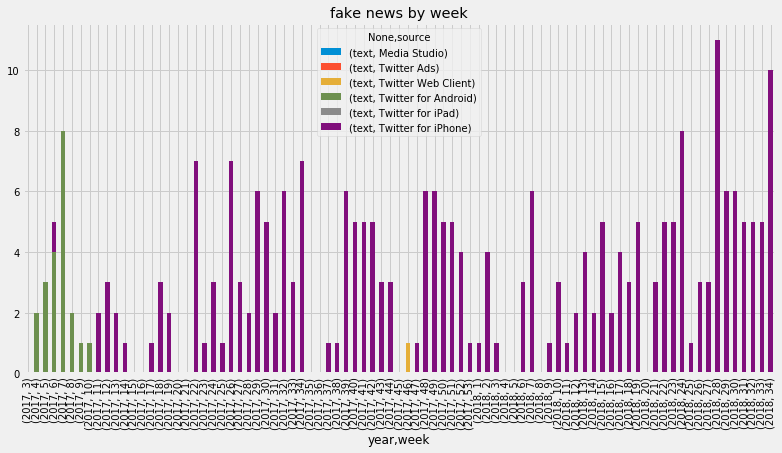

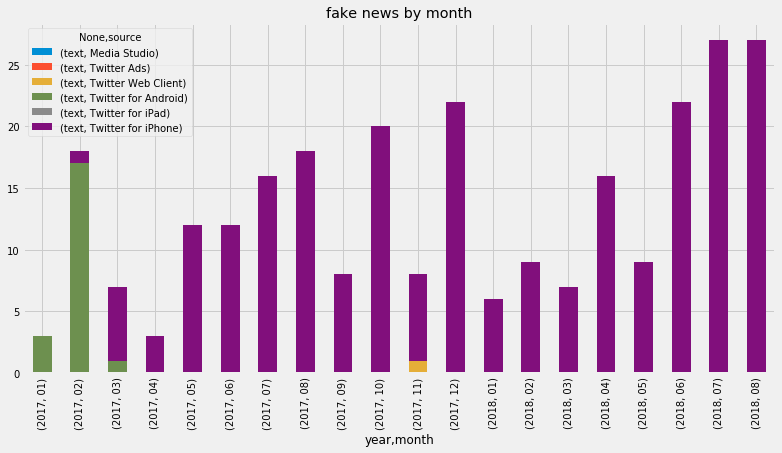

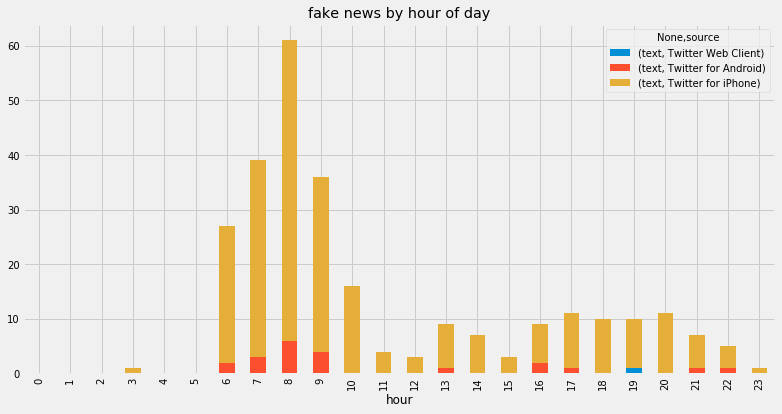

### The Tweets

[Friday, Aug 31, 2018 10:25 PM](https://twitter.com/realDonaldTrump/status/1035715271418413056): .@Rasmussen_Poll just came out at 48% approval rate despite the constant and intense Fake News. Higher than Election Day and higher than President Obama. Rasmussen was one of the most accurate Election Day polls!

[Thursday, Aug 30, 2018 9:39 AM](https://twitter.com/realDonaldTrump/status/1035159956507566080): I am very excited about the person who will be taking the place of Don McGahn as White House Counsel! I liked Don, but he was NOT responsible for me not firing Bob Mueller or Jeff Sessions. So much Fake Reporting and Fake News!

[Thursday, Aug 30, 2018 8:12 AM](https://twitter.com/realDonaldTrump/status/1035138155794575360): I am very excited about the person who will be taking the place of Don McGahn as White House Councel! I liked Don, but he was NOT responsible for me not firing Bob Mueller or Jeff Sessions. So much Fake Reporting and Fake News!

[Thursday, Aug 30, 2018 7:44 AM](https://twitter.com/realDonaldTrump/status/1035131133997068288): Ivanka Trump &amp; Jared Kushner had NOTHING to do with the so called “pushing out” of Don McGahn.The Fake News Media has it, purposely,so wrong! They love to portray chaos in the White House when they know that chaos doesn’t exist-just a “smooth running machine” with changing parts!

[Wednesday, Aug 29, 2018 8:44 PM](https://twitter.com/realDonaldTrump/status/1034965029676883970): “Lanny Davis admits being anonymous source in CNN Report.” @BretBaier  Oh well, so much for CNN saying it wasn’t Lanny. No wonder their ratings are so low, it’s FAKE NEWS!

[Wednesday, Aug 29, 2018 6:43 PM](https://twitter.com/realDonaldTrump/status/1034934675972792320): CNN is being torn apart from within based on their being caught in a major lie and refusing to admit the mistake. Sloppy @carlbernstein, a man who lives in the past and thinks like a degenerate fool, making up story after story, is being laughed at all over the country! Fake News

[Wednesday, Aug 29, 2018 8:40 AM](https://twitter.com/realDonaldTrump/status/1034782741714399232): “Anonymous Sources are really starting to BURN the media.” @FoxNews The fact is that many anonymous sources don’t even exist. They are fiction made up by the Fake News reporters. Look at the lie that Fake CNN is now in. They got caught red handed! Enemy of the People!

[Tuesday, Aug 28, 2018 11:02 AM](https://twitter.com/realDonaldTrump/status/1034456273306243076): Google search results for “Trump News” shows only the viewing/reporting of Fake News Media. In other words, they have it RIGGED, for me &amp; others, so that almost all stories &amp; news is BAD. Fake CNN is prominent. Republican/Conservative &amp; Fair Media is shut out. Illegal? 96% of....

[Monday, Aug 27, 2018 9:37 AM](https://twitter.com/realDonaldTrump/status/1034072454086447104): The Fake News Media worked hard to get Tiger Woods to say something that he didn’t want to say. Tiger wouldn’t play the game - he is very smart. More importantly, he is playing great golf again!

[Sunday, Aug 26, 2018 8:39 PM](https://twitter.com/realDonaldTrump/status/1033876658439245825): Over 90% approval rating for your all time favorite (I hope) President within the Republican Party and 52% overall. This despite all of the made up stories by the Fake News Media trying endlessly to make me look as bad and evil as possible. Look at the real villains please!

[Saturday, Aug 25, 2018 8:16 AM](https://twitter.com/realDonaldTrump/status/1033327353227882496): Michaels Cohen’s attorney clarified the record, saying his client does not know if President Trump knew about the Trump Tower meeting (out of which came nothing!). The answer is that I did NOT know about the meeting. Just another phony story by the Fake News Media!

[Friday, Aug 24, 2018 7:34 AM](https://twitter.com/realDonaldTrump/status/1032954224529817600): Social Media Giants are silencing millions of people. Can’t do this even if it means we must continue to hear Fake News like CNN, whose ratings have suffered gravely. People have to figure out what is real, and what is not, without censorship!

[Tuesday, Aug 21, 2018 7:10 AM](https://twitter.com/realDonaldTrump/status/1031861173149413376): Fake News, of which there is soooo much (this time the very tired New Yorker) falsely reported that I was going to take the extraordinary step of denying Intelligence Briefings to President Obama. Never discussed or thought of!

[Sunday, Aug 19, 2018 8:14 AM](https://twitter.com/realDonaldTrump/status/1031152483949838336): Some members of the media are very Angry at the Fake Story in the New York Times. They actually called to complain and apologize - a big step forward. From the day I announced, the Times has been Fake News, and with their disgusting new Board Member, it will only get worse!

[Sunday, Aug 19, 2018 8:06 AM](https://twitter.com/realDonaldTrump/status/1031150465759633408): The Failing New York Times wrote a story that made it seem like the White House Councel had TURNED on the President, when in fact it is just the opposite - &amp; the two Fake reporters knew this. This is why the Fake News Media has become the Enemy of the People. So bad for America!

[Saturday, Aug 18, 2018 7:32 AM](https://twitter.com/realDonaldTrump/status/1030779412973846529): .....Censorship is a very dangerous thing &amp; absolutely impossible to police. If you are weeding out Fake News, there is nothing so Fake as CNN &amp; MSNBC, &amp; yet I do not ask that their sick behavior be removed. I get used to it and watch with a grain of salt, or don’t watch at all..

[Thursday, Aug 16, 2018 10:10 AM](https://twitter.com/realDonaldTrump/status/1030094399362007040): There is nothing that I would want more for our Country than true FREEDOM OF THE PRESS. The fact is that the Press is FREE to write and say anything it wants, but much of what it says is FAKE NEWS, pushing a political agenda or just plain trying to hurt people. HONESTY WINS!

[Thursday, Aug 16, 2018 8:50 AM](https://twitter.com/realDonaldTrump/status/1030074380397752320): THE FAKE NEWS MEDIA IS THE OPPOSITION PARTY. It is very bad for our Great Country....BUT WE ARE WINNING!

[Monday, Aug 13, 2018 9:57 PM](https://twitter.com/realDonaldTrump/status/1029185314752000007): ....such wonderful and powerful things about me - a true Champion of Civil Rights - until she got fired. Omarosa had Zero credibility with the Media (they didn’t want interviews) when she worked in the White House. Now that she says bad about me, they will talk to her. Fake News!

[Monday, Aug 13, 2018 10:21 AM](https://twitter.com/realDonaldTrump/status/1029010124881453056): While I know it’s “not presidential” to take on a lowlife like Omarosa, and while I would rather not be doing so, this is a modern day form of communication and I know the Fake News Media will be working overtime to make even Wacky Omarosa look legitimate as possible. Sorry!

[Saturday, Aug 11, 2018 2:28 PM](https://twitter.com/realDonaldTrump/status/1028347518822825984): The big story that the Fake News Media refuses to report is lowlife Christopher Steele’s many meetings with Deputy A.G. Bruce Ohr and his beautiful wife, Nelly. It was Fusion GPS that hired Steele to write the phony &amp; discredited Dossier, paid for by Crooked Hillary &amp; the DNC....

[Wednesday, Aug 8, 2018 11:14 AM](https://twitter.com/realDonaldTrump/status/1027211440225243137): The Republicans have now won 8 out of 9 House Seats, yet if you listen to the Fake News Media you would think we are being clobbered. Why can’t they play it straight, so unfair to the Republican Party and in particular, your favorite President!

[Sunday, Aug 5, 2018 8:49 AM](https://twitter.com/realDonaldTrump/status/1026087766071947265): Too bad a large portion of the Media refuses to report the lies and corruption having to do with the Rigged Witch Hunt - but that is why we call them FAKE NEWS!

[Sunday, Aug 5, 2018 8:35 AM](https://twitter.com/realDonaldTrump/status/1026084333315153924): Fake News reporting, a complete fabrication, that I am concerned about the meeting my wonderful son, Donald, had in Trump Tower. This was a meeting to get information on an opponent, totally legal and done all the time in politics - and it went nowhere. I did not know about it!

[Sunday, Aug 5, 2018 7:38 AM](https://twitter.com/realDonaldTrump/status/1026069857589227520): The Fake News hates me saying that they are the Enemy of the People only because they know it’s TRUE. I am providing a great service by explaining this to the American People. They purposely cause great division &amp; distrust. They can also cause War! They are very dangerous &amp; sick!

[Thursday, Aug 2, 2018 4:24 PM](https://twitter.com/realDonaldTrump/status/1025115155632455680): They asked my daughter Ivanka whether or not the media is the enemy of the people. She correctly said no. It is the FAKE NEWS, which is a large percentage of the media, that is the enemy of the people!

[Thursday, Aug 2, 2018 7:04 AM](https://twitter.com/realDonaldTrump/status/1024974107337781248): Wow, @foxandfriends is blowing away the competition in the morning ratings. Morning Joe is a dead show with very few people watching and sadly, Fake News CNN is also doing poorly. Too much hate and inaccurately reported stories - too predictable!

[Tuesday, Jul 31, 2018 9:34 AM](https://twitter.com/realDonaldTrump/status/1024287257975566338): The Fake News Media is going CRAZY! They are totally unhinged and in many ways, after witnessing first hand the damage they do to so many innocent and decent people, I enjoy watching. In 7 years, when I am no longer in office, their ratings will dry up and they will be gone!

[Sunday, Jul 29, 2018 8:30 AM](https://twitter.com/realDonaldTrump/status/1023546197129224192): Had a very good and interesting meeting at the White House with A.G. Sulzberger, Publisher of the New York Times. Spent much time talking about the vast amounts of Fake News being put out by the media &amp; how that Fake News has morphed into phrase, “Enemy of the People.” Sad!

[Sunday, Jul 29, 2018 7:59 AM](https://twitter.com/realDonaldTrump/status/1023538486081662976): RT @realDonaldTrump: Democrats, who want Open Borders and care little about Crime, are incompetent, but they have the Fake News Media almos…

[Sunday, Jul 29, 2018 7:52 AM](https://twitter.com/realDonaldTrump/status/1023536822901776384): Do you think the Fake News Media will ever report on this tweet from Michael? https://t.co/kXLCKZO5Fr

[Friday, Jul 27, 2018 6:45 PM](https://twitter.com/realDonaldTrump/status/1022976410745495552): Democrats, who want Open Borders and care little about Crime, are incompetent, but they have the Fake News Media almost totally on their side!

[Friday, Jul 27, 2018 7:38 AM](https://twitter.com/realDonaldTrump/status/1022808452677160960): ....,the only Collusion with Russia was with the Democrats, so now they are looking at my Tweets (along with 53 million other people) - the rigged Witch Hunt continues! How stupid and unfair to our Country....And so the Fake News doesn’t waste my time with dumb questions, NO,....

[Tuesday, Jul 24, 2018 8:39 PM](https://twitter.com/realDonaldTrump/status/1021917767467982854): So sad and unfair that the FCC wouldn’t approve the Sinclair Broadcast merger with Tribune. This would have been a great and much needed Conservative voice for and of the People. Liberal Fake News NBC and Comcast gets approved, much bigger, but not Sinclair. Disgraceful!

[Monday, Jul 23, 2018 9:06 AM](https://twitter.com/realDonaldTrump/status/1021380986452545537): A Rocket has not been launched by North Korea in 9 months. Likewise, no Nuclear Tests. Japan is happy, all of Asia is happy. But the Fake News is saying, without ever asking me (always anonymous sources), that I am angry because it is not going fast enough. Wrong, very happy!

[Monday, Jul 23, 2018 8:25 AM](https://twitter.com/realDonaldTrump/status/1021370601863294977): When you hear the Fake News talking negatively about my meeting with President Putin, and all that I gave up, remember, I gave up NOTHING, we merely talked about future benefits for both countries. Also, we got along very well, which is a good thing, except for the Corrupt Media!

[Sunday, Jul 22, 2018 9:15 AM](https://twitter.com/realDonaldTrump/status/1021020863733420032): I had a GREAT meeting with Putin and the Fake News used every bit of their energy to try and disparage it. So bad for our country!

[Friday, Jul 20, 2018 5:50 PM](https://twitter.com/realDonaldTrump/status/1020425741664751616): I got severely criticized by the Fake News Media for being too nice to President Putin. In the Old Days they would call it Diplomacy. If I was loud &amp; vicious, I would have been criticized for being too tough. Remember when they said I was too tough with Chairman Kim? Hypocrites!

[Friday, Jul 20, 2018 10:39 AM](https://twitter.com/realDonaldTrump/status/1020317159828992000): RT @realDonaldTrump: The Summit with Russia was a great success, except with the real enemy of the people, the Fake News Media. I look forw…

[Friday, Jul 20, 2018 10:35 AM](https://twitter.com/realDonaldTrump/status/1020316392548196354): RT @realDonaldTrump: Will the Dems and Fake News ever learn? This is classic! https://t.co/kSX3ROI4QG

[Thursday, Jul 19, 2018 2:14 PM](https://twitter.com/realDonaldTrump/status/1020008975922810883): Will the Dems and Fake News ever learn? This is classic! https://t.co/kSX3ROI4QG

[Thursday, Jul 19, 2018 9:24 AM](https://twitter.com/realDonaldTrump/status/1019936133147516929): The Summit with Russia was a great success, except with the real enemy of the people, the Fake News Media. I look forward to our second meeting so that we can start implementing some of the many things discussed, including stopping terrorism, security for Israel, nuclear........

[Thursday, Jul 19, 2018 7:13 AM](https://twitter.com/realDonaldTrump/status/1019903123312308224): “Trump recognized Russian Meddling MANY TIMES.” Thank you to @foxandfriends and @FoxNews for actually showing the clips. The Fake News wants no part of that narrative! Too bad they don’t want to focus on all of the ECONOMIC and JOBS records being set.

[Thursday, Jul 19, 2018 6:59 AM](https://twitter.com/realDonaldTrump/status/1019899507910283264): The Fake News Media wants so badly to see a major confrontation with Russia, even a confrontation that could lead to war. They are pushing so recklessly hard and hate the fact that I’ll probably have a good relationship with Putin. We are doing MUCH better than any other country!

[Thursday, Jul 19, 2018 6:37 AM](https://twitter.com/realDonaldTrump/status/1019894101116948480): The Fake News Media is going Crazy! They make up stories without any backup, sources or proof. Many of the stories written about me, and the good people surrounding me, are total fiction. Problem is, when you complain you just give them more publicity. But I’ll complain anyway!

[Tuesday, Jul 17, 2018 8:21 PM](https://twitter.com/realDonaldTrump/status/1019376680572456960): The meeting between President Putin and myself was a great success, except in the Fake News Media!

[Tuesday, Jul 17, 2018 10:22 AM](https://twitter.com/realDonaldTrump/status/1019225830298456066): While I had a great meeting with NATO, raising vast amounts of money, I had an even better meeting with Vladimir Putin of Russia. Sadly, it is not being reported that way - the Fake News is going Crazy!

[Sunday, Jul 15, 2018 12:11 PM](https://twitter.com/realDonaldTrump/status/1018528420093878272): There hasn’t been a missile or rocket fired in 9 months in North Korea, there have been no nuclear tests and we got back our hostages. Who knows how it will all turn out in the end, but why isn’t the Fake News talking about these wonderful facts? Because it is FAKE NEWS!

[Saturday, Jul 14, 2018 2:17 PM](https://twitter.com/realDonaldTrump/status/1018197842559725569): These Russian individuals did their work during the Obama years. Why didn’t Obama do something about it?  Because he thought Crooked Hillary Clinton would win, that’s why. Had nothing to do with the Trump Administration, but Fake News doesn’t want to report the truth, as usual!

[Saturday, Jul 14, 2018 7:24 AM](https://twitter.com/realDonaldTrump/status/1018093807060045824): So funny! I just checked out Fake News CNN, for the first time in a long time (they are dying in the ratings), to see if they covered my takedown yesterday of Jim Acosta (actually a nice guy). They didn’t! But they did say I already lost in my meeting with Putin. Fake News......

[Monday, Jul 9, 2018 1:04 PM](https://twitter.com/realDonaldTrump/status/1016367395294908421): The failing NY Times Fake News story today about breast feeding must be called out. The U.S. strongly supports breast feeding but we don’t believe women should be denied access to formula. Many women need this option because of malnutrition and poverty.

[Tuesday, Jul 3, 2018 7:13 PM](https://twitter.com/realDonaldTrump/status/1014286054805987330): After having written many best selling books, and somewhat priding myself on my ability to write, it should be noted that the Fake News constantly likes to pore over my tweets looking for a mistake. I capitalize certain words only for emphasis, not b/c they should be capitalized!

[Tuesday, Jul 3, 2018 5:19 PM](https://twitter.com/realDonaldTrump/status/1014257237945176071): After having written many best selling books, and somewhat priding myself on my ability to write, it should be noted that the Fake News constantly likes to pour over my tweets looking for a mistake. I capitalize certain words only for emphasis, not b/c they should be capitalized!

[Tuesday, Jul 3, 2018 7:16 AM](https://twitter.com/realDonaldTrump/status/1014105549624037377): Many good conversations with North Korea-it is going well! In the meantime, no Rocket Launches or Nuclear Testing in 8 months. All of Asia is thrilled. Only the Opposition Party, which includes the Fake News, is complaining. If not for me, we would now be at War with North Korea!

[Monday, Jun 25, 2018 8:36 AM](https://twitter.com/realDonaldTrump/status/1011226622324887556): Such a difference in the media coverage of the same immigration policies between the Obama Administration and ours. Actually, we have done a far better job in that our facilities are cleaner and better run than were the facilities under Obama. Fake News is working overtime!

[Thursday, Jun 21, 2018 5:51 PM](https://twitter.com/realDonaldTrump/status/1009916650622251009): “I REALLY DON’T CARE, DO U?” written on the back of Melania’s jacket, refers to the Fake News Media. Melania has learned how dishonest they are, and she truly no longer cares!

[Wednesday, Jun 20, 2018 10:00 AM](https://twitter.com/realDonaldTrump/status/1009435777992884227): “FBI texts have revealed anti-Trump Bias.” @FoxNews  Big News, but the Fake News doesn’t want to cover. Total corruption - the Witch Hunt has turned out to be a scam! At some point soon the Mainstream Media will have to cover correctly, too big a story!

[Wednesday, Jun 20, 2018 8:25 AM](https://twitter.com/realDonaldTrump/status/1009411866475532288): The Fake News is not mentioning the safety and security of our Country when talking about illegal immigration. Our immigration laws are the weakest and worst anywhere in the world, and the Dems will do anything not to change them &amp; to obstruct-want open borders which means crime!

[Monday, Jun 18, 2018 10:57 AM](https://twitter.com/realDonaldTrump/status/1008725438972211200): If President Obama (who got nowhere with North Korea and would have had to go to war with many millions of people being killed) had gotten along with North Korea and made the initial steps toward a deal that I have, the Fake News would have named him a national hero!

[Sunday, Jun 17, 2018 8:25 PM](https://twitter.com/realDonaldTrump/status/1008506045373845504): Why was the FBI giving so much information to the Fake News Media. They are not supposed to be doing that, and knowing the enemy of the people Fake News, they put their own spin on it - truth doesn’t matter to them!

[Sunday, Jun 17, 2018 9:26 AM](https://twitter.com/realDonaldTrump/status/1008340100877570048): Washington Post employees want to go on strike because Bezos isn’t paying them enough. I think a really long strike would be a great idea. Employees would get more money and we would get rid of Fake News for an extended period of time! Is @WaPo a registered lobbyist?

[Sunday, Jun 17, 2018 8:40 AM](https://twitter.com/realDonaldTrump/status/1008328413210398720): Funny how the Fake News, in a coordinated effort with each other, likes to say I gave sooo much to North Korea because I “met.” That’s because that’s all they have to disparage! We got so much for peace in the world, &amp; more is being added in finals. Even got our hostages/remains!

[Sunday, Jun 17, 2018 7:58 AM](https://twitter.com/realDonaldTrump/status/1008317842264088576): Please clear up the Fake News! https://t.co/3VbIKbmKwP

[Friday, Jun 15, 2018 6:23 PM](https://twitter.com/realDonaldTrump/status/1007750530976927744): The Fake News Media said that I did not get along with other Leaders at the #G7Summit in Canada. They are once again, WRONG! https://t.co/I6eEKEZV6z

[Friday, Jun 15, 2018 6:03 PM](https://twitter.com/realDonaldTrump/status/1007745343306584064): I have a great relationship with Angela Merkel of Germany, but the Fake News Media only shows the bad photos (implying anger) of negotiating an agreement - where I am asking for things that no other American President would ask for! https://t.co/Ib97nN5HZt

[Friday, Jun 15, 2018 1:49 PM](https://twitter.com/realDonaldTrump/status/1007681553676283904): I’ve had to beat 17 very talented people including the Bush Dynasty, then I had to beat the Clinton Dynasty, and now I have to beat a phony Witch Hunt and all of the dishonest people covered in the IG Report...and never forget the Fake News Media. It never ends!

[Thursday, Jun 14, 2018 11:08 AM](https://twitter.com/realDonaldTrump/status/1007278701996802048): So, the Democrats make up a phony crime, Collusion with the Russians, pay a fortune to make the crime sound real, illegally leak (Comey) classified information so that a Special Councel will be appointed, and then Collude to make this pile of garbage take on life in Fake News!

[Wednesday, Jun 13, 2018 9:30 AM](https://twitter.com/realDonaldTrump/status/1006891643985854464): So funny to watch the Fake News, especially NBC and CNN. They are fighting hard to downplay the deal with North Korea. 500 days ago they would have “begged” for this deal-looked like war would break out. Our Country’s biggest enemy is the Fake News so easily promulgated by fools!

[Wednesday, Jun 6, 2018 10:04 AM](https://twitter.com/realDonaldTrump/status/1004363400674234368): Many more Republican voters showed up yesterday than the Fake News thought possible. The political pundits just don’t get what is going on out there - or they do get it but refuse to report the facts! Remember, Dems are High Tax, High Crime, easy to beat!

[Wednesday, Jun 6, 2018 9:54 AM](https://twitter.com/realDonaldTrump/status/1004360833407815680): ...Four reporters spotted Melania in the White House last week walking merrily along to a meeting. They never reported the sighting because it would hurt the sick narrative that she was living in a different part of the world, was really ill, or whatever. Fake News is really bad!

[Wednesday, Jun 6, 2018 9:48 AM](https://twitter.com/realDonaldTrump/status/1004359335399641089): The Fake News Media has been so unfair, and vicious, to my wife and our great First Lady, Melania. During her recovery from surgery they reported everything from near death, to facelift, to left the W.H. (and me) for N.Y. or Virginia, to abuse. All Fake, she is doing really well!

[Wednesday, Jun 6, 2018 9:16 AM](https://twitter.com/realDonaldTrump/status/1004351340041199616): Great night for Republicans! Congratulations to John Cox on a really big number in California. He can win. Even Fake News CNN said the Trump impact was really big, much bigger than they ever thought possible. So much for the big Blue Wave, it may be a big Red Wave. Working hard!

[Monday, Jun 4, 2018 4:41 PM](https://twitter.com/realDonaldTrump/status/1003738642903420928): The Fake News Media is desperate to distract from the economy and record setting economic numbers and so they keep talking about the phony Russian Witch Hunt.

[Saturday, Jun 2, 2018 1:43 PM](https://twitter.com/realDonaldTrump/status/1002968869043097600): There was No Collusion with Russia (except by the Democrats). When will this very expensive Witch Hunt Hoax ever end? So bad for our Country. Is the Special Counsel/Justice Department leaking my lawyers letters to the Fake News Media? Should be looking at Dems corruption instead?

[Saturday, Jun 2, 2018 1:31 PM](https://twitter.com/realDonaldTrump/status/1002965829175169025): There was No Collusion with Russia (except by the Democrats). When will this very expensive Witch Hunt Hoax ever end? So bad for our Country. Is the Special Councel/Justice Department leaking my lawyers letters to the Fake News Media? Should be looking at Dems corruption instead?

[Saturday, Jun 2, 2018 12:46 PM](https://twitter.com/realDonaldTrump/status/1002954515941941249): Real @FoxNews is doing great, Fake News CNN is dead! https://t.co/1p37tPiB3v

[Friday, May 18, 2018 9:50 AM](https://twitter.com/realDonaldTrump/status/997474432443707393): Reports are there was indeed at least one FBI representative implanted, for political purposes, into my campaign for president. It took place very early on, and long before the phony Russia Hoax became a “hot” Fake News story. If true - all time biggest political scandal!

[Friday, May 18, 2018 6:51 AM](https://twitter.com/realDonaldTrump/status/997429518867591170): Fake News Media had me calling Immigrants, or Illegal Immigrants, “Animals.” Wrong! They were begrudgingly forced to withdraw their stories. I referred to MS 13 Gang Members as “Animals,” a big difference - and so true. Fake News got it purposely wrong, as usual!

[Thursday, May 17, 2018 9:52 AM](https://twitter.com/realDonaldTrump/status/997112687799697408): Despite the disgusting, illegal and unwarranted Witch Hunt, we have had the most successful first 17 month Administration in U.S. history - by far! Sorry to the Fake News Media and “Haters,” but that’s the way it is!

[Tuesday, May 15, 2018 10:08 AM](https://twitter.com/realDonaldTrump/status/996391840860471296): Can you believe that with all of the made up, unsourced stories I get from the Fake News Media, together with the  $10,000,000 Russian Witch Hunt (there is no Collusion), I now have my best Poll Numbers in a year. Much of the Media may be corrupt, but the People truly get it!

[Monday, May 14, 2018 4:46 PM](https://twitter.com/realDonaldTrump/status/996129630913482755): The so-called leaks coming out of the White House are a massive over  exaggeration put out by the Fake News Media in order to make us look as bad as possible. With that being said, leakers are traitors and cowards, and we will find out who they are!

[Friday, May 11, 2018 7:49 PM](https://twitter.com/realDonaldTrump/status/995088584221839360): Why doesn’t the Fake News Media state that the Trump Administration’s Anti-Trust Division has been, and is, opposed to the AT&amp;T purchase of Time Warner in a currently ongoing Trial. Such a disgrace in reporting!

[Wednesday, May 9, 2018 6:38 PM](https://twitter.com/realDonaldTrump/status/994345813064192012): The Failing New York Times criticized Secretary of State Pompeo for being AWOL (missing), when in fact he was flying to North Korea. Fake News, so bad!

[Wednesday, May 9, 2018 7:38 AM](https://twitter.com/realDonaldTrump/status/994179864436596736): The Fake News is working overtime. Just reported that, despite the tremendous success we are having with the economy &amp; all things else, 91% of the Network News about me is negative (Fake). Why do we work so hard in working with the media when it is corrupt? Take away credentials?

[Friday, May 4, 2018 6:45 AM](https://twitter.com/realDonaldTrump/status/992354530510721025): NBC NEWS is wrong again! They cite “sources” which are constantly wrong. Problem is, like so many others, the sources probably don’t exist, they are fabricated, fiction! NBC, my former home with the Apprentice, is now as bad as Fake News CNN. Sad!

[Monday, Apr 30, 2018 7:02 PM](https://twitter.com/realDonaldTrump/status/991090373417152515): The White House is running very smoothly despite phony Witch Hunts etc. There is great Energy and unending Stamina, both necessary to get things done. We are accomplishing the unthinkable and setting positive records while doing so! Fake News is going “bonkers!”

[Monday, Apr 30, 2018 6:49 PM](https://twitter.com/realDonaldTrump/status/991087278515769345): The Fake News is going crazy making up false stories and using only unnamed sources (who don’t exist). They are totally unhinged, and the great success of this Administration is making them do and say things that even they can’t believe they are saying. Truly bad people!

[Monday, Apr 30, 2018 8:10 AM](https://twitter.com/realDonaldTrump/status/990926480329859073): The White House Correspondents’ Dinner is DEAD as we know it. This was a total disaster and an embarrassment to our great Country and all that it stands for. FAKE NEWS is alive and well and beautifully represented on Saturday night!

[Saturday, Apr 28, 2018 8:58 AM](https://twitter.com/realDonaldTrump/status/990213619190202369): “Clapper lied about (fraudulent) Dossier leaks to CNN” @foxandfriends FoxNews  He is a lying machine who now works for Fake News CNN.

[Sunday, Apr 22, 2018 8:50 AM](https://twitter.com/realDonaldTrump/status/988037292932653056): Sleepy Eyes Chuck Todd of Fake News NBC just stated that we have given up so much in our negotiations with North Korea, and they have given up nothing. Wow, we haven’t given up anything &amp; they have agreed to denuclearization (so great for World), site closure, &amp; no more testing!

[Friday, Apr 20, 2018 4:25 PM](https://twitter.com/realDonaldTrump/status/987426984195174405): Can you believe that despite 93% bad stories from the Fake News Media (should be getting good stories), today we had just about our highest Poll Numbers, including those on Election Day? The American public is wise to the phony an dishonest press. Make America Great Again!

[Wednesday, Apr 18, 2018 6:08 AM](https://twitter.com/realDonaldTrump/status/986547093610299392): A sketch years later about a nonexistent man. A total con job, playing the Fake News Media for Fools (but they know it)! https://t.co/9Is7mHBFda

[Tuesday, Apr 17, 2018 1:59 PM](https://twitter.com/realDonaldTrump/status/986303188587425794): Rasmussen just came out at 51% Approval despite the Fake News Media. They were one of the three most accurate on Election Day. Just about the most inaccurate were CNN and ABC News/Washington Post, and they haven’t changed (get new pollsters). Much of the media is a Scam!

[Sunday, Apr 15, 2018 10:44 AM](https://twitter.com/realDonaldTrump/status/985529299905187840): Just hit 50% in the Rasmussen Poll, much higher than President Obama at same point. With all of the phony stories and Fake News, it’s hard to believe! Thank you America, we are doing Great Things.

[Sunday, Apr 15, 2018 8:19 AM](https://twitter.com/realDonaldTrump/status/985492862958698497): The Syrian raid was so perfectly carried out, with such precision, that the only way the Fake News Media could demean was by my use of the term “Mission Accomplished.” I knew they would seize on this but felt it is such a great Military term, it should be brought back. Use often!

[Thursday, Apr 12, 2018 6:03 AM](https://twitter.com/realDonaldTrump/status/984371491277099010): If I wanted to fire Robert Mueller in December, as reported by the Failing New York Times, I would have fired him. Just more Fake News from a biased newspaper!

[Wednesday, Apr 11, 2018 6:38 AM](https://twitter.com/realDonaldTrump/status/984017894240604161): So much Fake News about what is going on in the White House. Very calm and calculated with a big focus on open and fair trade with China, the coming North Korea meeting and, of course, the vicious gas attack in Syria. Feels great to have Bolton &amp; Larry K on board. I (we) are

[Friday, Apr 6, 2018 10:46 AM](https://twitter.com/realDonaldTrump/status/982268230306709509): Do you believe that the Fake News Media is pushing hard on a story that I am going to replace A.G. Jeff Sessions with EPA Chief Scott Pruitt, who is doing a great job but is TOTALLY under siege? Do people really believe this stuff? So much of the media is dishonest and corrupt!

[Thursday, Apr 5, 2018 9:10 AM](https://twitter.com/realDonaldTrump/status/981881669593559040): The Fake News Washington Post, Amazon’s “chief lobbyist,” has another (of many) phony headlines, “Trump Defiant As China Adds Trade Penalties.” WRONG! Should read, “Trump Defiant as U.S. Adds Trade Penalties, Will End Barriers And Massive  I.P. Theft.” Typically bad reporting!

[Tuesday, Apr 3, 2018 6:34 AM](https://twitter.com/realDonaldTrump/status/981117684489379840): The Fake News Networks, those that knowingly have a sick and biased AGENDA, are worried about the competition and quality of Sinclair Broadcast. The “Fakers” at CNN, NBC, ABC &amp; CBS have done so much dishonest reporting that they should only be allowed to get awards for fiction!

[Monday, Apr 2, 2018 9:28 AM](https://twitter.com/realDonaldTrump/status/980799183425802240): So funny to watch Fake News Networks, among the most dishonest groups of people I have ever dealt with, criticize Sinclair Broadcasting for being biased. Sinclair is far superior to CNN and even more Fake NBC, which is a total joke.

[Monday, Mar 26, 2018 8:38 AM](https://twitter.com/realDonaldTrump/status/978249938743234560): So much Fake News. Never been more voluminous or more inaccurate. But through it all, our country is doing great!

[Sunday, Mar 25, 2018 7:40 AM](https://twitter.com/realDonaldTrump/status/977872899792089088): Many lawyers and top law firms want to represent me in the Russia case...don’t believe the Fake News narrative that it is hard to find a lawyer who wants to take this on. Fame &amp; fortune will NEVER be turned down by a lawyer, though some are conflicted. Problem is that a new......

[Wednesday, Mar 21, 2018 2:56 PM](https://twitter.com/realDonaldTrump/status/976532956557737984): I called President Putin of Russia to congratulate him on his election victory (in past, Obama called him also). The Fake News Media is crazed because they wanted me to excoriate him. They are wrong! Getting along with Russia (and others) is a good thing, not a bad thing.......

[Saturday, Mar 17, 2018 1:34 PM](https://twitter.com/realDonaldTrump/status/975062797162811394): The Fake News is beside themselves that McCabe was caught, called out and fired. How many hundreds of thousands of dollars was given to wife’s campaign by Crooked H friend, Terry M, who was also under investigation? How many lies? How many leaks? Comey knew it all, and much more!

[Sunday, Mar 11, 2018 11:16 AM](https://twitter.com/realDonaldTrump/status/972853747750711296): Rasmussen and others have my approval ratings at around 50%, which is higher than Obama, and yet the political pundits love saying my approval ratings are “somewhat low.” They know they are lying when they say it. Turn off the show - FAKE NEWS!

[Sunday, Mar 11, 2018 10:02 AM](https://twitter.com/realDonaldTrump/status/972835128056664066): The Republicans are 5-0 in recent Congressional races, a point which the Fake News Media continuously fails to mention. I backed and campaigned for all of the winners. They give me credit for one. Hopefully, Rick Saccone will be another big win on Tuesday.

[Tuesday, Mar 6, 2018 7:55 AM](https://twitter.com/realDonaldTrump/status/971006379375972354): The new Fake News narrative is that there is CHAOS in the White House. Wrong! People will always come &amp; go, and I want strong dialogue before making a final decision. I still have some people that I want to change (always seeking perfection). There is no Chaos, only great Energy!

[Thursday, Feb 22, 2018 8:26 PM](https://twitter.com/realDonaldTrump/status/966846679784837120): “School shooting survivor says he quit @CNN Town Hall after refusing scripted question.” @TuckerCarlson. Just like so much of CNN, Fake News. That’s why their ratings are so bad! MSNBC may be worse.

[Thursday, Feb 22, 2018 7:26 AM](https://twitter.com/realDonaldTrump/status/966650397002813440): I never said “give teachers guns” like was stated on Fake News @CNN &amp; @NBC. What I said was to look at the possibility of giving “concealed guns to gun adept teachers with military or special training experience - only the best. 20% of teachers, a lot, would now be able to

[Tuesday, Feb 20, 2018 8:08 PM](https://twitter.com/realDonaldTrump/status/966117265426001920): Bad ratings @CNN &amp; @MSNBC got scammed when they covered the anti-Trump Russia rally wall-to-wall. They probably knew it was Fake News but, because it was a rally against me, they pushed it hard anyway. Two really dishonest newscasters, but the public is wise!

[Tuesday, Feb 20, 2018 10:16 AM](https://twitter.com/realDonaldTrump/status/965968309358333952): A woman I don’t know and, to the best of my knowledge, never met, is on the FRONT PAGE of the Fake News Washington Post saying I kissed her (for two minutes yet) in the lobby of Trump Tower 12 years ago. Never happened! Who would do this in a public space with live security......

[Tuesday, Feb 20, 2018 8:38 AM](https://twitter.com/realDonaldTrump/status/965943827931549696): I have been much tougher on Russia than Obama, just look at the facts. Total Fake News!

[Sunday, Feb 18, 2018 8:46 AM](https://twitter.com/realDonaldTrump/status/965221024496279552): The Fake News of big ratings loser CNN. https://t.co/rYsv90cnvs

[Saturday, Feb 17, 2018 3:11 PM](https://twitter.com/realDonaldTrump/status/964955496137535488): The Fake News Media never fails. Hard to ignore this fact from the Vice President of Facebook Ads, Rob Goldman! https://t.co/XGC7ynZwYJ

[Saturday, Feb 17, 2018 2:46 PM](https://twitter.com/realDonaldTrump/status/964949269374529538): Funny how the Fake News Media doesn’t want to say that the Russian group was formed in 2014, long before my run for President. Maybe they knew I was going to run even though I didn’t know!

[Sunday, Feb 11, 2018 1:21 PM](https://twitter.com/realDonaldTrump/status/962753552824365056): So many positive things going on for the U.S.A. and the Fake News Media just doesn’t want to go there. Same negative stories over and over again! No wonder the People no longer trust the media, whose approval ratings are correctly at their lowest levels in history!    #MAGA

[Tuesday, Jan 23, 2018 6:31 AM](https://twitter.com/realDonaldTrump/status/955764970590961665): Even Crazy Jim Acosta of Fake News CNN agrees: “Trump World and WH sources dancing in end zone: Trump wins again...Schumer and Dems caved...gambled and lost.” Thank you for your honesty Jim!

[Wednesday, Jan 17, 2018 8:00 PM](https://twitter.com/realDonaldTrump/status/953794085751574534): And the FAKE NEWS winners are...
https://t.co/59G6x2f7fD

[Tuesday, Jan 16, 2018 9:19 AM](https://twitter.com/realDonaldTrump/status/953270558573154305): Do you notice the Fake News Mainstream Media never likes covering the great and record setting economic news, but rather talks about anything negative or that can be turned into the negative. The Russian Collusion Hoax is dead, except as it pertains to the Dems. Public gets it!

[Sunday, Jan 14, 2018 8:04 AM](https://twitter.com/realDonaldTrump/status/952526791658360833): RT @realDonaldTrump: So much Fake News is being reported. They don’t even try to get it right, or correct it when they are wrong. They prom…

[Sunday, Jan 14, 2018 8:01 AM](https://twitter.com/realDonaldTrump/status/952526145064505345): ...and they knew exactly what I said and meant. They just wanted a story. FAKE NEWS!

[Saturday, Jan 13, 2018 5:08 PM](https://twitter.com/realDonaldTrump/status/952301373479104512): So much Fake News is being reported. They don’t even try to get it right, or correct it when they are wrong. They promote the Fake Book of a mentally deranged author, who knowingly writes false information. The Mainstream Media is crazed that WE won the election!

[Sunday, Dec 31, 2017 5:18 PM](https://twitter.com/realDonaldTrump/status/947592785519173637): As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!

[Saturday, Dec 30, 2017 5:36 PM](https://twitter.com/realDonaldTrump/status/947235015343202304): I use Social Media not because I like to, but because it is the only way to fight a VERY dishonest and unfair “press,” now often referred to as Fake News Media. Phony and non-existent “sources” are being used more often than ever. Many stories &amp; reports a pure fiction!

[Friday, Dec 29, 2017 7:46 AM](https://twitter.com/realDonaldTrump/status/946724075157651457): While the Fake News loves to talk about my so-called low approval rating, @foxandfriends just showed that my rating on Dec. 28, 2017, was approximately the same as President Obama on Dec. 28, 2009, which was 47%...and this despite massive negative Trump coverage &amp; Russia hoax!

[Sunday, Dec 24, 2017 3:35 PM](https://twitter.com/realDonaldTrump/status/945030174290186241): The Tax Cut/Reform Bill, including Massive Alaska Drilling and the Repeal of the highly unpopular Individual Mandate, brought it all together as to what an incredible year we had. Don’t let the Fake News convince you otherwise...and our insider Polls are strong!

[Sunday, Dec 24, 2017 8:48 AM](https://twitter.com/realDonaldTrump/status/944927689638662145): The Fake News refuses to talk about how Big and how Strong our BASE is. They show Fake Polls just like they report Fake News. Despite only negative reporting, we are doing well - nobody is going to beat us. MAKE AMERICA GREAT AGAIN!

[Saturday, Dec 23, 2017 5:44 PM](https://twitter.com/realDonaldTrump/status/944700332881440769): The Stock Market is setting record after record and unemployment is at a 17 year low. So many things accomplished by the Trump Administration, perhaps more than any other President in first year. Sadly, will never be reported correctly by the Fake News Media!

[Thursday, Dec 21, 2017 7:45 AM](https://twitter.com/realDonaldTrump/status/943824695144697857): Was @foxandfriends just named the most influential show in news? You deserve it - three great people! The many Fake News Hate Shows should study your formula for success!

[Thursday, Dec 21, 2017 7:24 AM](https://twitter.com/realDonaldTrump/status/943819430735372289): The Massive Tax Cuts, which the Fake News Media is desperate to write badly about so as to please their Democrat bosses, will soon be kicking in and will speak for themselves. Companies are already making big payments to workers. Dems want to raise taxes, hate these big Cuts!

[Wednesday, Dec 20, 2017 9:32 AM](https://twitter.com/realDonaldTrump/status/943489378462130176): The Tax Cuts are so large and so meaningful, and yet the Fake News is working overtime to follow the lead of their friends, the defeated Dems, and only demean. This is truly a case where the results will speak for themselves, starting very soon. Jobs, Jobs, Jobs!

[Tuesday, Dec 19, 2017 10:07 AM](https://twitter.com/realDonaldTrump/status/943135588496093190): A  story in the @washingtonpost that I was close to “rescinding” the nomination of Justice Gorsuch prior to confirmation is FAKE NEWS. I never even wavered and am very proud of him and the job he is doing as a Justice of the U.S. Supreme Court. The unnamed sources don’t exist!

[Wednesday, Dec 13, 2017 8:02 AM](https://twitter.com/realDonaldTrump/status/940930017365778432): Wow, more than 90% of Fake News Media coverage of me is negative, with numerous forced retractions of untrue stories. Hence my use of Social Media, the only way to get the truth out. Much of Mainstream Meadia has become a joke! @foxandfriends

[Tuesday, Dec 12, 2017 7:10 AM](https://twitter.com/realDonaldTrump/status/940554567414091776): Despite thousands of hours wasted and many millions of dollars spent, the Democrats have been unable to show any collusion with Russia - so now they are moving on to the false accusations and fabricated stories of women who I don’t know and/or have never met. FAKE NEWS!

[Monday, Dec 11, 2017 9:17 AM](https://twitter.com/realDonaldTrump/status/940223974985871360): Another false story, this time in the Failing @nytimes, that I watch 4-8 hours of television a day - Wrong!  Also, I seldom, if ever, watch CNN or MSNBC, both of which I consider Fake News. I never watch Don Lemon, who I once called the “dumbest man on television!” Bad Reporting.

[Sunday, Dec 10, 2017 4:18 PM](https://twitter.com/realDonaldTrump/status/939967625362276354): Very little discussion of all the purposely false and defamatory stories put out this week by the Fake News Media. They are out of control - correct reporting means nothing to them. Major lies written, then forced to be withdrawn after they are exposed...a stain on America!

[Sunday, Dec 10, 2017 8:30 AM](https://twitter.com/realDonaldTrump/status/939849867438034944): Things are going really well for our economy, a subject the Fake News spends as little time as possible discussing! Stock Market hit another RECORD HIGH, unemployment is now at a 17 year low and companies are coming back into the USA. Really good news, and much more to come!

[Saturday, Dec 9, 2017 6:14 PM](https://twitter.com/realDonaldTrump/status/939634404267380736): .@daveweigel of the Washington Post just admitted that his picture was a FAKE (fraud?) showing an almost empty arena last night for my speech in Pensacola when, in fact, he knew the arena was packed (as shown also on T.V.). FAKE NEWS, he should be fired.

[Saturday, Dec 9, 2017 5:01 PM](https://twitter.com/realDonaldTrump/status/939616077356642304): .@DaveWeigel @WashingtonPost put out a phony photo of an empty arena hours before I arrived @ the venue, w/ thousands of people outside, on their way in. Real photos now shown as I spoke. Packed house, many people unable to get in. Demand apology &amp; retraction from FAKE NEWS WaPo! https://t.co/XAblFGh1ob

[Saturday, Dec 9, 2017 8:21 AM](https://twitter.com/realDonaldTrump/status/939485131693322240): CNN’S slogan is CNN, THE MOST TRUSTED NAME IN NEWS. Everyone knows this is not true, that this could, in fact, be a fraud on the American Public. There are many outlets that are far more trusted than Fake News CNN. Their slogan should be CNN, THE LEAST TRUSTED NAME IN NEWS!

[Saturday, Dec 9, 2017 8:02 AM](https://twitter.com/realDonaldTrump/status/939480342779580416): Fake News CNN made a vicious and purposeful mistake yesterday. They were caught red handed, just like lonely Brian Ross at ABC News (who should be immediately fired for his “mistake”). Watch to see if @CNN fires those responsible, or was it just gross incompetence?

[Sunday, Dec 3, 2017 6:15 AM](https://twitter.com/realDonaldTrump/status/937279001684598784): I never asked Comey to stop investigating Flynn. Just more Fake News covering another Comey lie!

[Saturday, Dec 2, 2017 9:22 PM](https://twitter.com/realDonaldTrump/status/937145025359761408): Congratulations to @ABC News for suspending Brian Ross for his horrendously inaccurate and dishonest report on the Russia, Russia, Russia Witch Hunt. More Networks and “papers” should do the same with their Fake News!

[Friday, Dec 1, 2017 3:08 PM](https://twitter.com/realDonaldTrump/status/936688444046266368): The media has been speculating that I fired Rex Tillerson or that he would be leaving soon - FAKE NEWS! He’s not leaving and while we disagree on certain subjects, (I call the final shots) we work well together and America is highly respected again!
https://t.co/FrqiPLFJ1E

[Wednesday, Nov 29, 2017 9:14 AM](https://twitter.com/realDonaldTrump/status/935874566701842434): So now that Matt Lauer is gone when will the Fake News practitioners at NBC be terminating the contract of Phil Griffin? And will they terminate low ratings Joe Scarborough based on the “unsolved mystery” that took place in Florida years ago? Investigate!

[Wednesday, Nov 29, 2017 8:58 AM](https://twitter.com/realDonaldTrump/status/935870484146683904): So now tha Matt Lauer is gone when will the Fake News practitioners at NBC be terminating the contract of Phil Griffin? And will they terminate low ratings Joe Scarborough based on the “unsolved mystery” that took place in Florida years ago? Investigate!

[Wednesday, Nov 29, 2017 7:16 AM](https://twitter.com/realDonaldTrump/status/935844881825763328): Wow, Matt Lauer was just fired from NBC for “inappropriate sexual behavior in the workplace.” But when will the top executives at NBC &amp; Comcast be fired for putting out so much Fake News. Check out Andy Lack’s past!

[Wednesday, Nov 29, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/935838073618870272): Great, and we should boycott Fake News CNN. Dealing with them is a total waste of time! https://t.co/8zJ3j7g5el

[Monday, Nov 27, 2017 9:04 AM](https://twitter.com/realDonaldTrump/status/935147410472480769): We should have a contest as to which of the Networks, plus CNN and not including Fox, is the most dishonest, corrupt and/or distorted in its political coverage of your favorite President (me). They are all bad. Winner to receive the FAKE NEWS TROPHY!

[Saturday, Nov 25, 2017 6:25 PM](https://twitter.com/realDonaldTrump/status/934563828834164739): Wow, even I didn’t realize we did so much. Wish the Fake News would report! Thank you. https://t.co/ApVbu2b0Jd

[Saturday, Nov 11, 2017 7:43 PM](https://twitter.com/realDonaldTrump/status/929509950811881472): Does the Fake News Media remember when Crooked Hillary Clinton, as Secretary of State, was begging Russia to be our friend with the misspelled reset button? Obama tried also, but he had zero chemistry with Putin.

[Friday, Nov 3, 2017 12:09 PM](https://twitter.com/realDonaldTrump/status/926481563214376961): The rigged Dem Primary, one of the biggest political stories in years, got ZERO coverage on Fake News Network TV last night. Disgraceful!

[Tuesday, Oct 31, 2017 10:10 AM](https://twitter.com/realDonaldTrump/status/925364408364171265): ....earth shattering. He and his brother could Drain The Swamp, which would be yet another campaign promise fulfilled. Fake News weak!

[Tuesday, Oct 31, 2017 8:09 AM](https://twitter.com/realDonaldTrump/status/925333956110757888): The Fake News is working overtime. As Paul Manaforts lawyer said, there was "no collusion" and events mentioned took place long before he...

[Saturday, Oct 28, 2017 8:28 AM](https://twitter.com/realDonaldTrump/status/924251519121346560): Just read the nice remarks by President Jimmy Carter about me and how badly I am treated by the press (Fake News). Thank you Mr. President!

[Wednesday, Oct 25, 2017 7:21 AM](https://twitter.com/realDonaldTrump/status/923147501418446849): "Clinton campaign &amp; DNC paid for research that led to the anti-Trump Fake News Dossier. The victim here is the President." @FoxNews

[Sunday, Oct 22, 2017 8:08 AM](https://twitter.com/realDonaldTrump/status/922072236592435200): It is finally sinking through. 46% OF PEOPLE BELIEVE MAJOR NATIONAL NEWS ORGS FABRICATE STORIES ABOUT ME. FAKE NEWS, even worse! Lost cred.

[Saturday, Oct 21, 2017 4:06 PM](https://twitter.com/realDonaldTrump/status/921829947093733376): Keep hearing about "tiny" amount of money spent on Facebook ads. What about the billions of dollars of Fake News on CNN, ABC, NBC &amp; CBS?

[Saturday, Oct 21, 2017 9:14 AM](https://twitter.com/realDonaldTrump/status/921726400922619904): Stock Market hits another all time high on Friday. 5.3 trillion dollars up since Election. Fake News doesn't spent much time on this!

[Saturday, Oct 21, 2017 8:07 AM](https://twitter.com/realDonaldTrump/status/921709468055896064): I hope the Fake News Media keeps talking about Wacky Congresswoman Wilson in that she, as a representative, is killing the Democrat Party!

[Thursday, Oct 19, 2017 10:53 PM](https://twitter.com/realDonaldTrump/status/921207772233990144): The Fake News is going crazy with wacky Congresswoman Wilson(D), who was SECRETLY on a very personal call, and gave a total lie on content!

[Tuesday, Oct 17, 2017 5:51 PM](https://twitter.com/realDonaldTrump/status/920406959320371200): So much Fake News being put in dying magazines and newspapers. Only place worse may be @NBCNews, @CBSNews, @ABC and @CNN. Fiction writers!

[Friday, Oct 13, 2017 7:10 AM](https://twitter.com/realDonaldTrump/status/918796079243677696): Sadly, they and others are Fake News, and the public is just beginning to figure it out! https://t.co/8B8AyA7V1s

[Thursday, Oct 12, 2017 8:45 AM](https://twitter.com/realDonaldTrump/status/918457595618365441): The Fake News Is going all out in order to demean and denigrate! Such hatred!

[Wednesday, Oct 11, 2017 9:55 AM](https://twitter.com/realDonaldTrump/status/918112884630093825): With all of the Fake News coming out of NBC and the Networks, at what point is it appropriate to challenge their License? Bad for country!

[Wednesday, Oct 11, 2017 6:31 AM](https://twitter.com/realDonaldTrump/status/918061437750267904): It would be really nice if the Fake News Media would report the virtually unprecedented Stock Market growth since the election.Need tax cuts

[Tuesday, Oct 10, 2017 9:15 PM](https://twitter.com/realDonaldTrump/status/917921548677328896): The Fake News is at it again, this time trying to hurt one of the finest people I know, General John Kelly, by saying he will soon be.....

[Thursday, Oct 5, 2017 7:50 AM](https://twitter.com/realDonaldTrump/status/915907150333009920): Rex Tillerson never threatened to resign. This is Fake News put out by @NBCNews. Low news and reporting standards. No verification from me.

[Thursday, Oct 5, 2017 6:59 AM](https://twitter.com/realDonaldTrump/status/915894251967385600): Why Isn't the Senate Intel Committee looking into the Fake News Networks in OUR country to see why so much of our news is just made up-FAKE!

[Thursday, Oct 5, 2017 6:30 AM](https://twitter.com/realDonaldTrump/status/915886953194770433): RT @FoxNews: Geraldo Blasts 'Fake News' Reports About Trump's Visit to Puerto Rico https://t.co/9jO0D3BMvE

[Wednesday, Oct 4, 2017 7:29 AM](https://twitter.com/realDonaldTrump/status/915539424406114304): Wow, so many Fake News stories today. No matter what I do or say, they will not write or speak truth. The Fake News Media is out of control!

[Sunday, Oct 1, 2017 8:22 AM](https://twitter.com/realDonaldTrump/status/914465475777695744): We have done a great job with the almost impossible situation in Puerto Rico. Outside of the Fake News or politically motivated ingrates,...

[Saturday, Sep 30, 2017 7:24 PM](https://twitter.com/realDonaldTrump/status/914269704440737792): In analyzing the Alabama Primary race,FAKE NEWS always fails to mention that the candidate I endorsed went up MANY points after endorsement!

[Saturday, Sep 30, 2017 7:16 PM](https://twitter.com/realDonaldTrump/status/914267744345972737): In analyzing the Alabama Primary race, Fake News always fails to mention that the candidate I endorsed went up MANY points after Election!

[Saturday, Sep 30, 2017 2:04 PM](https://twitter.com/realDonaldTrump/status/914189344533024768): Despite the Fake News Media in conjunction with the Dems, an amazing job is being done in Puerto Rico. Great people!

[Saturday, Sep 30, 2017 8:07 AM](https://twitter.com/realDonaldTrump/status/914099295963553792): The Fake News Networks are working overtime in Puerto Rico doing their best to take the spirit away from our soldiers and first R's. Shame!

[Saturday, Sep 30, 2017 7:48 AM](https://twitter.com/realDonaldTrump/status/914094625488502784): Fake News CNN and NBC are going out of their way to disparage our great First Responders as a way to "get Trump." Not fair to FR or effort!

[Wednesday, Sep 27, 2017 9:36 AM](https://twitter.com/realDonaldTrump/status/913034591879024640): Facebook was always anti-Trump.The Networks were always anti-Trump hence,Fake News, @nytimes(apologized) &amp; @WaPo were anti-Trump. Collusion?

[Friday, Sep 22, 2017 7:26 AM](https://twitter.com/realDonaldTrump/status/911189860769255424): The greatest influence over our election was the Fake News Media "screaming" for Crooked Hillary Clinton. Next, she was a bad candidate!

[Tuesday, Sep 12, 2017 8:56 AM](https://twitter.com/realDonaldTrump/status/907588803161939968): Fascinating to watch people writing books and major articles about me and yet they know nothing about me &amp; have zero access. #FAKE NEWS!

[Friday, Aug 25, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/901031532164468736): General John Kelly is doing a fantastic job as Chief of Staff. There is tremendous spirit and talent in the W.H. Don't believe the Fake News

[Thursday, Aug 24, 2017 9:07 AM](https://twitter.com/realDonaldTrump/status/900706146943717377): The Fake News is now complaining about my different types of back to back speeches. Well, there was Afghanistan (somber), the big Rally.....

[Thursday, Aug 24, 2017 8:41 AM](https://twitter.com/realDonaldTrump/status/900699520304066561): The Fake News is now complaining about my different types of back to back speeches. Well, their was Afghanistan (somber), the big Rally.....

[Wednesday, Aug 23, 2017 9:40 AM](https://twitter.com/realDonaldTrump/status/900352052068401154): Last night in Phoenix I read the things from my statements on Charlottesville that the Fake News Media didn't cover fairly. People got it!

[Monday, Aug 21, 2017 9:32 AM](https://twitter.com/realDonaldTrump/status/899625157421039616): Thank you, the very dishonest Fake News Media is out of control! https://t.co/8J7y900VGK

[Monday, Aug 21, 2017 9:27 AM](https://twitter.com/realDonaldTrump/status/899623926082535425): Jerry Falwell of Liberty University was fantastic on @foxandfriends. The Fake News should listen to what he had to say. Thanks Jerry!

[Sunday, Aug 20, 2017 7:22 PM](https://twitter.com/realDonaldTrump/status/899411254061694979): Heading back to Washington after working hard and watching some of the worst and most dishonest Fake News reporting I have ever seen!

[Saturday, Aug 19, 2017 1:47 PM](https://twitter.com/realDonaldTrump/status/898964640817983488): Steve Bannon will be a tough and smart new voice at @BreitbartNews...maybe even better than ever before. Fake News needs the competition!

[Thursday, Aug 17, 2017 6:32 AM](https://twitter.com/realDonaldTrump/status/898130328916824064): The public is learning (even more so) how dishonest the Fake News is. They totally misrepresent what I say about hate, bigotry etc. Shame!

[Monday, Aug 14, 2017 6:29 PM](https://twitter.com/realDonaldTrump/status/897223558073602049): Made additional remarks on Charlottesville and realize once again that the #Fake News Media will never be satisfied...truly bad people!

[Tuesday, Aug 8, 2017 2:10 PM](https://twitter.com/realDonaldTrump/status/894984126582972416): After 200 days, rarely has any Administration achieved what we have achieved..not even close! Don't believe the Fake News Suppression Polls!

[Monday, Aug 7, 2017 4:15 PM](https://twitter.com/realDonaldTrump/status/894653195112378368): The Fake News Media will not talk about the importance of the United Nations Security Council's 15-0 vote in favor of sanctions on N. Korea!

[Monday, Aug 7, 2017 7:18 AM](https://twitter.com/realDonaldTrump/status/894518002795900928): Hard to believe that with 24/7 #Fake News on CNN, ABC, NBC, CBS, NYTIMES &amp; WAPO, the Trump base is getting stronger!

[Monday, Aug 7, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/894514535062790144): ...and West Virginia. The fact is the Fake News Russian collusion story, record Stock Market, border security, military strength, jobs.....

[Monday, Aug 7, 2017 6:58 AM](https://twitter.com/realDonaldTrump/status/894512983384129536): The Trump base is far bigger &amp;  stronger than ever before (despite some phony Fake News polling). Look at rallies in Penn, Iowa, Ohio.......

[Sunday, Aug 6, 2017 9:18 PM](https://twitter.com/realDonaldTrump/status/894367017054208001): The Fake News refuses to report the success of the first 6 months: S.C., surging economy &amp; jobs,border &amp; military security,ISIS &amp; MS-13 etc.

[Wednesday, Aug 2, 2017 9:29 PM](https://twitter.com/realDonaldTrump/status/892920397162848257): I love the White House, one of the most beautiful buildings (homes) I have ever seen. But Fake News said I called it a dump - TOTALLY UNTRUE

[Tuesday, Aug 1, 2017 9:55 AM](https://twitter.com/realDonaldTrump/status/892383242535481344): Only the Fake News Media and Trump enemies want me to stop using Social Media (110 million people). Only way for me to get the truth out!

[Saturday, Jul 29, 2017 7:15 PM](https://twitter.com/realDonaldTrump/status/891437168798965761): I love reading about all of the "geniuses" who were so instrumental in my election success. Problem is, most don't exist. #Fake News! MAGA

[Thursday, Jul 27, 2017 9:45 AM](https://twitter.com/realDonaldTrump/status/890568797941362690): ...about then candidate Trump." Catherine Herridge @FoxNews. So why doesn't Fake News report this? Witch Hunt! Purposely phony reporting.

[Monday, Jul 24, 2017 10:36 PM](https://twitter.com/realDonaldTrump/status/889675644396867584): Is Fake News Washington Post being used as a lobbyist weapon against Congress to keep Politicians from looking into Amazon no-tax monopoly?

[Monday, Jul 24, 2017 10:28 PM](https://twitter.com/realDonaldTrump/status/889673743873843200): So many stories about me in the @washingtonpost are Fake News. They are as bad as ratings challenged @CNN. Lobbyist for Amazon and taxes?

[Monday, Jul 24, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/889435104841523201): Drain the Swamp should be changed to Drain the Sewer - it's actually much worse than anyone ever thought, and it begins with the Fake News!

[Saturday, Jul 22, 2017 7:35 AM](https://twitter.com/realDonaldTrump/status/888724194820857857): While all agree the U. S. President has the complete power to pardon, why think of that when only crime so far is LEAKS against us.FAKE NEWS

[Friday, Jul 21, 2017 9:46 PM](https://twitter.com/realDonaldTrump/status/888575966259314691): Sean Spicer is a wonderful person who took tremendous abuse from the Fake News Media - but his future is bright!

[Tuesday, Jul 18, 2017 8:59 PM](https://twitter.com/realDonaldTrump/status/887477071160762369): The Fake News is becoming more and more dishonest! Even a dinner arranged for top 20 leaders in Germany is made to look sinister!

[Tuesday, Jul 18, 2017 8:53 PM](https://twitter.com/realDonaldTrump/status/887475373981696000): Fake News story of secret dinner with Putin is "sick." All G 20 leaders, and spouses, were invited by the Chancellor of Germany. Press knew!

[Sunday, Jul 16, 2017 7:15 AM](https://twitter.com/realDonaldTrump/status/886544734788997125): With all of its phony unnamed sources &amp; highly slanted &amp; even fraudulent reporting, #Fake News is DISTORTING DEMOCRACY in our country!

[Sunday, Jul 16, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/886534810575020032): HillaryClinton can illegally get the questions to the Debate &amp; delete 33,000 emails but my son Don is being scorned by the Fake News Media?

[Monday, Jul 10, 2017 7:47 AM](https://twitter.com/realDonaldTrump/status/884378624660582405): If Chelsea Clinton were asked to hold the seat for her mother,as her mother gave our country away, the Fake News would say CHELSEA FOR PRES!

[Sunday, Jul 9, 2017 8:06 AM](https://twitter.com/realDonaldTrump/status/884020939264073728): ...have it. Fake News said 17 intel agencies when actually 4 (had to apologize). Why did Obama do NOTHING when he had info before election?

[Friday, Jul 7, 2017 3:44 AM](https://twitter.com/realDonaldTrump/status/883230130885324802): I will represent our country well and fight for its interests! Fake News Media will never cover me accurately but who cares! We will #MAGA!

[Monday, Jul 3, 2017 5:10 PM](https://twitter.com/realDonaldTrump/status/881983493533822976): Dow hit a new intraday all-time high! I wonder whether or not the Fake News Media will so report?

[Monday, Jul 3, 2017 8:10 AM](https://twitter.com/realDonaldTrump/status/881847676232503297): At some point the Fake News will be forced to discuss our great jobs numbers, strong economy, success with ISIS, the border &amp; so much else!

[Friday, Jun 30, 2017 8:55 AM](https://twitter.com/realDonaldTrump/status/880771685460344832): Watched low rated @Morning_Joe for first time in long time. FAKE NEWS. He called me to stop a National Enquirer article. I said no! Bad show

[Wednesday, Jun 28, 2017 9:06 AM](https://twitter.com/realDonaldTrump/status/880049704620494848): The #AmazonWashingtonPost, sometimes referred to as the guardian of Amazon not paying internet taxes (which they should) is FAKE NEWS!

[Wednesday, Jun 28, 2017 6:58 AM](https://twitter.com/realDonaldTrump/status/880017678978736129): Some of the Fake News Media likes to say that I am not totally engaged in healthcare. Wrong, I know the subject well &amp; want victory for U.S.

[Wednesday, Jun 28, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/880015261004435456): The failing @nytimes writes false story after false story about me. They don't even call to verify the facts of a story. A Fake News Joke!

[Tuesday, Jun 27, 2017 8:47 AM](https://twitter.com/realDonaldTrump/status/879682547235651584): So they caught Fake News CNN cold, but what about NBC, CBS &amp; ABC? What about the failing @nytimes &amp; @washingtonpost? They are all Fake News!

[Tuesday, Jun 27, 2017 8:30 AM](https://twitter.com/realDonaldTrump/status/879678356450676736): Fake News CNN is looking at big management changes now that they got caught falsely pushing their phony Russian stories. Ratings way down!

[Tuesday, Jun 27, 2017 6:33 AM](https://twitter.com/realDonaldTrump/status/879648931172556802): Wow, CNN had to retract big story on "Russia," with 3 employees forced to resign. What about all the other phony stories they do? FAKE NEWS!

[Tuesday, Jun 20, 2017 11:48 PM](https://twitter.com/realDonaldTrump/status/877372660455546880): Well, the Special Elections are over and those that want to MAKE AMERICA GREAT AGAIN are 5 and O! All the Fake News, all the money spent = 0

[Friday, Jun 16, 2017 8:23 AM](https://twitter.com/realDonaldTrump/status/875690204564258816): The Fake News Media hates when I use what has turned out to be my very powerful Social Media - over 100 million people! I can go around them

[Tuesday, Jun 13, 2017 8:48 AM](https://twitter.com/realDonaldTrump/status/874609480301936640): Fake News is at an all time high. Where is their apology to me for all of the incorrect stories???

[Tuesday, Jun 13, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/874576057579565056): The Fake News Media has never been so wrong or so dirty. Purposely incorrect stories and phony sources to meet their agenda of hate. Sad!

[Tuesday, Jun 6, 2017 8:15 AM](https://twitter.com/realDonaldTrump/status/872064426568036353): Sorry folks, but if I would have relied on the Fake News of CNN, NBC, ABC, CBS, washpost or nytimes, I would have had ZERO chance winning WH

[Tuesday, May 30, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/869509894688387072): Russian officials must be laughing at the U.S. &amp; how a lame excuse for why the Dems lost the election has taken over the Fake News.

[Sunday, May 28, 2017 8:20 PM](https://twitter.com/realDonaldTrump/status/868985285207629825): The Fake News Media works hard at disparaging &amp; demeaning my use of social media because they don't want America to hear the real story!

[Sunday, May 28, 2017 8:45 AM](https://twitter.com/realDonaldTrump/status/868810522942164993): Does anyone notice how the Montana Congressional race was such a big deal to Dems &amp; Fake News until the Republican won? V was poorly covered

[Sunday, May 28, 2017 8:45 AM](https://twitter.com/realDonaldTrump/status/868810404335673344): ....it is very possible that those sources don't exist but are made up by fake news writers. #FakeNews is the enemy!

[Sunday, May 28, 2017 8:40 AM](https://twitter.com/realDonaldTrump/status/868809214365487104): Does anyone notice how the Montana Congressional race was such a big deal to Dems &amp; Fake News until the Republican won? V was poorly covered

[Sunday, May 28, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/868807940744126464): ....it is very possible that those sources don't exsist but are made up by fake news writers. #FakeNews is the enemy!

[Sunday, May 28, 2017 8:34 AM](https://twitter.com/realDonaldTrump/status/868807754231820291): Whenever you see the words 'sources say' in the fake news media, and they don't mention names....

[Wednesday, May 10, 2017 8:57 AM](https://twitter.com/realDonaldTrump/status/862290442129461249): The Roger Stone report on @CNN is false - Fake News. Have not spoken to Roger in a long time - had nothing to do with my decision.

[Monday, May 8, 2017 7:57 AM](https://twitter.com/realDonaldTrump/status/861550676505219073): General Flynn was given the highest security clearance by the Obama Administration - but the Fake News seldom likes talking about that.

[Friday, May 5, 2017 7:29 PM](https://twitter.com/realDonaldTrump/status/860637673744195584): Why is it that the Fake News rarely reports Ocare is on its last legs and that insurance companies are fleeing for their lives? It's dead!

[Friday, May 5, 2017 7:22 PM](https://twitter.com/realDonaldTrump/status/860635815277453313): Wow,the Fake News media did everything in its power to make the Republican Healthcare victory look as bad as possible.Far better than Ocare!

[Thursday, May 4, 2017 7:02 AM](https://twitter.com/realDonaldTrump/status/860087334519414784): The Fake News media is officially out of control. They will do or say anything in order to get attention - never been a time like this!

[Monday, Apr 24, 2017 8:15 AM](https://twitter.com/realDonaldTrump/status/856481786938916865): The two fake news polls released yesterday, ABC &amp; NBC, while containing some very positive info, were totally wrong in General E. Watch!

[Sunday, Apr 2, 2017 8:56 AM](https://twitter.com/realDonaldTrump/status/848519587675201538): Anybody (especially  Fake News media) who thinks that Repeal &amp; Replace of ObamaCare is dead does not know the love and strength in R Party!

[Saturday, Apr 1, 2017 9:02 AM](https://twitter.com/realDonaldTrump/status/848158641056362496): It is the same Fake News Media that said there is "no path to victory for Trump" that is now pushing the phony Russia story. A total scam!

[Tuesday, Mar 28, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/846854703183020032): Why doesn't Fake News talk about Podesta ties to Russia as covered by @FoxNews or money from Russia to Clinton - sale of  Uranium?

[Thursday, Mar 23, 2017 8:18 AM](https://twitter.com/realDonaldTrump/status/844886082663698436): Just watched the totally biased and fake news reports of the so-called Russia story on NBC and ABC. Such dishonesty!

[Monday, Mar 20, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/843803115044454402): Just heard Fake News CNN is doing polls again despite the fact that their election polls were a WAY OFF disaster. Much higher ratings at Fox

[Monday, Mar 20, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/843772976151642112): James Clapper and others stated that there is no evidence Potus colluded with Russia. This story is FAKE NEWS and everyone knows it!

[Saturday, Mar 18, 2017 9:15 AM](https://twitter.com/realDonaldTrump/status/843088518339612673): Despite what you have heard from the FAKE NEWS, I had a GREAT meeting with German Chancellor Angela Merkel. Nevertheless, Germany owes.....

[Wednesday, Mar 15, 2017 6:55 AM](https://twitter.com/realDonaldTrump/status/841966077005463553): Does anybody really believe that a reporter, who nobody ever heard of, "went to his mailbox" and found my tax returns? @NBCNews  FAKE NEWS!

[Tuesday, Mar 7, 2017 9:14 AM](https://twitter.com/realDonaldTrump/status/839116941956640768): Don't let the FAKE NEWS tell you that there is big infighting in the Trump Admin. We are getting along great, and getting major things done!

[Sunday, Feb 26, 2017 1:16 PM](https://twitter.com/realDonaldTrump/status/835916511944523777): Russia talk is FAKE NEWS put out by the Dems, and played up by the media, in order to mask the big election defeat and the illegal leaks!

[Friday, Feb 24, 2017 10:09 PM](https://twitter.com/realDonaldTrump/status/835325771858251776): FAKE NEWS media knowingly doesn't tell the truth. A great danger to our country. The failing @nytimes has become a joke. Likewise @CNN. Sad!

[Monday, Feb 20, 2017 9:15 AM](https://twitter.com/realDonaldTrump/status/833681539997253636): Give the public a break - The FAKE NEWS media is trying to say that large scale immigration in Sweden is working out just beautifully. NOT!

[Saturday, Feb 18, 2017 8:31 AM](https://twitter.com/realDonaldTrump/status/832945737625387008): Don't believe the main stream (fake news) media.The White House is running VERY WELL. I inherited a MESS and am in the process of fixing it.

[Friday, Feb 17, 2017 4:48 PM](https://twitter.com/realDonaldTrump/status/832708293516632065): The FAKE NEWS media (failing @nytimes, @NBCNews, @ABC, @CBS, @CNN) is not my enemy, it is the enemy of the American People!

[Friday, Feb 17, 2017 4:32 PM](https://twitter.com/realDonaldTrump/status/832704292993847296): The FAKE NEWS media (failing @nytimes, @CNN, @NBCNews and many more)    is not my enemy, it is the enemy of the American people. SICK!

[Thursday, Feb 16, 2017 9:39 AM](https://twitter.com/realDonaldTrump/status/832238070460186625): The Democrats had to come up with a story as to why they lost the election, and so badly (306), so they made up a story - RUSSIA. Fake news!

[Thursday, Feb 16, 2017 9:10 AM](https://twitter.com/realDonaldTrump/status/832230758299340800): FAKE NEWS media, which makes up stories and "sources," is far more effective than the discredited Democrats - but they are fading fast!

[Wednesday, Feb 15, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/831830548565852160): The fake news media is going crazy with their conspiracy theories and blind hatred. @MSNBC &amp; @CNN are unwatchable. @foxandfriends is great!

[Sunday, Feb 12, 2017 5:19 PM](https://twitter.com/realDonaldTrump/status/830904083519242241): Just leaving Florida. Big crowds of enthusiastic supporters lining the road that the FAKE NEWS media refuses to mention. Very dishonest!

[Sunday, Feb 12, 2017 7:14 AM](https://twitter.com/realDonaldTrump/status/830751875578355713): While on FAKE NEWS @CNN, Bernie Sanders was cut off for using the term fake news to describe the network. They said technical difficulties!

[Friday, Feb 10, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/830047626414477312): The failing @nytimes does major FAKE NEWS China story saying "Mr.Xi has not spoken to Mr. Trump since Nov.14." We spoke at length yesterday!

[Thursday, Feb 9, 2017 8:19 AM](https://twitter.com/realDonaldTrump/status/829681034564341760): Chris Cuomo, in his interview with Sen. Blumenthal, never asked him about his long-term lie about his brave "service" in Vietnam. FAKE NEWS!

[Wednesday, Feb 8, 2017 10:54 AM](https://twitter.com/realDonaldTrump/status/829357626798530561): '16 Fake News Stories Reporters Have Run Since Trump Won' https://t.co/0dHld5kiVc

[Monday, Feb 6, 2017 7:07 AM](https://twitter.com/realDonaldTrump/status/828575949268606977): I call my own shots, largely based on an accumulation of data, and everyone knows it. Some FAKE NEWS media, in order to marginalize, lies!

[Monday, Feb 6, 2017 7:01 AM](https://twitter.com/realDonaldTrump/status/828574430800539648): Any negative polls are fake news, just like the CNN, ABC, NBC polls in the election. Sorry, people want border security and extreme vetting.

[Saturday, Feb 4, 2017 8:39 AM](https://twitter.com/realDonaldTrump/status/827874208021639168): After being forced to apologize for its bad and inaccurate coverage of me after winning the election, the FAKE NEWS @nytimes is still lost!

[Friday, Feb 3, 2017 6:34 AM](https://twitter.com/realDonaldTrump/status/827480386120929280): Thank you to Prime Minister of Australia for telling the truth about our very civil conversation that FAKE NEWS media lied about. Very nice!

[Sunday, Jan 29, 2017 8:00 AM](https://twitter.com/realDonaldTrump/status/825690087857995776): Somebody with aptitude and conviction should buy the FAKE NEWS and failing @nytimes and either run it correctly or let it fold with dignity!

[Saturday, Jan 28, 2017 8:04 AM](https://twitter.com/realDonaldTrump/status/825328817833123840): The failing @nytimes has been wrong about me from the very beginning. Said I would lose the primaries, then the general election. FAKE NEWS!

[Tuesday, Jan 24, 2017 9:16 PM](https://twitter.com/realDonaldTrump/status/824078417213747200): Congratulations to @FoxNews for being number one in inauguration ratings. They were many times higher than FAKE NEWS @CNN - public is smart!

---

In [17]:
searches = [ 'phony', 'fake', 'fake news' ]
for search in searches:
    analyzeText(search)

In [18]:
# searches = [ 'collusion', 'russia', 'witch hunt', 'mueller', 'sessions', 'justice', 'maga', 'make america great again' ]
# for search in searches:
#     analyzeText(search)

# Sentiment

We see a significant increase in Trump's "positivity" as measured by VADER (the same algorithm that is used by BOTUS).

_Jupyter is both amazin and stupid... this disabled scrolling to let me loop over plotting._


In [19]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [20]:
# sentiment_fields = ['sentiment.compound'] #, 'sentiment.pos', 'sentiment.neg', 'sentiment.neu']

In [21]:
# pd.set_option('display.width', 1000)
# tweets.sort(columns='sentiment.compound')[['sentiment.compound', 'text']].head()

In [22]:
# tweets.sort(columns='sentiment.compound', ascending=False)[['sentiment.compound', 'text']].head()

In [23]:
# tweets.sort(columns=['week', 'sentiment.compound'], ascending=False)[['week', 'sentiment.compound', 'text']].head(40)

## By month

### Average

In [24]:
# for field in sentiment_fields:    
#     sentimentByMonth = tweets[['source', 'month', field]].pivot_table(index='month', columns='source', values=field, aggfunc='mean')
#     sentimentByMonth.plot(kind='bar', stacked=True, title=field, figsize=(8,8))

### Cumulative

In [25]:
# for field in sentiment_fields:    
#     sentimentByMonth = tweets[['source', 'year_month', field]].pivot_table(index='year_month', columns='source', values=field, aggfunc='sum')
#     sentimentByMonth.plot(kind='bar', stacked=True, title=field, figsize=(8,8))

## By week

### Average

In [26]:
# for field in sentiment_fields:    
#     sentimentByMonth = tweets[['source', 'year_week', field]].pivot_table(index='year_week', columns='source', values=field, aggfunc='mean')
#     sentimentByMonth.to_csv('output/sentiment-by-week-by-device.csv')
#     sentimentByMonth.plot(kind='bar', stacked=True, title=field)

### Cumulative

In [27]:
# for field in sentiment_fields:    
#     sentimentByMonth = tweets[['source', 'year_week', field]].pivot_table(index='year_week', columns='source', values=field, aggfunc='sum')
#     sentimentByMonth.plot(kind='bar', stacked=True, title=field)

### Average, not broken down by device

In [28]:
# for field in sentiment_fields:    
#     sentimentByMonth = tweets[['year_week', field]].groupby('year_week').mean()
#     sentimentByMonth.to_csv('output/sentiment-by-week.csv')
#     sentimentByMonth.plot(kind='bar', stacked=True, title=field)

## Every Tweet's sentiment analysis

In [29]:
# tweets['sentiment.compound'].plot(kind='bar', ylim=[-1,1], figsize=(90,12))

# Follower count

The strange drops in follower count are interesting here. The follower ceiling is strangely lacking in noise.

NOTE: Doesn't work with updated dataset (8/14/2018)

In [30]:
# tweets['user.followers_count'].plot()

In [31]:
# tweets['user.followers_count'].resample('W').plot()

# Per tweet sentiment

In [32]:
# sortedSentimentPerTweet = tweets[['week', 'sentiment.compound', 'text', 'id']].sort(['week', 'sentiment.compound'], ascending=False)
# sortedSentimentPerTweet.to_csv('output/sentiment-per-tweet.csv')
# sortedSentimentPerTweet

In [33]:
# df_sortedSentimentPerTweet = sortedSentimentPerTweet.reset_index()
# df_sortedSentimentPerTweet['text-encoded'] = df_sortedSentimentPerTweet['text'].apply(encodeText)
# df_sortedSentimentPerTweet = df_sortedSentimentPerTweet.drop('text', axis=1)
# df_sortedSentimentPerTweet.to_csv('output/df_sortedSentimentPerTweet.csv')